In [1]:
# system
import glob
import os

# scipy
import numpy as np

# matplotlib
import matplotlib
import matplotlib.pyplot as plt

# analysis tools
from simu_analysis.tools import *

%matplotlib inline
plt.style.use('tableau-colorblind10')
plt.style.use('/pbs/home/p/pcorrea/tools/matplotlib_style_sans-serif.txt')

Welcome to JupyROOT 6.30/04


In [17]:
primary  = 'proton'
rf_chain = 'rfv2'
thresh   = 75
pol      = 'XY'
plot_dir = '/pbs/home/p/pcorrea/grand/nutrig/plots/'
savefig  = False

In [3]:
file_dir = '/sps/grand/pcorrea/nutrig/template/pulse_shape_analysis/{}_thresh_{}/'.format(rf_chain,thresh)
files    = sorted( glob.glob(file_dir+'*_{}_*.npz'.format(primary)) )

vf_dir = '/sps/grand/pcorrea/nutrig/sim/zhaires/voltage_{}/'.format(rf_chain)

In [4]:
energy       = np.empty(1,dtype=float)
zenith       = np.empty(1,dtype=float)
azimuth      = np.empty(1,dtype=float)
omega        = np.empty(1,dtype=float)
omega_c      = np.empty(1,dtype=float)

peak_to_peak = np.empty((1,3),dtype=float)
n_peaks      = np.empty((1,3),dtype=float)
pulse_width  = np.empty((1,3),dtype=float)
peak_ratio   = np.empty((1,3),dtype=float)
peak_dist    = np.empty((1,3),dtype=float)

du_idx       = np.empty(1,dtype=int)
vfile        = np.empty(1,dtype='<U60')

for file in files[:]:
    f            = np.load(file)

    energy       = np.hstack((energy,f['energy']))
    zenith       = np.hstack((zenith,f['zenith']))
    azimuth      = np.hstack((azimuth,f['azimuth']))
    omega        = np.hstack((omega,f['omega']))
    omega_c      = np.hstack((omega_c,f['omega_c']))

    peak_to_peak = np.vstack((peak_to_peak,f['peak_to_peak']))
    n_peaks      = np.vstack((n_peaks,f['n_peaks']))
    pulse_width  = np.vstack((pulse_width,f['pulse_width']))
    peak_ratio   = np.vstack((peak_ratio,f['peak_ratio']))
    peak_dist    = np.vstack((peak_dist,f['peak_dist']))

    du_idx       = np.hstack((du_idx,f['du_idx']))
    vfile        = np.hstack((vfile,f['vfile']))

energy       = energy[1:]
zenith       = zenith[1:]
azimuth      = azimuth[1:]
omega        = omega[1:]
omega_c      = omega_c[1:]

peak_to_peak = peak_to_peak[1:]
n_peaks      = n_peaks[1:]
pulse_width  = pulse_width[1:]
peak_ratio   = peak_ratio[1:]
peak_dist    = peak_dist[1:]

du_idx       = du_idx[1:]
vfile        = vfile[1:]

## Template selection

Energy only affects the amplitude. To have the highest number of sampled ADC points, we only select showers with $E > 1$ EeV.

In [5]:
mask = np.where(energy>1e9)[0]

energy       = energy[mask]
zenith       = zenith[mask]
azimuth      = azimuth[mask]
omega        = omega[mask]
omega_c      = omega_c[mask]

peak_to_peak = peak_to_peak[mask]
n_peaks      = n_peaks[mask]
pulse_width  = pulse_width[mask]
peak_ratio   = peak_ratio[mask]
peak_dist    = peak_dist[mask]

du_idx       = du_idx[mask]
vfile        = vfile[mask]

Need to treat $XY$ and $Z$ polarizations separately. Make the choice here.

In [6]:
if pol == 'XY':
    mask_pol = np.where( np.logical_or( n_peaks[:,0], n_peaks[:,1] ) )[0]
elif pol == 'Z':
    mask_pol = np.where( n_peaks[:,2] )[0]

energy      = energy[mask_pol]
zenith      = zenith[mask_pol]
azimuth     = azimuth[mask_pol]
omega       = omega[mask_pol]
omega_c     = omega_c[mask_pol]

peak_to_peak = peak_to_peak[mask_pol]
n_peaks      = n_peaks[mask_pol]
pulse_width  = pulse_width[mask_pol]
peak_ratio   = peak_ratio[mask_pol]
peak_dist    = peak_dist[mask_pol]

du_idx      = du_idx[mask_pol]
vfile       = vfile[mask_pol]

Variations with zenith come from the fact that the Cherenkov angle $\omega_c(\theta)$ is zenith-dependent.

The main variation in the pulse shape, a "stretch" in time, comes from where you observe w.r.t. $\omega_c$. At $\omega_c$, the emission is the most peaked (smallest stretch), and the stretch increases as you move away from $\omega_c$.

By considering $|\omega-\omega_c|/\omega_c$, we have a handle on this stretch that takes into account the zenith dependence of $\omega_c$.

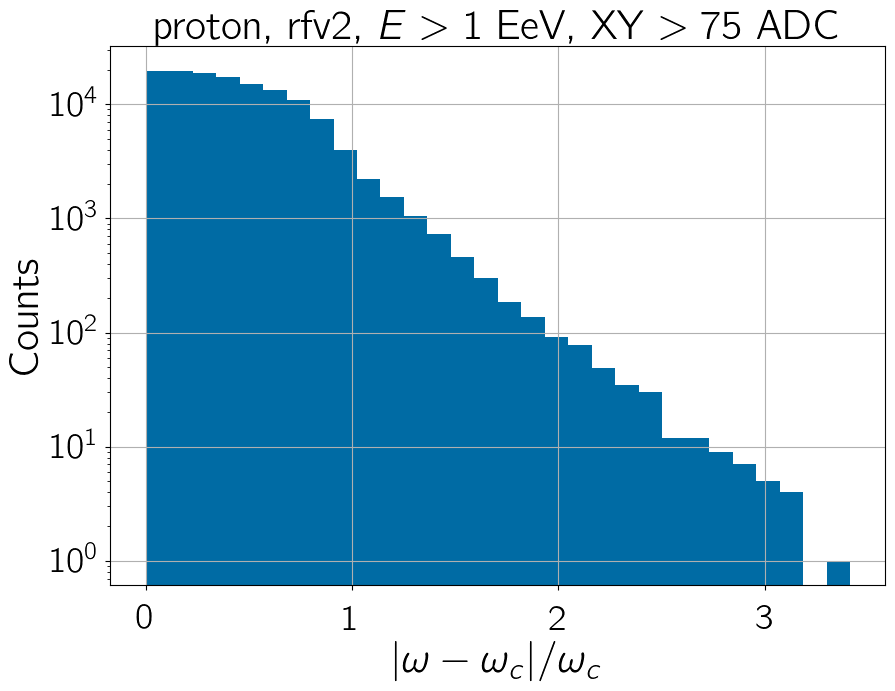

In [7]:
omega_diff = np.abs(omega-omega_c)/omega_c

fig, ax = plt.subplots()

ax.hist(omega_diff,bins=30)

ax.set_yscale('log')

ax.set_xlabel(r'$|\omega-\omega_c|/\omega_c$')
ax.set_ylabel('Counts')

ax.set_title(f'{primary}, {rf_chain}, ' + r'$E>1$ EeV, ' + f'{pol}' + r' $> 75$ ADC')

plt.show()

In the selected DUs of the simulations, we expect that as the zenith becomes more horizontal, the distribution of $\omega$ (centered around $\omega_c$) will become more narrow. This is due to the fact that the footprint becomes much larger for horizontal showers.

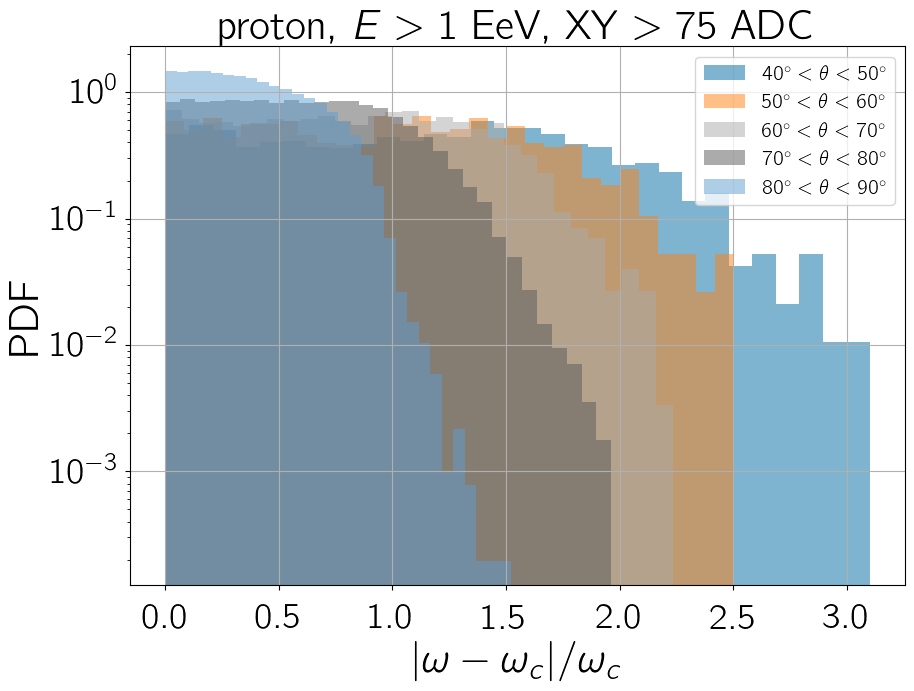

In [8]:
zenith_edges = np.linspace(40,90,6)

fig, ax = plt.subplots()

for i in range(len(zenith_edges[:-1])):
    mask = np.where(np.logical_and(zenith>zenith_edges[i],zenith<zenith_edges[i+1]))[0]
    
    label = r'$' + '{:.0f}'.format(zenith_edges[i]) + r'^{\circ}< \theta <' + '{:.0f}'.format(zenith_edges[i+1]) + r'^{\circ}$'
    ax.hist(omega_diff[mask],bins=30,density=True,alpha=.5,label=label)

    ax.set_yscale('log')

    ax.set_xlabel(r'$|\omega-\omega_c|/\omega_c$')
    ax.set_ylabel('PDF')

    ax.set_title(f'{primary}, ' + r'$E>1$ EeV, ' + f'{pol}' + r' $> 75$ ADC')

    ax.legend(frameon=True,fontsize=15)

plt.show()

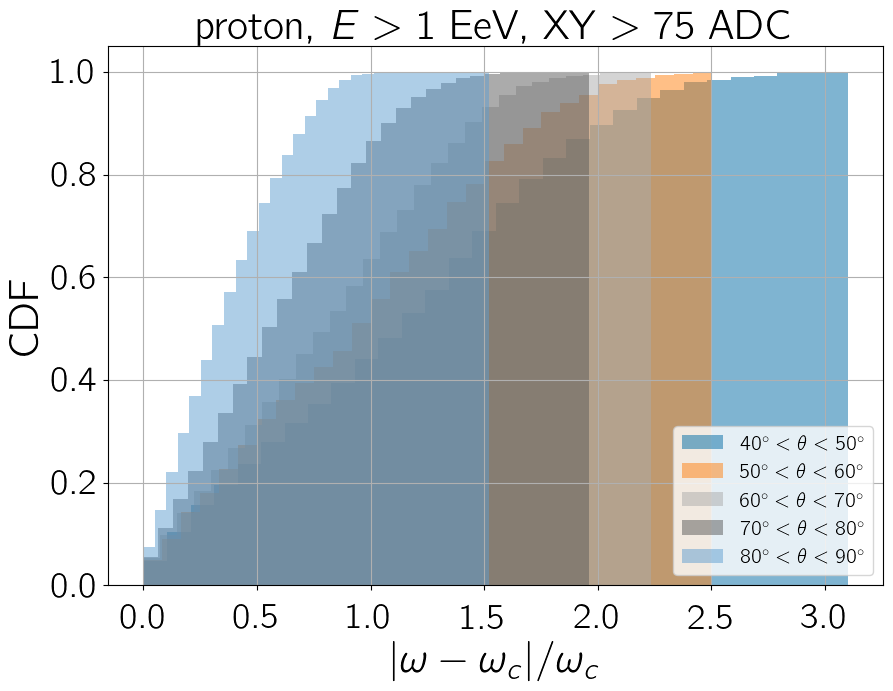

In [9]:
zenith_edges = np.linspace(40,90,6)

fig, ax = plt.subplots()

for i in range(len(zenith_edges[:-1])):
    mask = np.where(np.logical_and(zenith>zenith_edges[i],zenith<zenith_edges[i+1]))[0]
    
    label = r'$' + '{:.0f}'.format(zenith_edges[i]) + r'^{\circ}< \theta <' + '{:.0f}'.format(zenith_edges[i+1]) + r'^{\circ}$'
    ax.hist(omega_diff[mask],bins=30,density=True,alpha=.5,cumulative=True,label=label)

    #ax.set_yscale('log')

    ax.set_xlabel(r'$|\omega-\omega_c|/\omega_c$')
    ax.set_ylabel('CDF')

    ax.set_title(f'{primary}, ' + r'$E>1$ EeV, ' + f'{pol}' + r' $> 75$ ADC')

    ax.legend(frameon=True,fontsize=15,loc='lower right')

plt.show()

Plots above indicate that most of the interesting traces have $|\omega-\omega_c|/\omega_c < 2$. As such, we randomly select $20 \times 5$ traces binned uniformly in $|\omega-\omega_c|/\omega_c \in [0,2]$ (20 bins with width of 0.2) and in the simulated zenith range $\theta \in [31^\circ,87^\circ]$ (5 bins with width $11.2^\circ$).

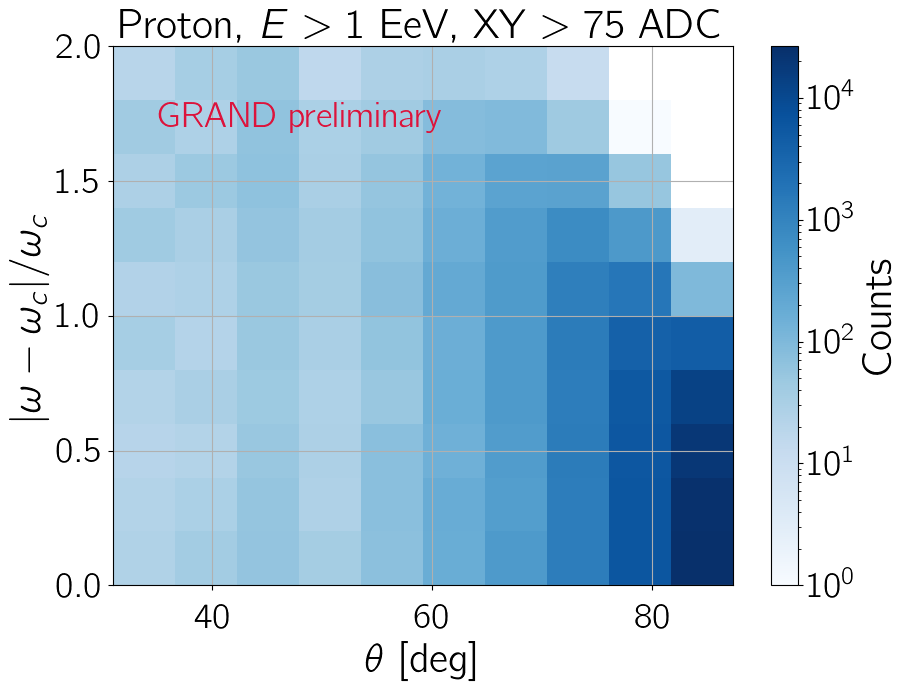

In [10]:
zenith_edges     = np.linspace(np.min(zenith),np.max(zenith),11)
omega_diff_edges = np.linspace(0,2,11)

fig, ax = plt.subplots()

hist2d = ax.hist2d(zenith,
                   omega_diff,
                   bins=[zenith_edges,omega_diff_edges],
                   cmap='Blues',
                   norm=matplotlib.colors.LogNorm())

fig.colorbar(hist2d[3], ax=ax, label='Counts')

ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$|\omega-\omega_c|/\omega_c$')

ax.set_title(f'{primary.capitalize()}, ' + r'$E>1$ EeV, ' + f'{pol}' + r' $> 75$ ADC')

ax.text(35,1.7,'GRAND preliminary', color='crimson')

ax.grid(True)

if savefig:
    plot_name = 'templates_XY_theta_omega'
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()

Here we perform the selection. In each bin of the plot above, we chose a random trace as template.

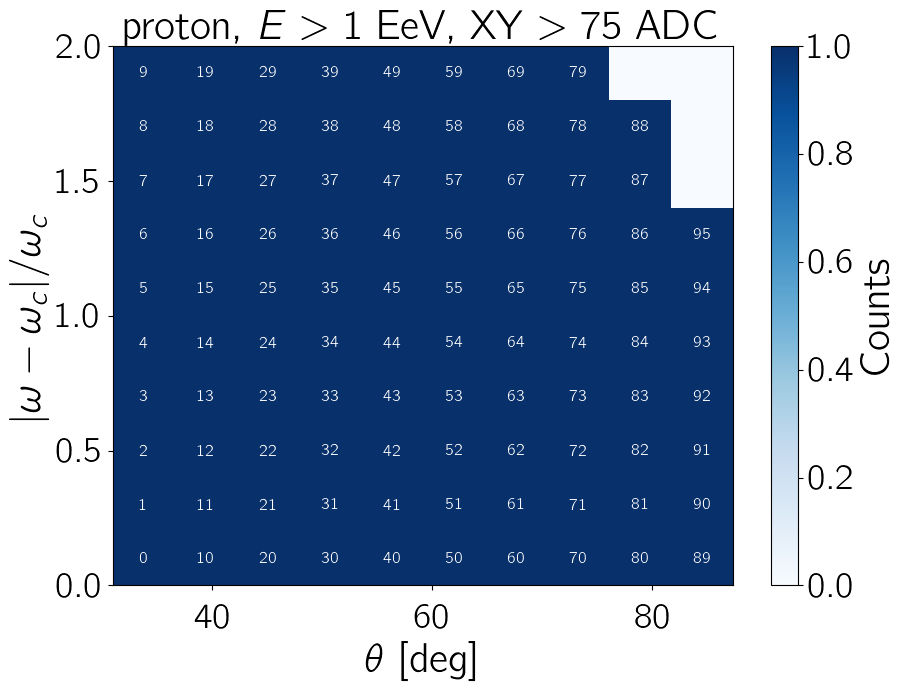

In [11]:
seed = int(2e5) # for GRAND200k! :)
np.random.seed(seed)

n_bins_zenith = len(zenith_edges)-1
n_bins_omega  = len(omega_diff_edges)-1
mask_sel      = np.zeros((n_bins_zenith,n_bins_omega),dtype=int)


for i in range(n_bins_zenith):
    mask_zenith = np.where( np.logical_and( zenith >= zenith_edges[i], zenith < zenith_edges[i+1] ) )[0]

    for j in range(n_bins_omega):
        mask_omega = np.where( np.logical_and( omega_diff[mask_zenith] >= omega_diff_edges[j], omega_diff[mask_zenith] < omega_diff_edges[j+1] ) )[0]

        if mask_omega.size > 0:
            mask_sel[i,j] = np.random.choice(mask_zenith[mask_omega])
            #print(zenith[mask_sel[i,j]],omega_diff[mask_sel[i,j]])

mask_sel = mask_sel[mask_sel>0].flatten()


fig, ax = plt.subplots()

hist2d = ax.hist2d(zenith[mask_sel],
                   omega_diff[mask_sel],
                   bins=[zenith_edges,omega_diff_edges],
                   cmap='Blues')

fig.colorbar(hist2d[3], ax=ax, label='Counts')

ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$|\omega-\omega_c|/\omega_c$')

ax.set_title(f'{primary}, ' + r'$E>1$ EeV, ' + f'{pol}' + r' $> 75$ ADC')


bin_centers_zenith = (zenith_edges[:-1] + zenith_edges[1:])/2
bin_centers_omega  = (omega_diff_edges[:-1] + omega_diff_edges[1:])/2
k = 0
for i, bin_zenith in enumerate(bin_centers_zenith):
    for j, bin_omega in enumerate(bin_centers_omega):
        if hist2d[0][i,j] != 0:
            ax.text(bin_zenith,bin_omega,k,fontsize=12,va='center',ha='center',color='w')
            k += 1

ax.grid(False)

plt.show()

Now it's time to actually select the template traces and save them. We only save a window $w = [t_{\max}-30,t_{\max}+70]$ of 100 samples (200 ns) of a template, where $t_{\max}$ is the time where the absolute value of the trace is maximal.

Each template is normalized by its RMS within the selected window.

Keep the ADC templates at a sampling rate of 2 Gsps for more resolution (can desample afterwards).

In [12]:
t_minus_peak = 30*4 # [ADC samples]
t_plus_peak  = 70*4
templates    = np.empty((mask_sel.size,t_minus_peak+t_plus_peak))

In [13]:
def rms(trace):
    return np.sqrt( np.mean( trace**2 ) )

log10(E/GeV) = 9.25, theta = 35.54 deg, phi = 229.81 deg, omega = 0.932 deg, omega_c = 1.146 deg, |omega-omega_c|/omega_c = 0.187 
Vpp = [4959.  295. 1994.] ADC counts, pulse_width = [46. 18. 59.] ADC samples, n_peaks = [16.  5. 18.], peak_ratio = [1.34690014 1.464      1.4708798 ], peak_dist = [2. 7. 2.] ADC samples


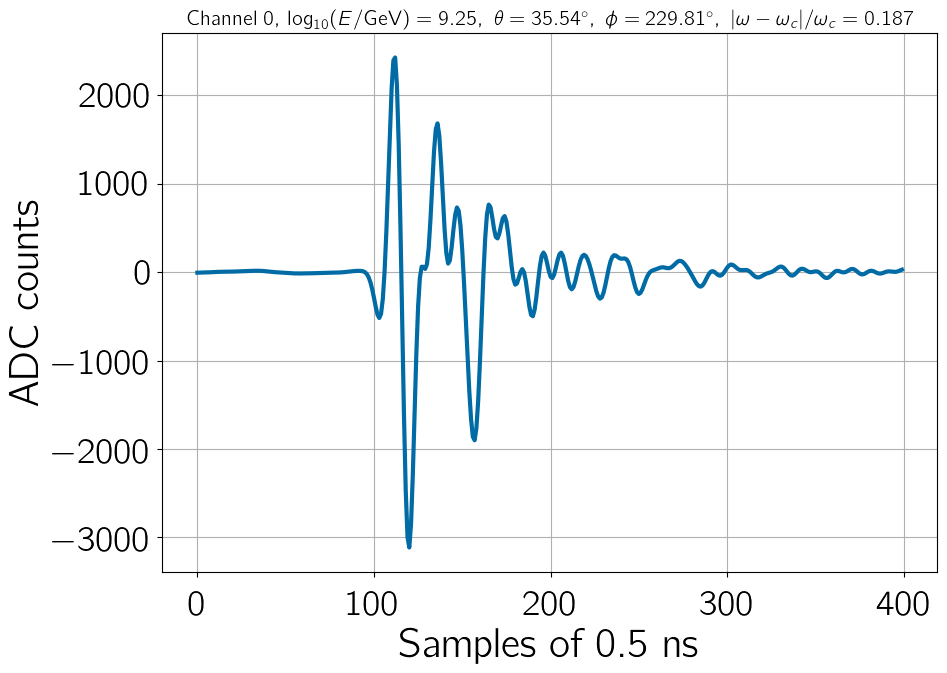

log10(E/GeV) = 9.19, theta = 34.13 deg, phi = 192.63 deg, omega = 0.898 deg, omega_c = 1.158 deg, |omega-omega_c|/omega_c = 0.225 
Vpp = [348. 225. 332.] ADC counts, pulse_width = [14.  8. 21.] ADC samples, n_peaks = [5. 3. 6.], peak_ratio = [1.3        1.2972973  1.85950413], peak_dist = [ 8.  8. 13.] ADC samples


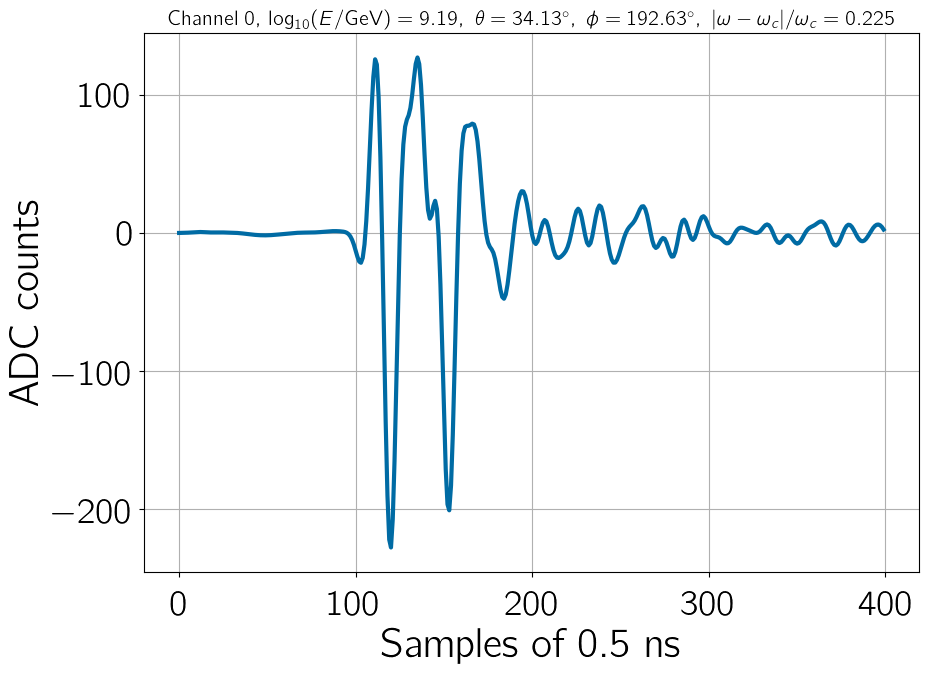

log10(E/GeV) = 9.19, theta = 32.43 deg, phi = 96.21 deg, omega = 0.568 deg, omega_c = 1.118 deg, |omega-omega_c|/omega_c = 0.492 
Vpp = [4357. 4013. 4573.] ADC counts, pulse_width = [43. 43. 83.] ADC samples, n_peaks = [13. 14. 20.], peak_ratio = [1.33369041 1.21957965 1.29683576], peak_dist = [2. 2. 2.] ADC samples


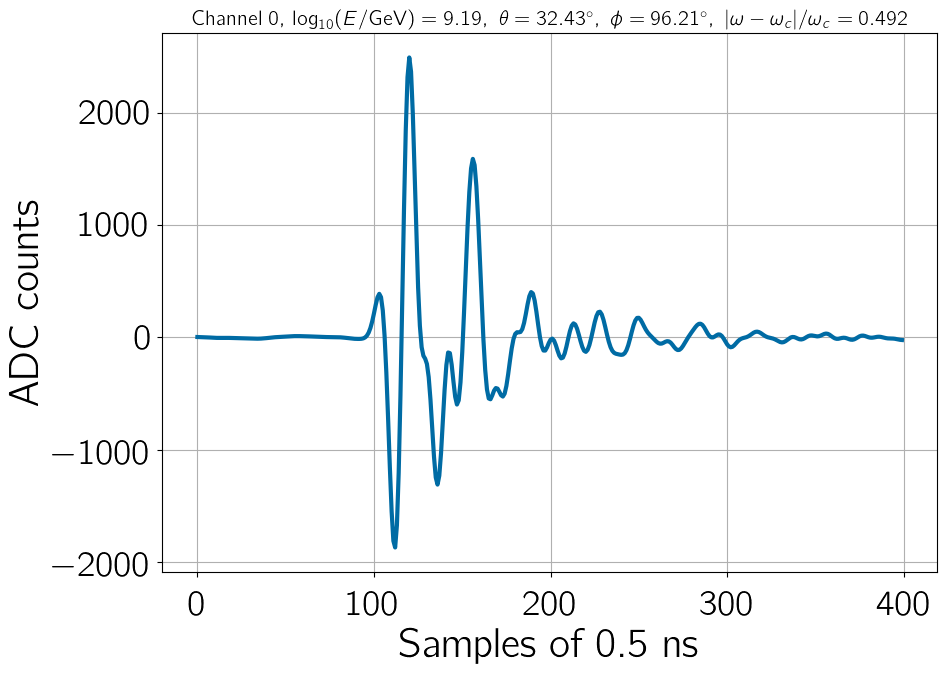

log10(E/GeV) = 9.09, theta = 35.52 deg, phi = 22.35 deg, omega = 0.333 deg, omega_c = 1.051 deg, |omega-omega_c|/omega_c = 0.683 
Vpp = [ 887. 5038.  124.] ADC counts, pulse_width = [15. 57. -1.] ADC samples, n_peaks = [ 6. 19.  0.], peak_ratio = [ 1.08215962  1.12753378 -1.        ], peak_dist = [ 2.  4. -1.] ADC samples


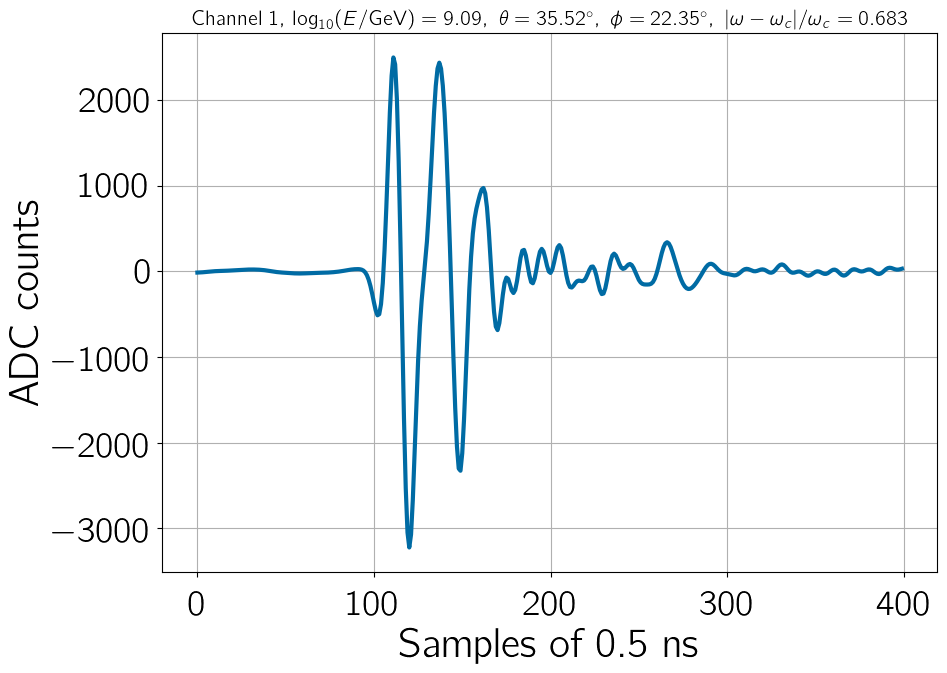

log10(E/GeV) = 9.59, theta = 32.41 deg, phi = 194.35 deg, omega = 2.098 deg, omega_c = 1.115 deg, |omega-omega_c|/omega_c = 0.881 
Vpp = [1208.  360.  811.] ADC counts, pulse_width = [19. 15. 55.] ADC samples, n_peaks = [ 6.  5. 16.], peak_ratio = [1.14564831 1.78030303 1.48773006], peak_dist = [3. 8. 3.] ADC samples


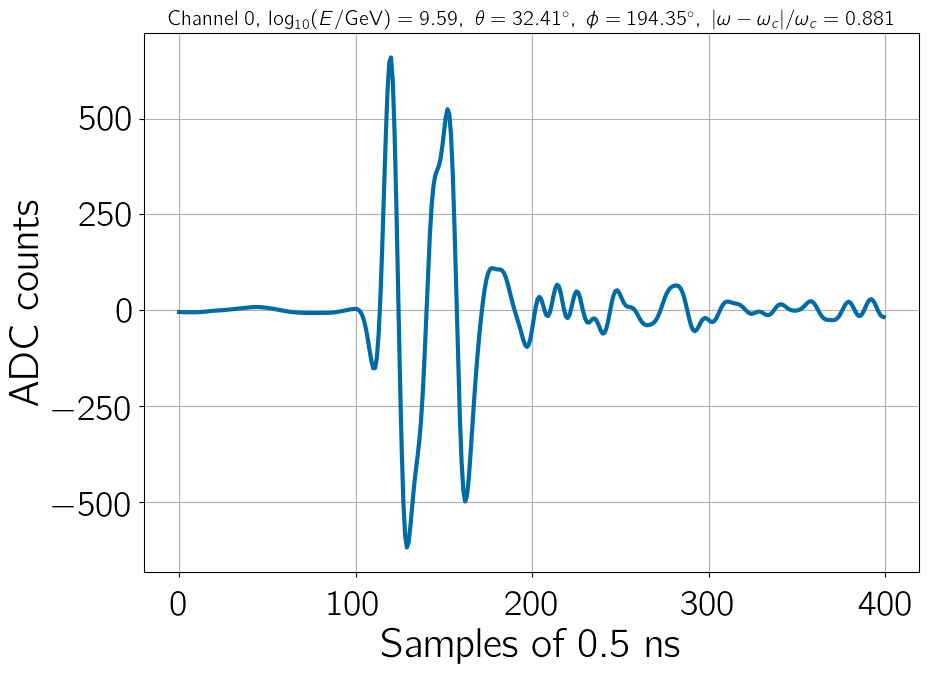

log10(E/GeV) = 9.21, theta = 35.88 deg, phi = 347.27 deg, omega = 2.384 deg, omega_c = 1.123 deg, |omega-omega_c|/omega_c = 1.122 
Vpp = [ 630. 1476.  363.] ADC counts, pulse_width = [15. 39. 29.] ADC samples, n_peaks = [6. 8. 7.], peak_ratio = [1.07236842 1.025      1.12280702], peak_dist = [3. 7. 5.] ADC samples


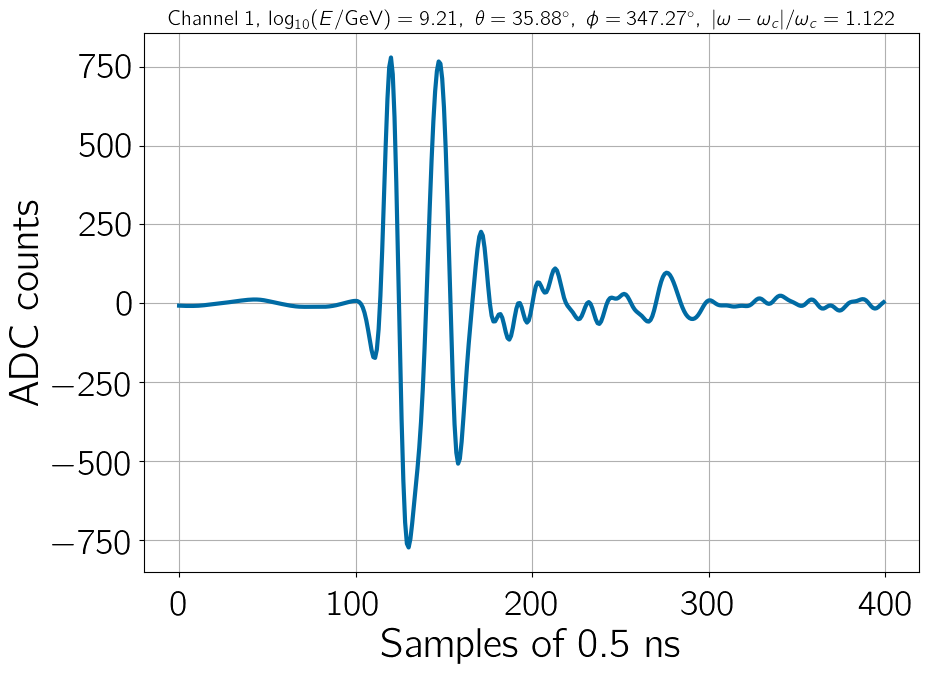

log10(E/GeV) = 9.21, theta = 35.88 deg, phi = 347.27 deg, omega = 2.652 deg, omega_c = 1.123 deg, |omega-omega_c|/omega_c = 1.361 
Vpp = [281. 958. 284.] ADC counts, pulse_width = [ 6. 15. 24.] ADC samples, n_peaks = [3. 6. 6.], peak_ratio = [1.12878788 1.00838574 1.04316547], peak_dist = [2. 4. 5.] ADC samples


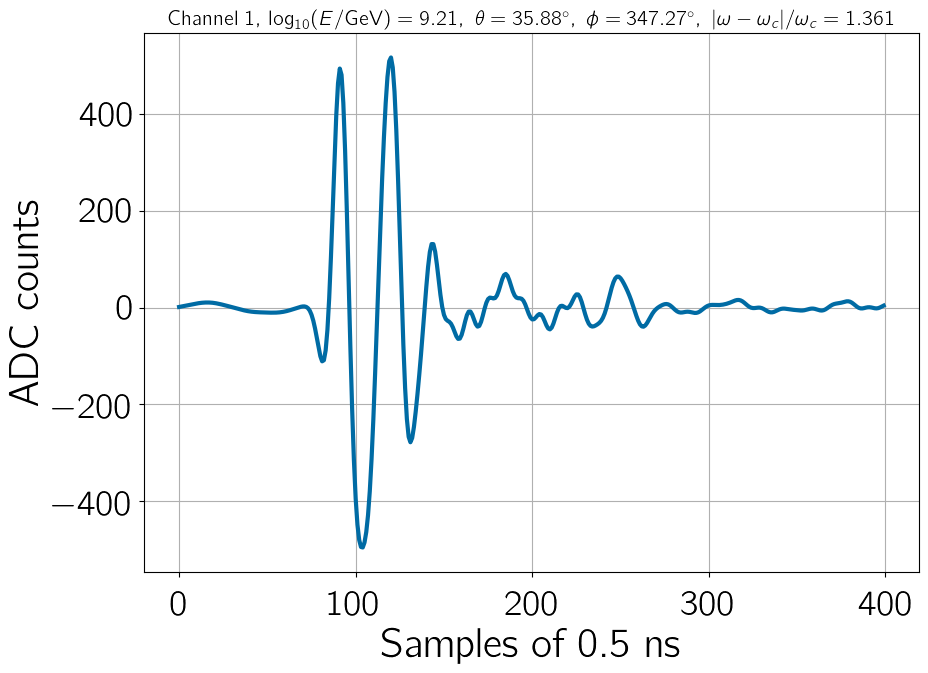

log10(E/GeV) = 9.12, theta = 36.40 deg, phi = 233.14 deg, omega = 2.679 deg, omega_c = 1.062 deg, |omega-omega_c|/omega_c = 1.524 
Vpp = [225.  74. 126.] ADC counts, pulse_width = [ 8. -1. -1.] ADC samples, n_peaks = [3. 0. 0.], peak_ratio = [ 1.14285714 -1.         -1.        ], peak_dist = [ 4. -1. -1.] ADC samples


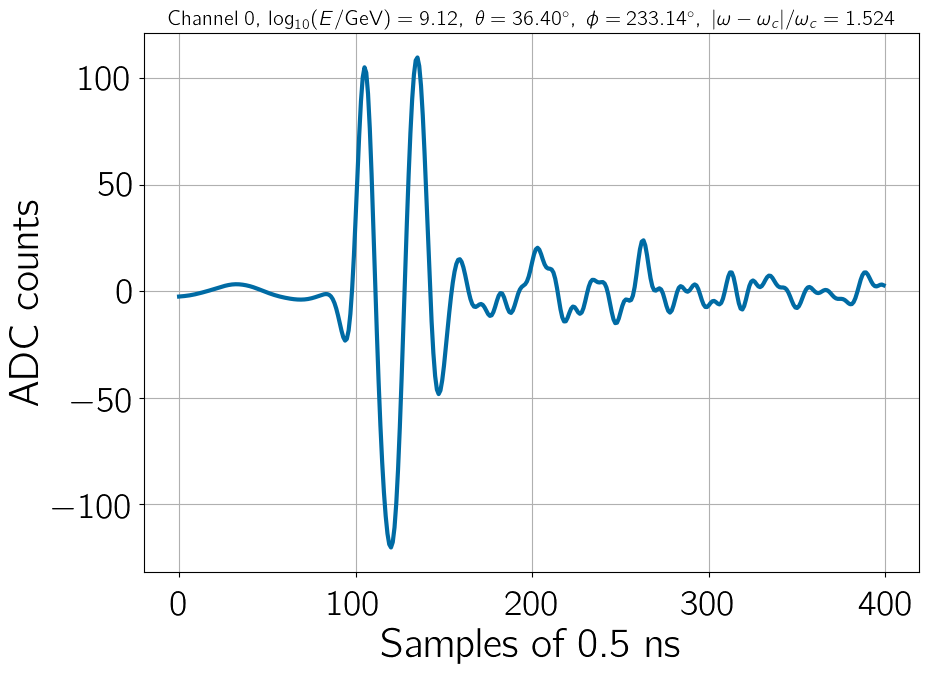

log10(E/GeV) = 9.35, theta = 34.06 deg, phi = 281.16 deg, omega = 3.079 deg, omega_c = 1.116 deg, |omega-omega_c|/omega_c = 1.760 
Vpp = [319. 511.  68.] ADC counts, pulse_width = [12. 16. -1.] ADC samples, n_peaks = [4. 5. 0.], peak_ratio = [ 1.09868421  1.08571429 -1.        ], peak_dist = [ 5.  3. -1.] ADC samples


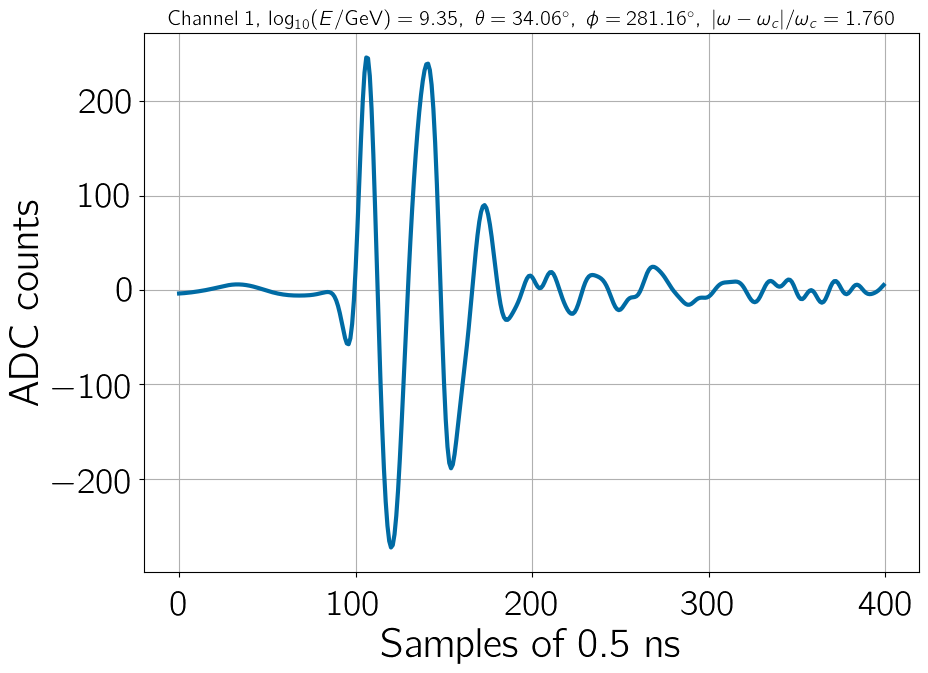

log10(E/GeV) = 9.34, theta = 32.17 deg, phi = 48.24 deg, omega = 3.163 deg, omega_c = 1.110 deg, |omega-omega_c|/omega_c = 1.849 
Vpp = [224. 355. 356.] ADC counts, pulse_width = [ 8. 12. 32.] ADC samples, n_peaks = [3. 4. 6.], peak_ratio = [1.24       1.00564972 1.02272727], peak_dist = [4. 4. 6.] ADC samples


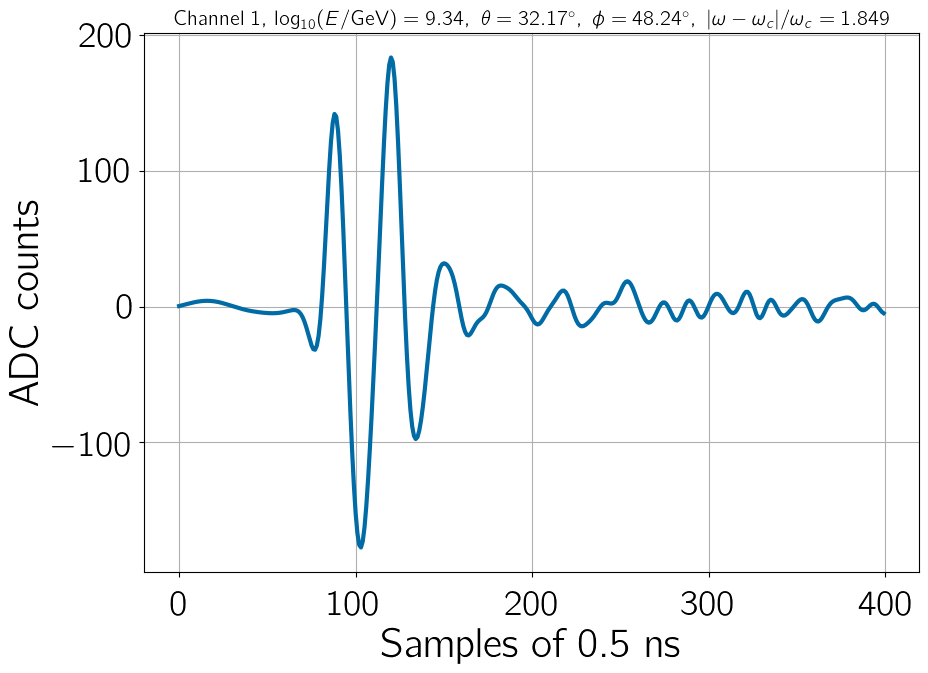

log10(E/GeV) = 9.04, theta = 37.32 deg, phi = 273.76 deg, omega = 1.228 deg, omega_c = 1.046 deg, |omega-omega_c|/omega_c = 0.174 
Vpp = [2259. 2196.  618.] ADC counts, pulse_width = [34. 35. 46.] ADC samples, n_peaks = [11.  9. 13.], peak_ratio = [1.23221344 1.17857143 1.20905923], peak_dist = [ 2.  2. 14.] ADC samples


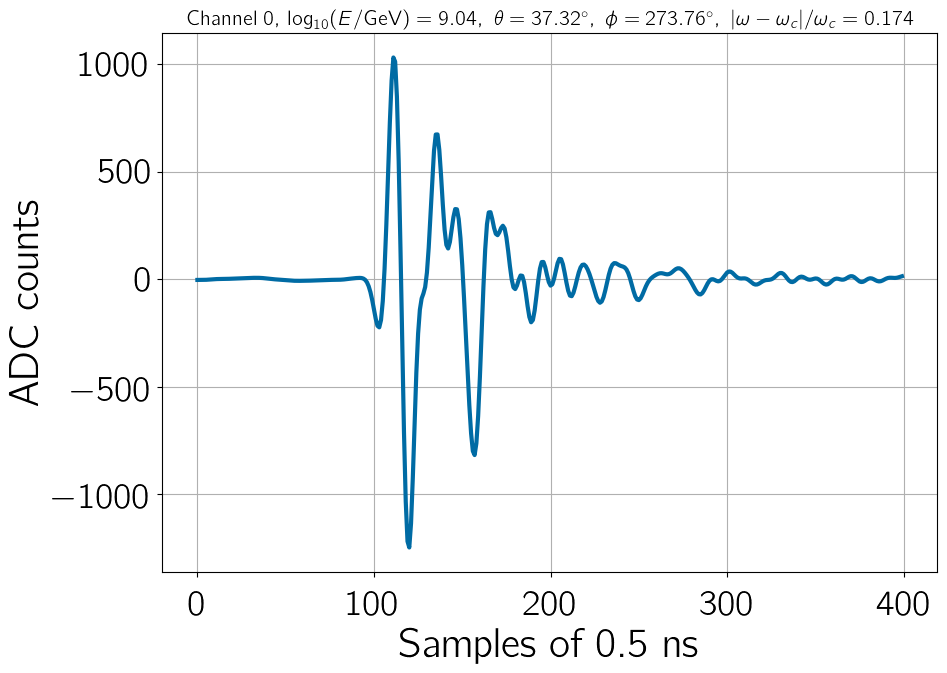

log10(E/GeV) = 9.48, theta = 41.34 deg, phi = 321.98 deg, omega = 0.869 deg, omega_c = 1.094 deg, |omega-omega_c|/omega_c = 0.206 
Vpp = [ 4869. 11186.  4013.] ADC counts, pulse_width = [50. 70. 67.] ADC samples, n_peaks = [18. 20. 22.], peak_ratio = [1.22024624 1.21856406 1.16334232], peak_dist = [4. 2. 4.] ADC samples


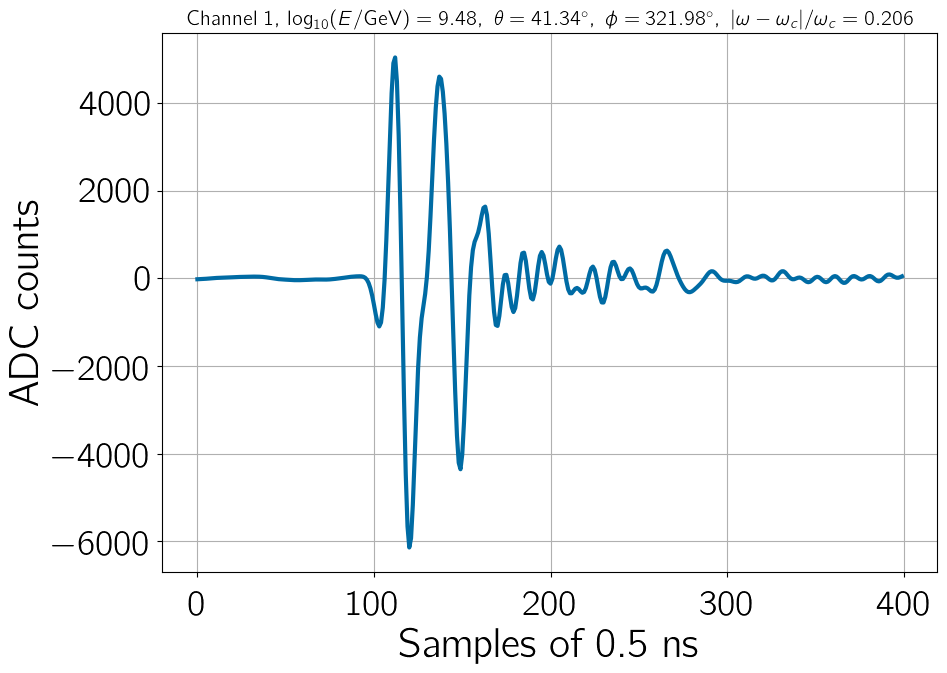

log10(E/GeV) = 9.14, theta = 41.06 deg, phi = 51.14 deg, omega = 1.616 deg, omega_c = 1.110 deg, |omega-omega_c|/omega_c = 0.455 
Vpp = [1920. 2459. 1390.] ADC counts, pulse_width = [42. 46. 60.] ADC samples, n_peaks = [12. 12. 16.], peak_ratio = [1.22222222 1.14908457 1.32441472], peak_dist = [2. 8. 3.] ADC samples


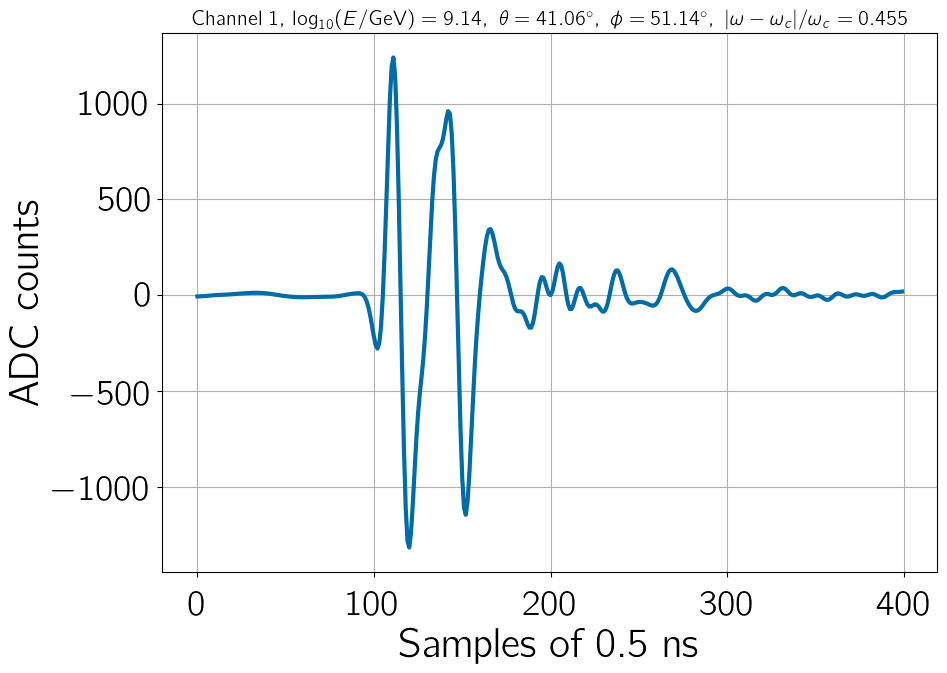

log10(E/GeV) = 9.37, theta = 38.71 deg, phi = 23.11 deg, omega = 1.953 deg, omega_c = 1.086 deg, |omega-omega_c|/omega_c = 0.799 
Vpp = [ 631. 3088.  394.] ADC counts, pulse_width = [15. 45. 39.] ADC samples, n_peaks = [ 6. 15.  8.], peak_ratio = [1.13175676 1.03559657 1.25142857], peak_dist = [4. 5. 5.] ADC samples


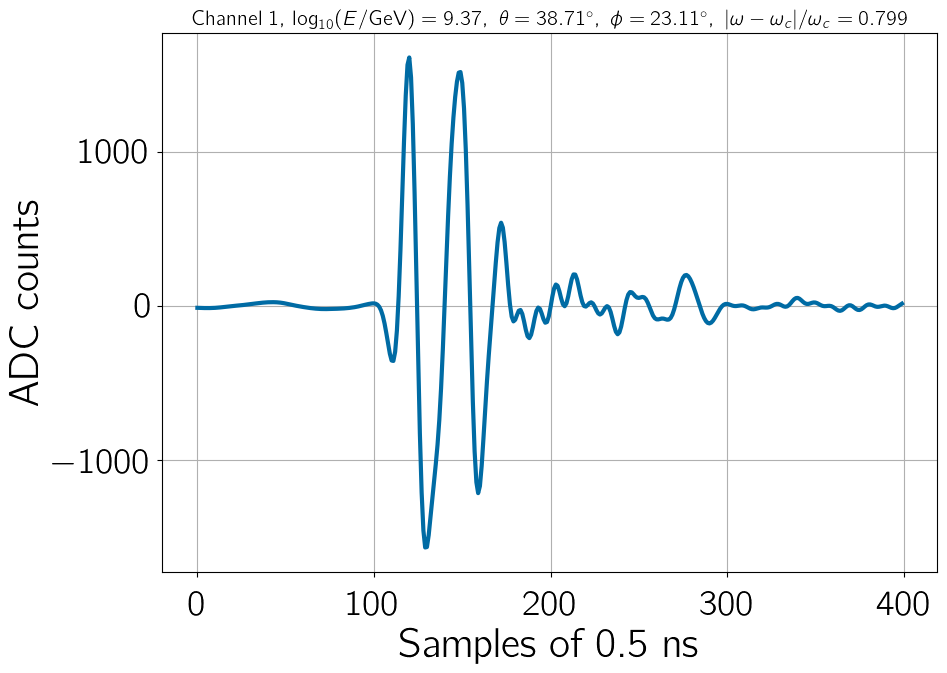

log10(E/GeV) = 9.48, theta = 41.34 deg, phi = 321.98 deg, omega = 2.064 deg, omega_c = 1.094 deg, |omega-omega_c|/omega_c = 0.886 
Vpp = [1387. 3086. 1214.] ADC counts, pulse_width = [42. 45. 53.] ADC samples, n_peaks = [ 9. 14. 12.], peak_ratio = [1.03671072 1.00259572 1.08950086], peak_dist = [4. 2. 5.] ADC samples


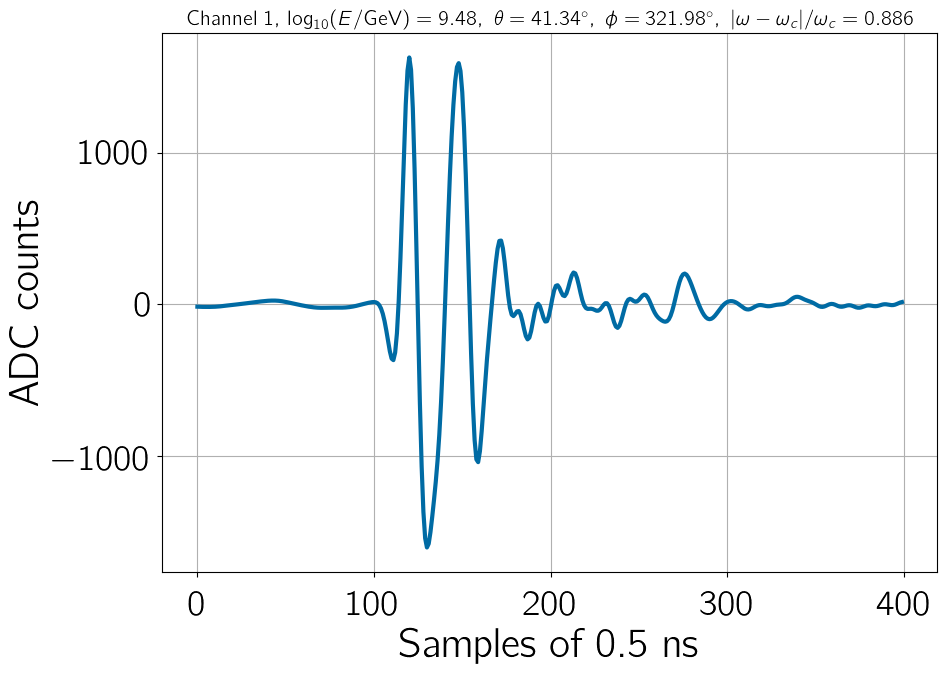

log10(E/GeV) = 9.14, theta = 41.06 deg, phi = 51.14 deg, omega = 2.221 deg, omega_c = 1.110 deg, |omega-omega_c|/omega_c = 1.000 
Vpp = [571. 987. 561.] ADC counts, pulse_width = [13. 14. 52.] ADC samples, n_peaks = [ 5.  5. 11.], peak_ratio = [1.03202847 1.03448276 1.27822581], peak_dist = [2. 8. 9.] ADC samples


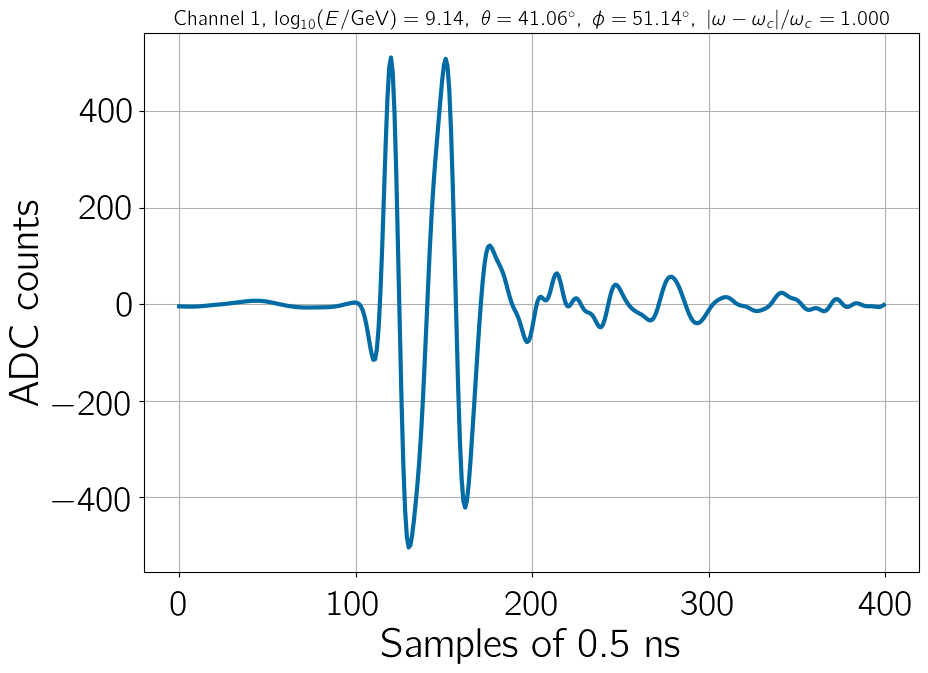

log10(E/GeV) = 9.11, theta = 42.14 deg, phi = 115.44 deg, omega = 2.511 deg, omega_c = 1.086 deg, |omega-omega_c|/omega_c = 1.312 
Vpp = [298.  99. 370.] ADC counts, pulse_width = [ 7. -1. 39.] ADC samples, n_peaks = [3. 0. 7.], peak_ratio = [ 1.08391608 -1.          1.05405405], peak_dist = [ 3. -1. 14.] ADC samples


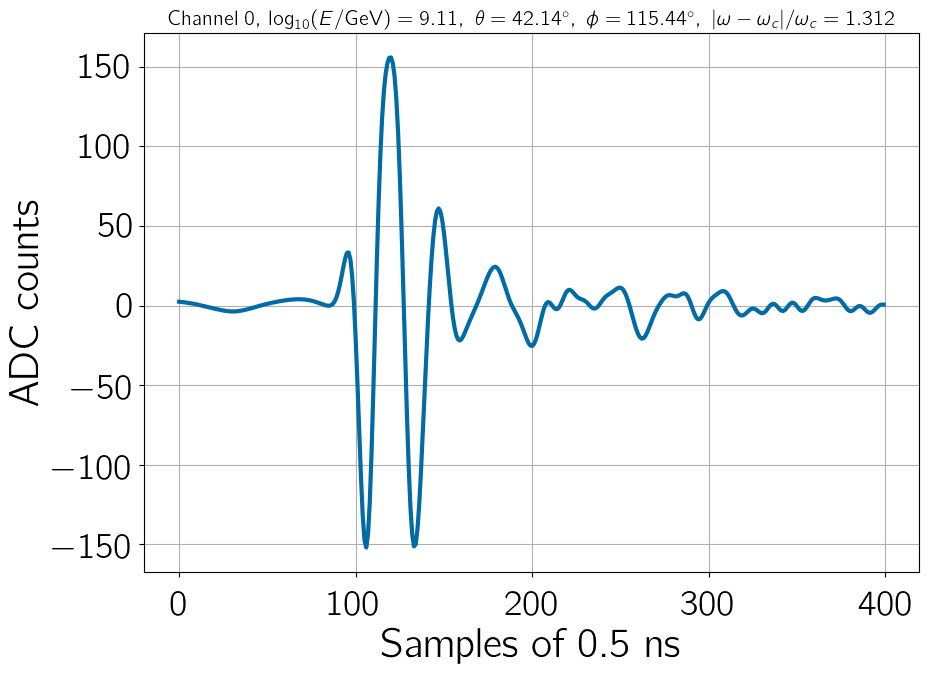

log10(E/GeV) = 9.26, theta = 40.10 deg, phi = 221.61 deg, omega = 2.623 deg, omega_c = 1.055 deg, |omega-omega_c|/omega_c = 1.487 
Vpp = [212.  74. 204.] ADC counts, pulse_width = [ 7. -1. 24.] ADC samples, n_peaks = [3. 0. 5.], peak_ratio = [ 1.0990099  -1.          1.16161616], peak_dist = [ 4. -1. 13.] ADC samples


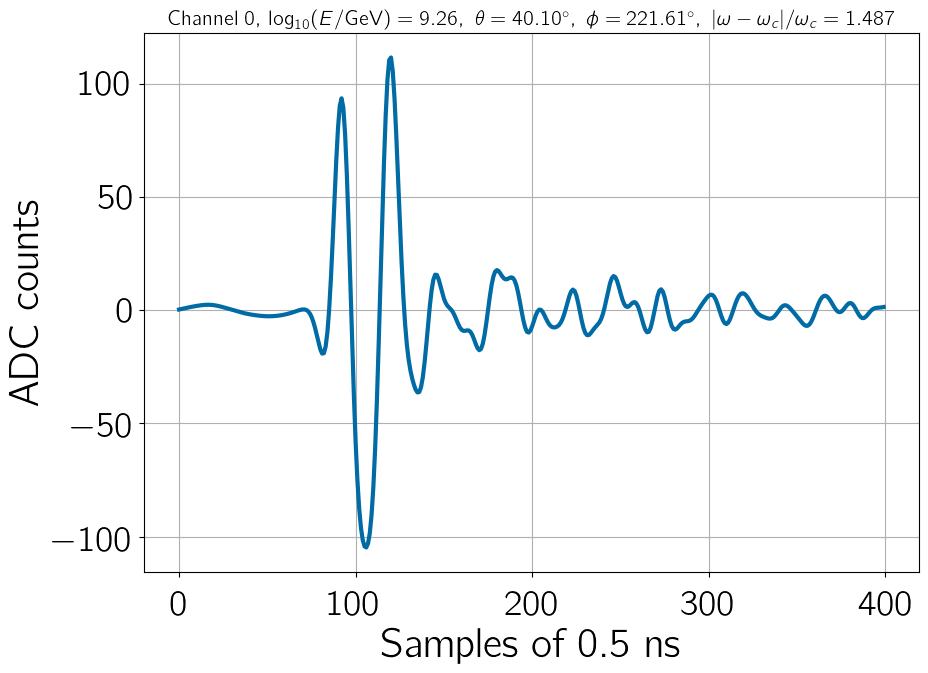

log10(E/GeV) = 9.48, theta = 41.34 deg, phi = 321.98 deg, omega = 2.940 deg, omega_c = 1.094 deg, |omega-omega_c|/omega_c = 1.687 
Vpp = [270. 526. 279.] ADC counts, pulse_width = [ 7. 10. 32.] ADC samples, n_peaks = [3. 4. 6.], peak_ratio = [1.109375   1.20083682 1.04285714], peak_dist = [ 3.  4. 13.] ADC samples


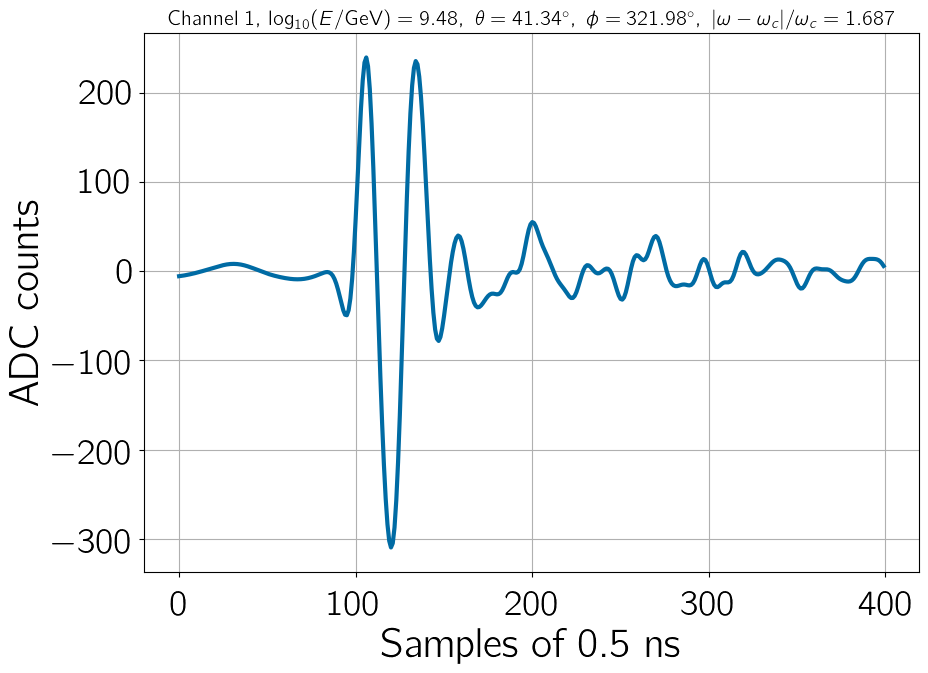

log10(E/GeV) = 9.09, theta = 38.95 deg, phi = 66.39 deg, omega = 2.997 deg, omega_c = 1.067 deg, |omega-omega_c|/omega_c = 1.809 
Vpp = [124. 164. 164.] ADC counts, pulse_width = [-1.  4. 19.] ADC samples, n_peaks = [0. 2. 4.], peak_ratio = [-1.          1.1025641   1.07594937], peak_dist = [-1.  4. 13.] ADC samples


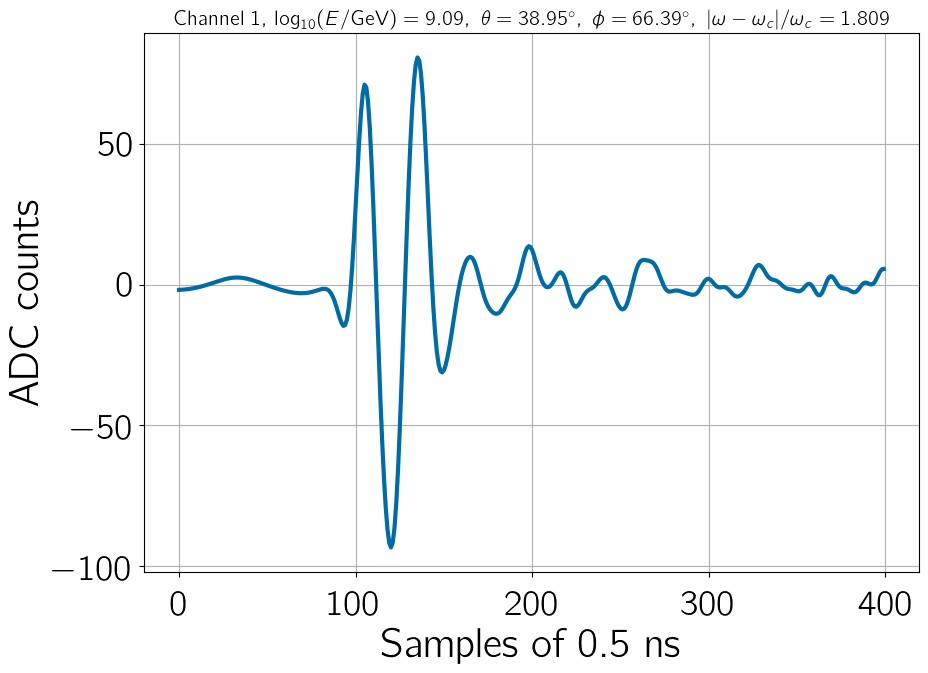

log10(E/GeV) = 9.51, theta = 45.31 deg, phi = 20.68 deg, omega = 1.200 deg, omega_c = 1.158 deg, |omega-omega_c|/omega_c = 0.036 
Vpp = [ 2636. 13050.   602.] ADC counts, pulse_width = [44. 75. 37.] ADC samples, n_peaks = [15. 23. 13.], peak_ratio = [1.2414966  1.1523998  1.01337793], peak_dist = [4. 4. 5.] ADC samples


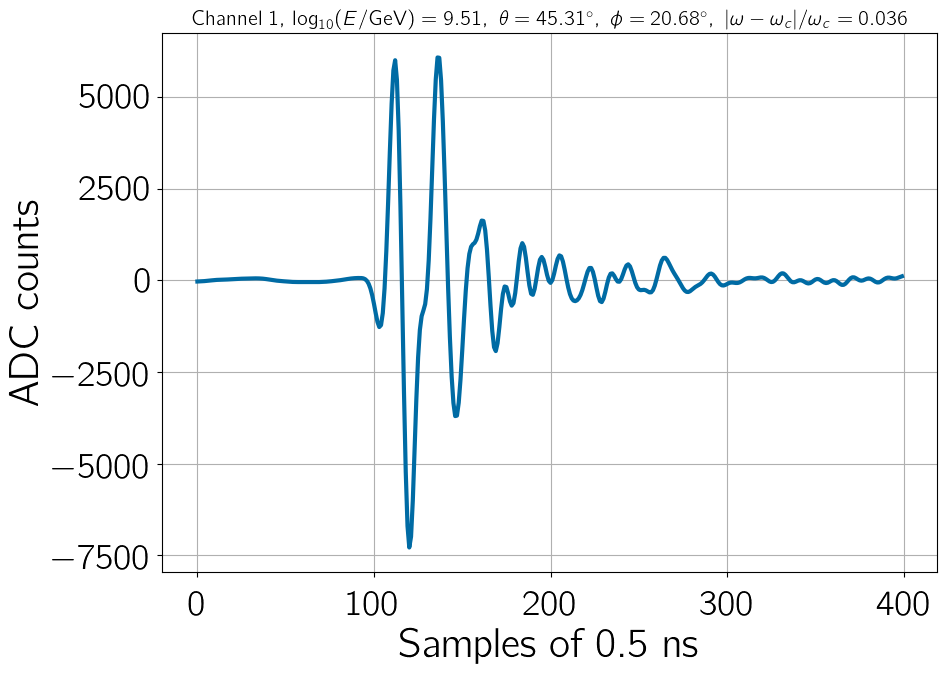

log10(E/GeV) = 9.56, theta = 46.39 deg, phi = 21.20 deg, omega = 1.417 deg, omega_c = 1.048 deg, |omega-omega_c|/omega_c = 0.351 
Vpp = [3077. 9137. 2214.] ADC counts, pulse_width = [38. 72. 62.] ADC samples, n_peaks = [13. 20. 21.], peak_ratio = [1.09604905 1.0956422  1.08867925], peak_dist = [2. 4. 5.] ADC samples


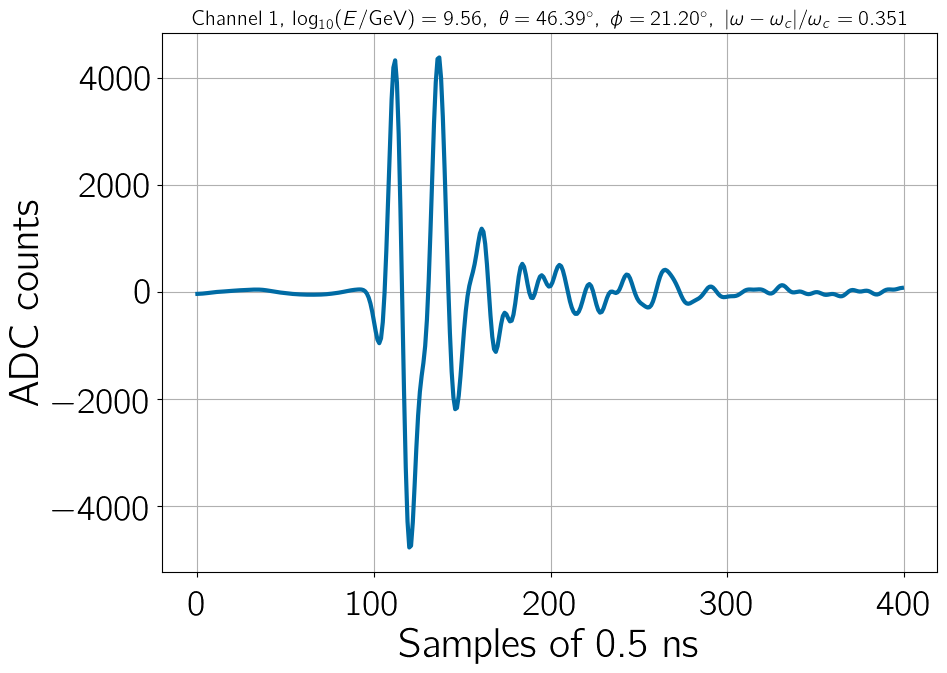

log10(E/GeV) = 9.13, theta = 43.40 deg, phi = 22.02 deg, omega = 0.580 deg, omega_c = 1.020 deg, |omega-omega_c|/omega_c = 0.431 
Vpp = [ 504. 5786.  314.] ADC counts, pulse_width = [14. 49. 32.] ADC samples, n_peaks = [ 6. 16.  5.], peak_ratio = [1.11764706 1.12019055 1.21126761], peak_dist = [3. 3. 5.] ADC samples


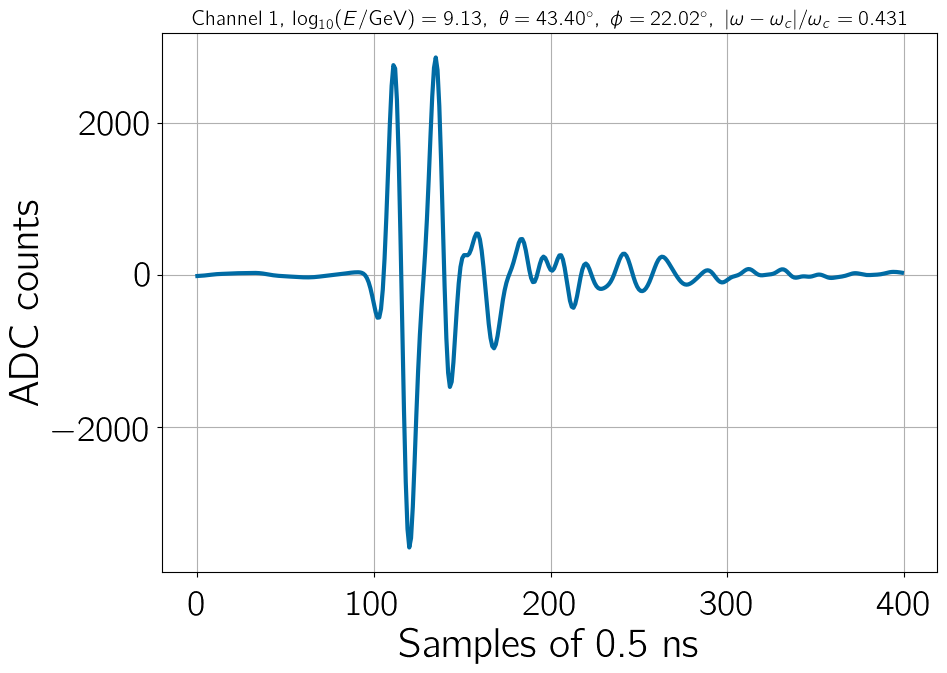

log10(E/GeV) = 9.25, theta = 45.42 deg, phi = 21.55 deg, omega = 1.932 deg, omega_c = 1.078 deg, |omega-omega_c|/omega_c = 0.792 
Vpp = [ 428. 1996.  220.] ADC counts, pulse_width = [12. 39. 10.] ADC samples, n_peaks = [ 5. 10.  3.], peak_ratio = [1.03809524 1.13247863 1.0952381 ], peak_dist = [3. 3. 5.] ADC samples


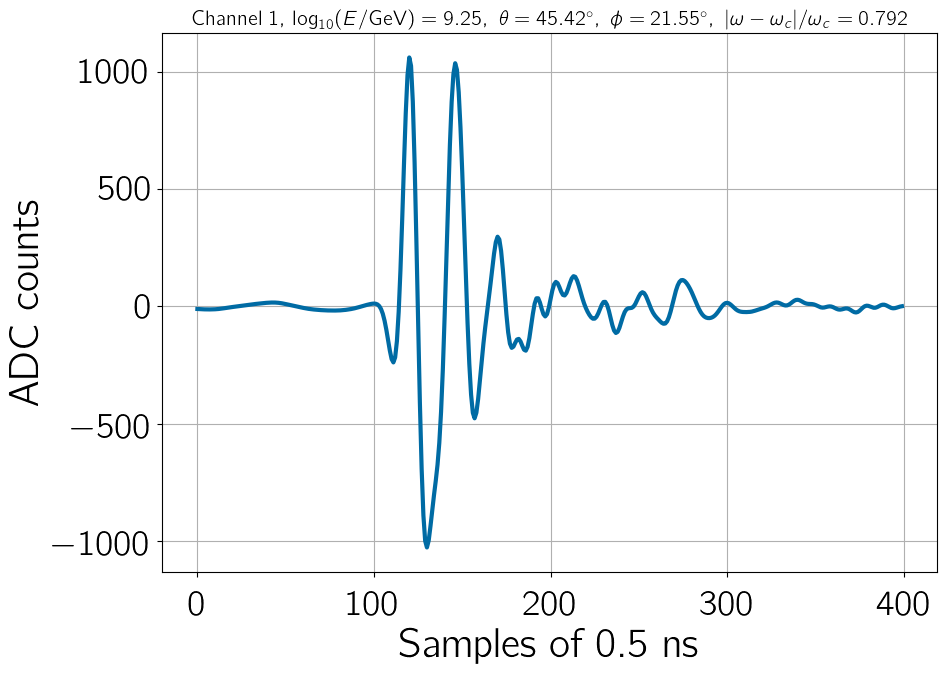

log10(E/GeV) = 9.50, theta = 47.81 deg, phi = 289.11 deg, omega = 1.792 deg, omega_c = 0.987 deg, |omega-omega_c|/omega_c = 0.815 
Vpp = [1465. 1506. 1325.] ADC counts, pulse_width = [28. 41. 60.] ADC samples, n_peaks = [11.  9. 11.], peak_ratio = [1.33280255 1.02147651 1.20559211], peak_dist = [ 3.  4. 13.] ADC samples


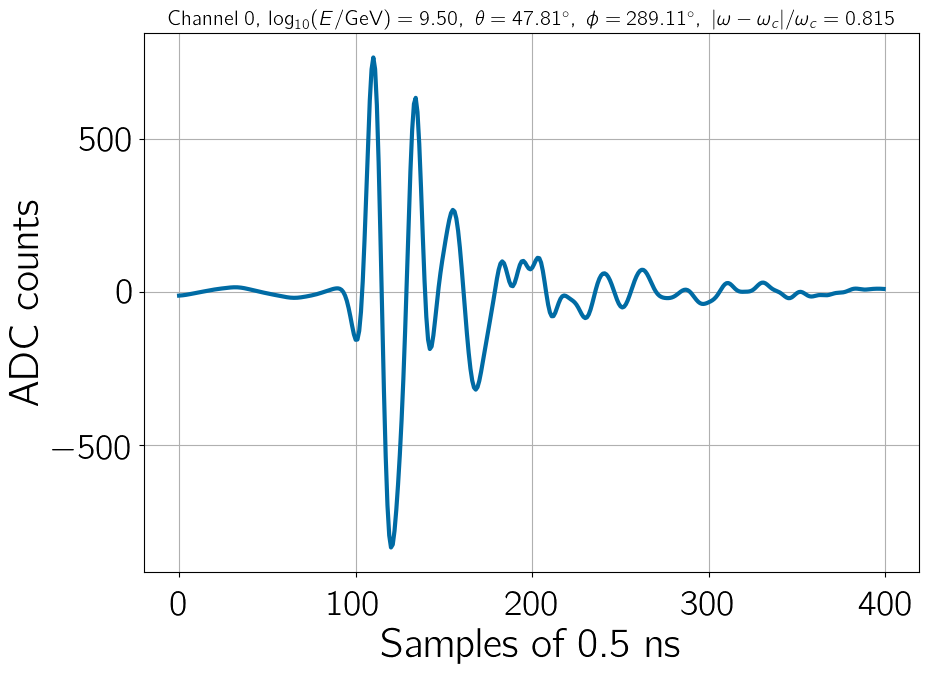

log10(E/GeV) = 9.32, theta = 47.67 deg, phi = 128.34 deg, omega = 2.035 deg, omega_c = 0.990 deg, |omega-omega_c|/omega_c = 1.055 
Vpp = [688. 223. 456.] ADC counts, pulse_width = [10.  3. 38.] ADC samples, n_peaks = [4. 2. 8.], peak_ratio = [1.06606607 1.08411215 1.03571429], peak_dist = [5. 3. 5.] ADC samples


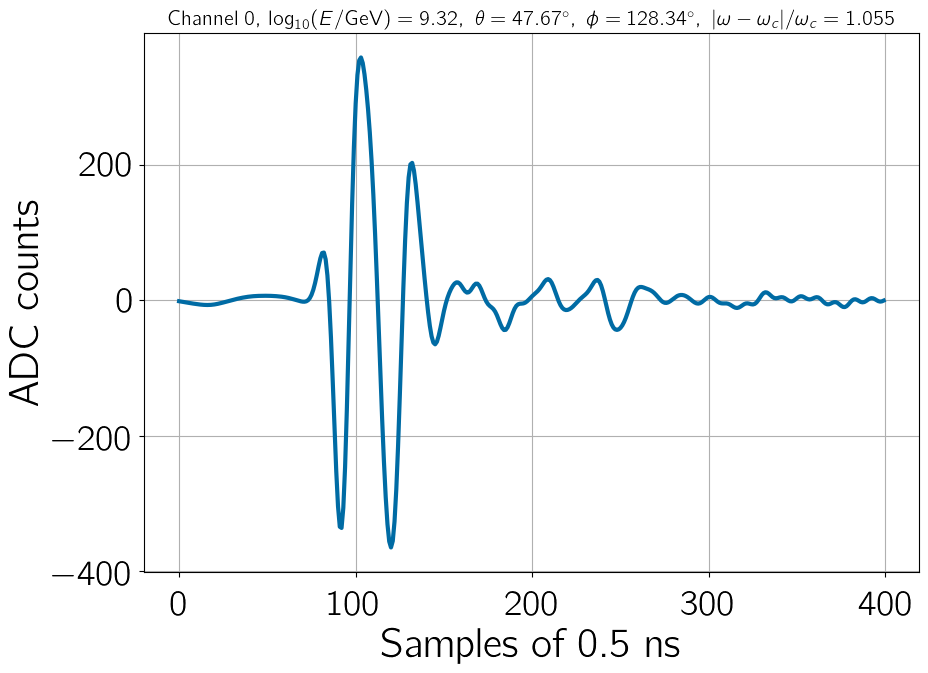

log10(E/GeV) = 9.13, theta = 45.42 deg, phi = 90.51 deg, omega = 2.330 deg, omega_c = 1.030 deg, |omega-omega_c|/omega_c = 1.261 
Vpp = [324. 257. 274.] ADC counts, pulse_width = [ 7.  7. 32.] ADC samples, n_peaks = [3. 3. 6.], peak_ratio = [1.17449664 1.08943089 1.140625  ], peak_dist = [3. 3. 5.] ADC samples


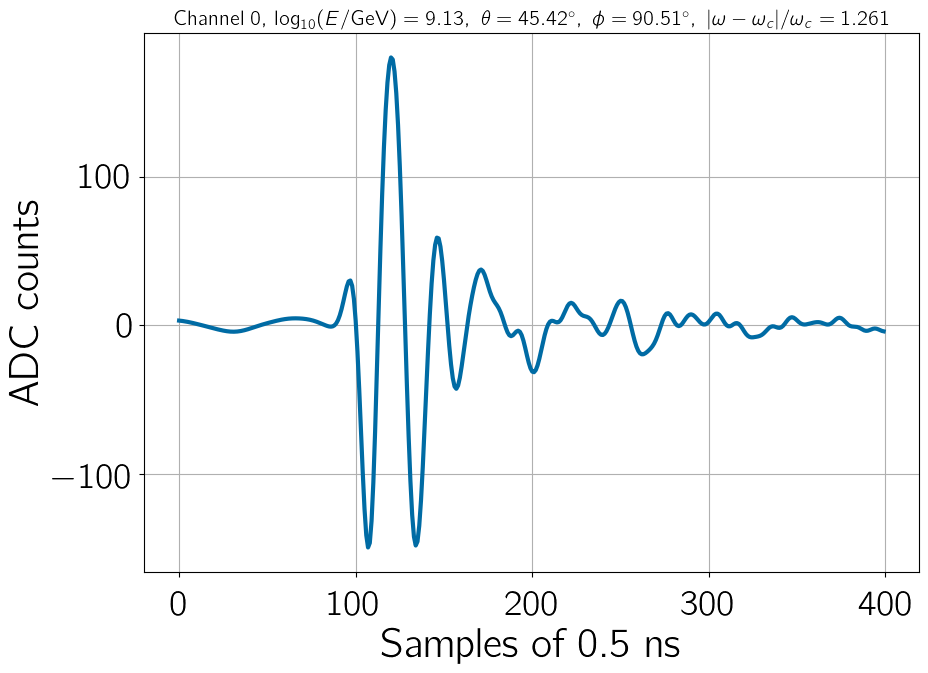

log10(E/GeV) = 9.55, theta = 46.86 deg, phi = 355.99 deg, omega = 2.700 deg, omega_c = 1.091 deg, |omega-omega_c|/omega_c = 1.475 
Vpp = [ 284. 1989.  169.] ADC counts, pulse_width = [ 3. 35. 24.] ADC samples, n_peaks = [ 2. 11.  3.], peak_ratio = [1.02857143 1.11595745 1.1875    ], peak_dist = [ 3.  3. 24.] ADC samples


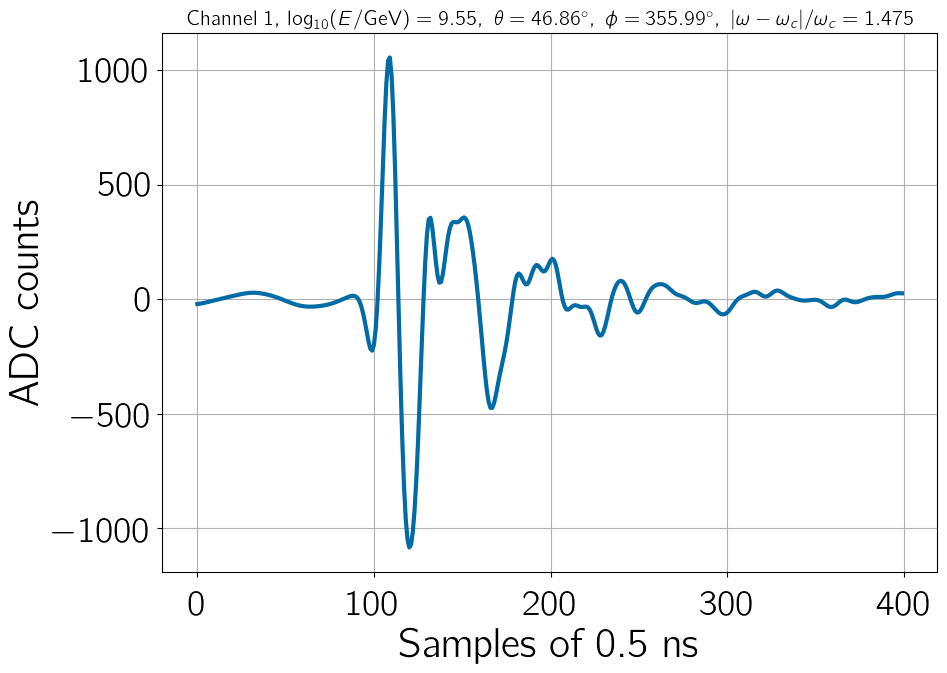

log10(E/GeV) = 9.49, theta = 43.38 deg, phi = 340.08 deg, omega = 2.808 deg, omega_c = 1.056 deg, |omega-omega_c|/omega_c = 1.660 
Vpp = [118. 636. 109.] ADC counts, pulse_width = [-1. 17. -1.] ADC samples, n_peaks = [0. 5. 0.], peak_ratio = [-1.         1.2633452 -1.       ], peak_dist = [-1.  4. -1.] ADC samples


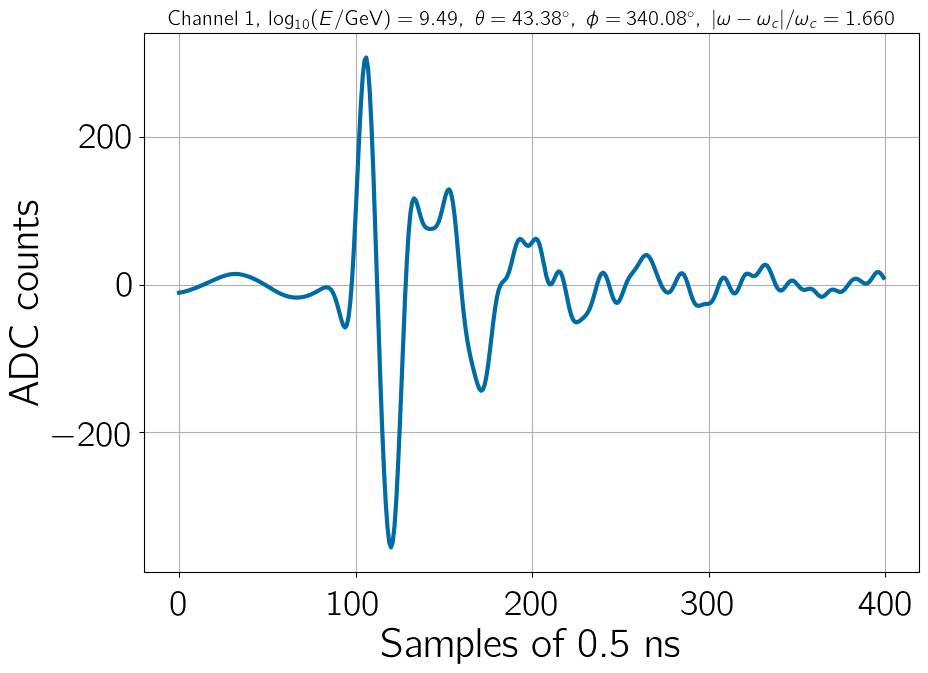

log10(E/GeV) = 9.44, theta = 43.72 deg, phi = 214.17 deg, omega = 3.038 deg, omega_c = 1.038 deg, |omega-omega_c|/omega_c = 1.928 
Vpp = [177.  89. 100.] ADC counts, pulse_width = [ 3. -1. -1.] ADC samples, n_peaks = [2. 0. 0.], peak_ratio = [ 1.2987013 -1.        -1.       ], peak_dist = [ 3. -1. -1.] ADC samples


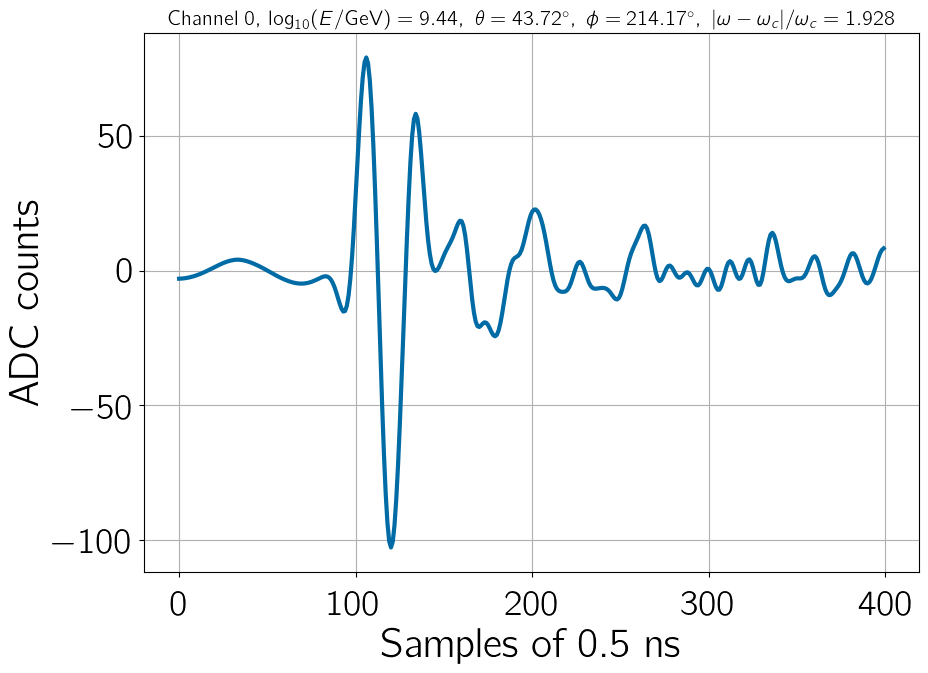

log10(E/GeV) = 9.44, theta = 51.65 deg, phi = 35.37 deg, omega = 0.991 deg, omega_c = 0.993 deg, |omega-omega_c|/omega_c = 0.002 
Vpp = [3596. 7331. 2233.] ADC counts, pulse_width = [49. 64. 61.] ADC samples, n_peaks = [13. 21. 20.], peak_ratio = [1.5594306  1.34817425 1.47835738], peak_dist = [3. 3. 5.] ADC samples


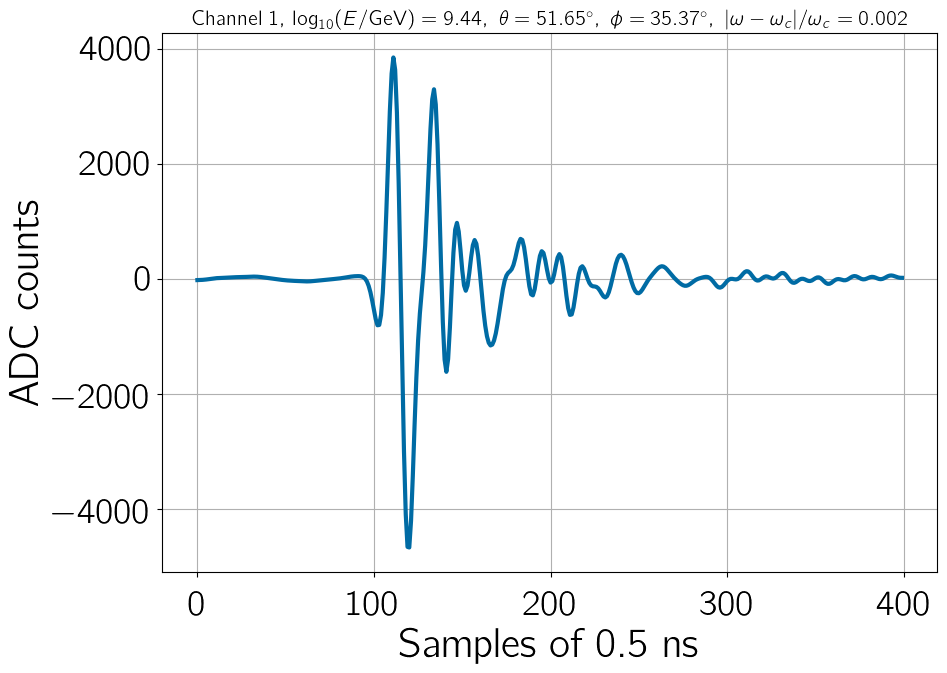

log10(E/GeV) = 9.28, theta = 48.07 deg, phi = 320.50 deg, omega = 0.773 deg, omega_c = 0.993 deg, |omega-omega_c|/omega_c = 0.222 
Vpp = [3233. 5636. 2508.] ADC counts, pulse_width = [40. 57. 59.] ADC samples, n_peaks = [14. 17. 19.], peak_ratio = [1.13822751 1.10377006 1.29460201], peak_dist = [4. 4. 5.] ADC samples


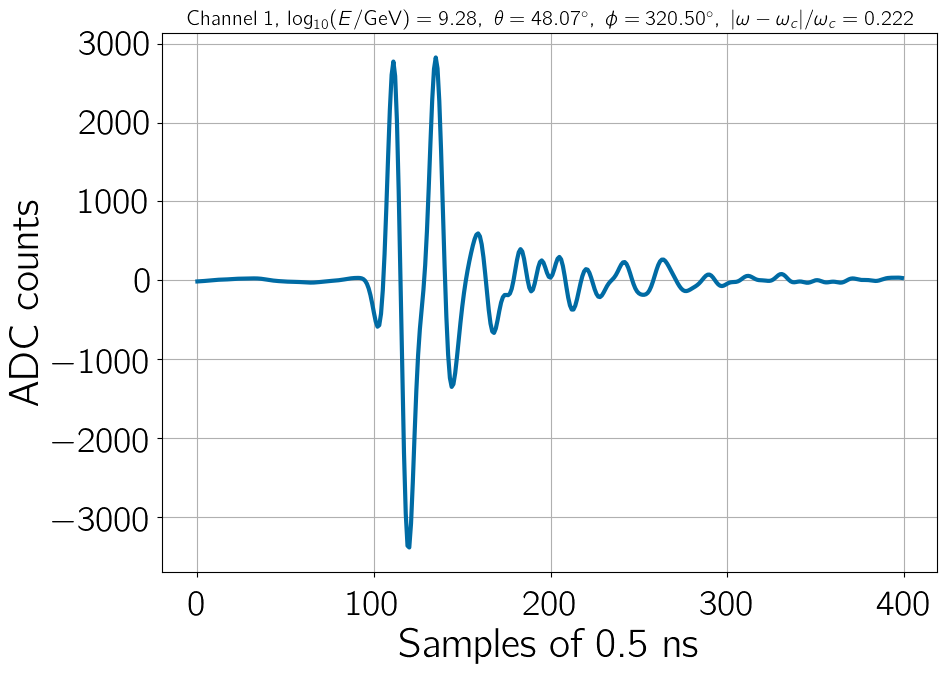

log10(E/GeV) = 9.21, theta = 51.87 deg, phi = 2.12 deg, omega = 1.540 deg, omega_c = 0.977 deg, |omega-omega_c|/omega_c = 0.577 
Vpp = [ 102. 1429.  450.] ADC counts, pulse_width = [-1. 20. 35.] ADC samples, n_peaks = [0. 6. 9.], peak_ratio = [-1.          1.00140056  1.01793722], peak_dist = [-1.  3.  2.] ADC samples


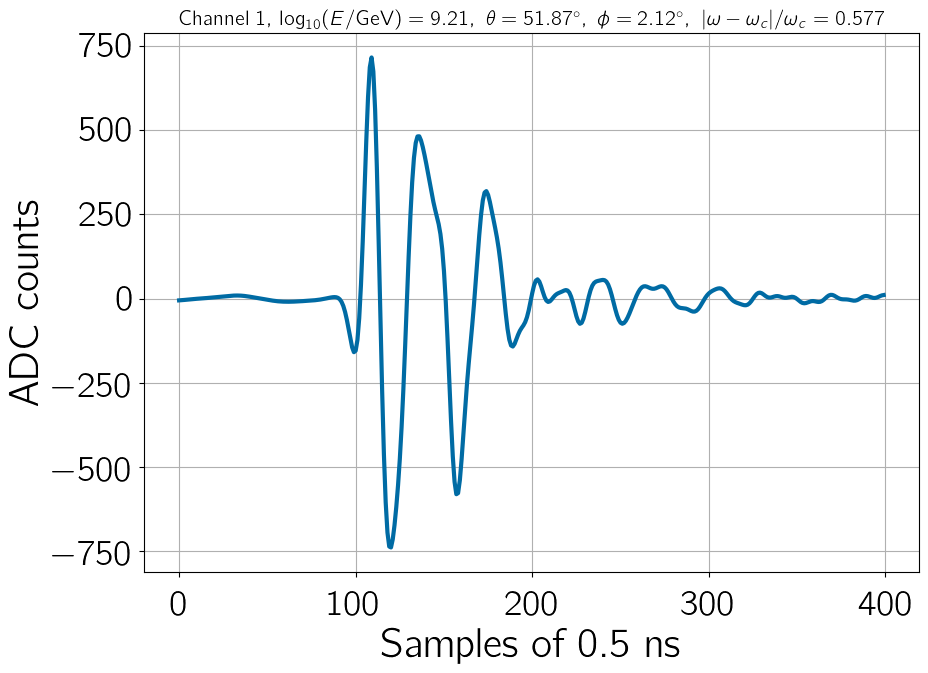

log10(E/GeV) = 9.28, theta = 48.82 deg, phi = 169.03 deg, omega = 1.668 deg, omega_c = 0.988 deg, |omega-omega_c|/omega_c = 0.688 
Vpp = [ 530. 1079.  294.] ADC counts, pulse_width = [ 9. 17. 32.] ADC samples, n_peaks = [4. 7. 6.], peak_ratio = [1.07843137 1.03969754 1.04166667], peak_dist = [4. 4. 5.] ADC samples


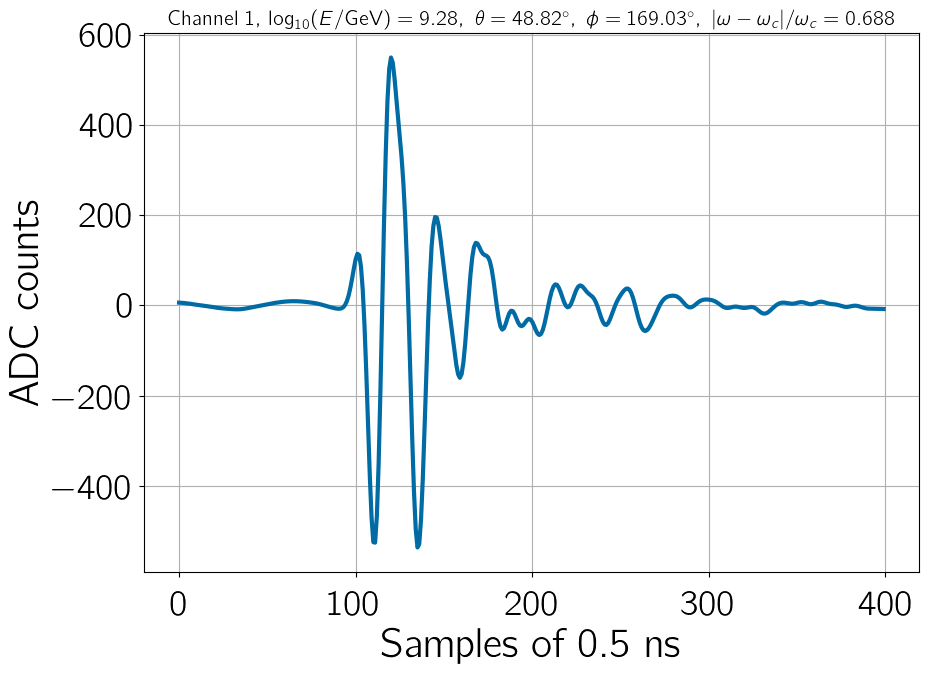

log10(E/GeV) = 9.45, theta = 51.12 deg, phi = 92.43 deg, omega = 1.867 deg, omega_c = 1.002 deg, |omega-omega_c|/omega_c = 0.863 
Vpp = [1428.  912.  967.] ADC counts, pulse_width = [26. 10. 53.] ADC samples, n_peaks = [ 8.  4. 10.], peak_ratio = [1.13772455 1.16627078 1.18243243], peak_dist = [ 3.  4. 13.] ADC samples


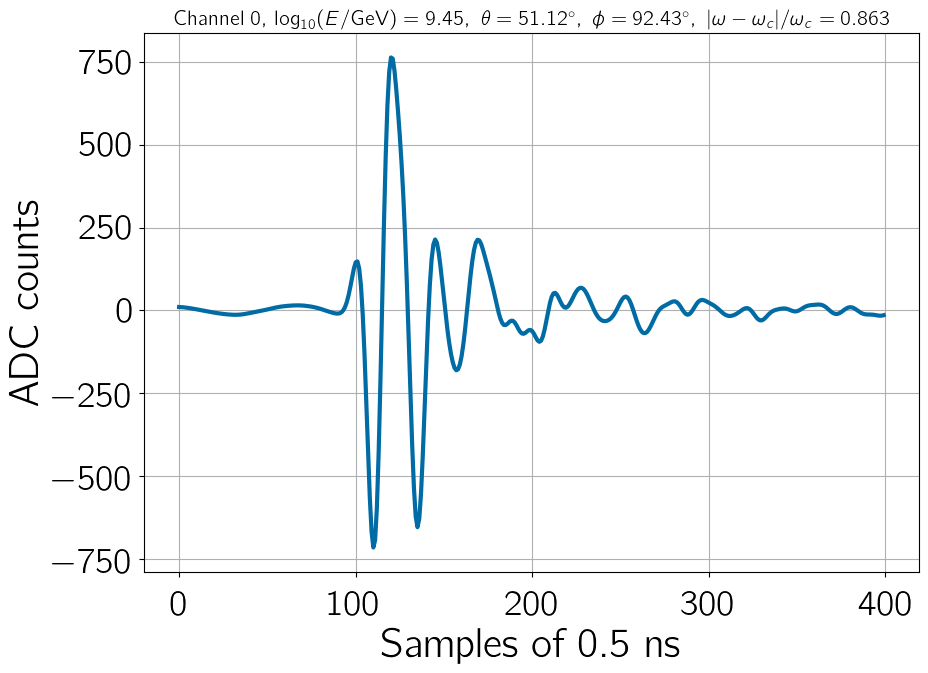

log10(E/GeV) = 9.45, theta = 51.12 deg, phi = 92.43 deg, omega = 2.032 deg, omega_c = 1.002 deg, |omega-omega_c|/omega_c = 1.028 
Vpp = [1167.  617.  627.] ADC counts, pulse_width = [26. 10. 47.] ADC samples, n_peaks = [8. 4. 9.], peak_ratio = [1.02253033 1.06354515 1.0557377 ], peak_dist = [4. 4. 5.] ADC samples


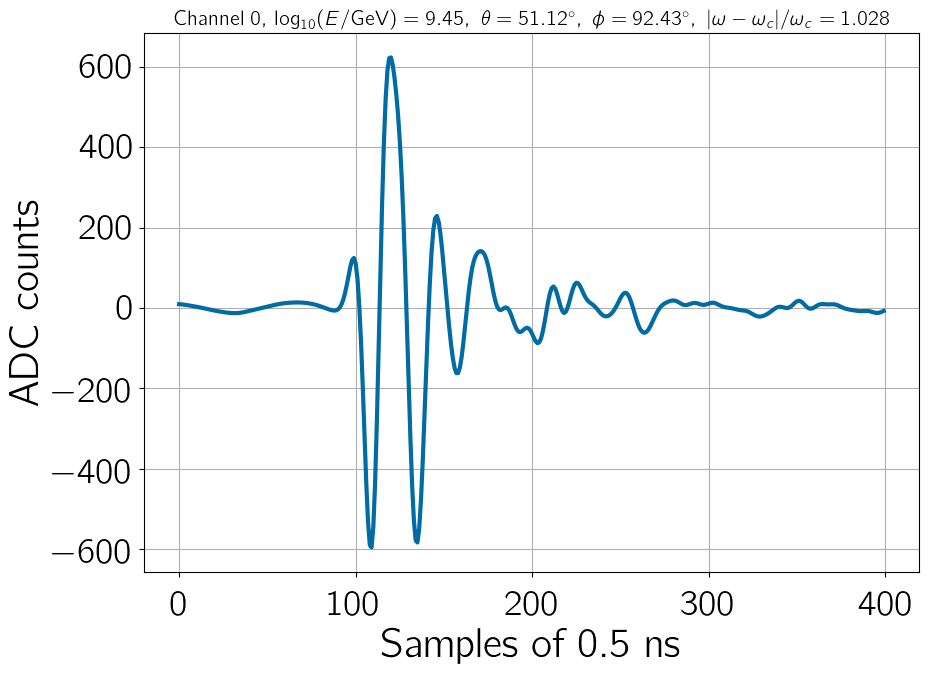

log10(E/GeV) = 9.27, theta = 51.73 deg, phi = 186.47 deg, omega = 2.210 deg, omega_c = 0.962 deg, |omega-omega_c|/omega_c = 1.298 
Vpp = [ 91. 261. 153.] ADC counts, pulse_width = [-1. 13.  0.] ADC samples, n_peaks = [0. 4. 1.], peak_ratio = [-1.          1.30701754  0.        ], peak_dist = [-1.  8.  0.] ADC samples


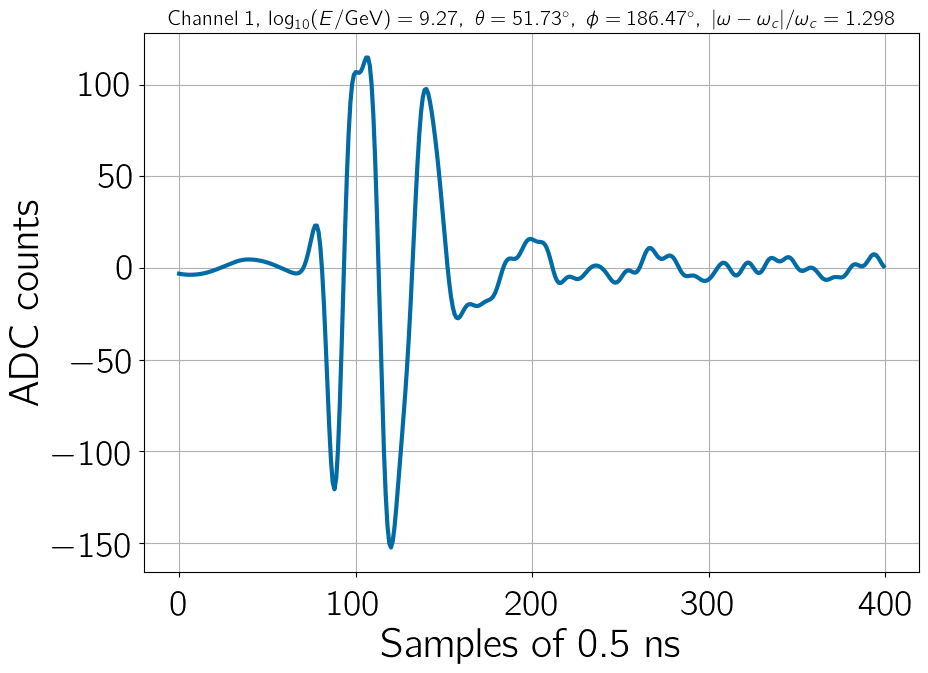

log10(E/GeV) = 9.26, theta = 48.72 deg, phi = 300.72 deg, omega = 2.578 deg, omega_c = 1.064 deg, |omega-omega_c|/omega_c = 1.422 
Vpp = [435. 763. 217.] ADC counts, pulse_width = [10. 11. 24.] ADC samples, n_peaks = [4. 4. 5.], peak_ratio = [1.02325581 1.06216216 1.02803738], peak_dist = [4. 4. 4.] ADC samples


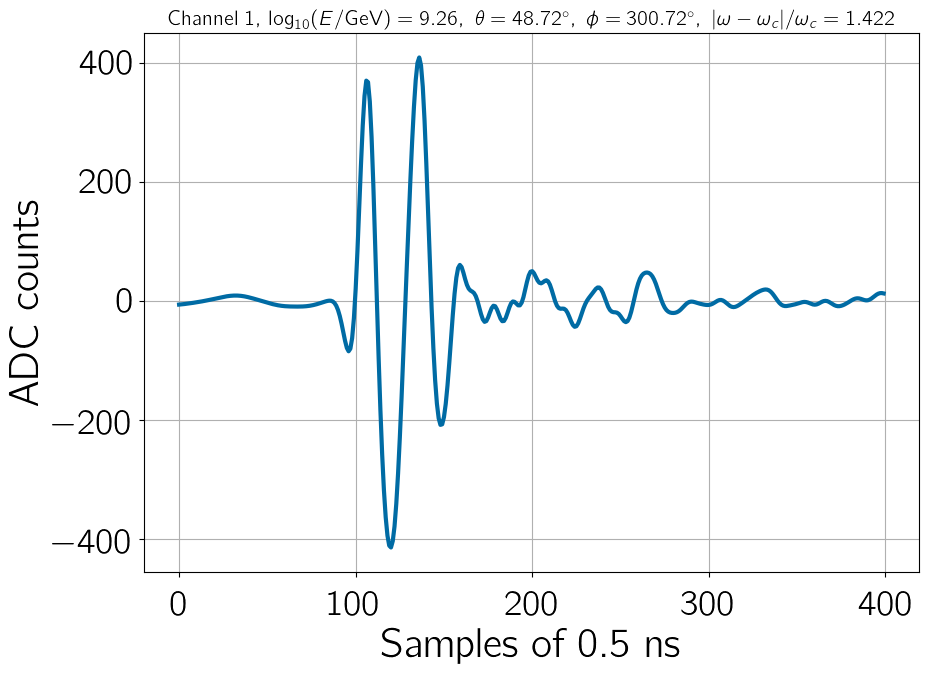

log10(E/GeV) = 9.57, theta = 52.52 deg, phi = 60.63 deg, omega = 2.585 deg, omega_c = 0.993 deg, |omega-omega_c|/omega_c = 1.603 
Vpp = [600. 692. 728.] ADC counts, pulse_width = [20. 15. 53.] ADC samples, n_peaks = [ 5.  4. 10.], peak_ratio = [1.07876712 1.06567164 1.01648352], peak_dist = [10.  3. 13.] ADC samples


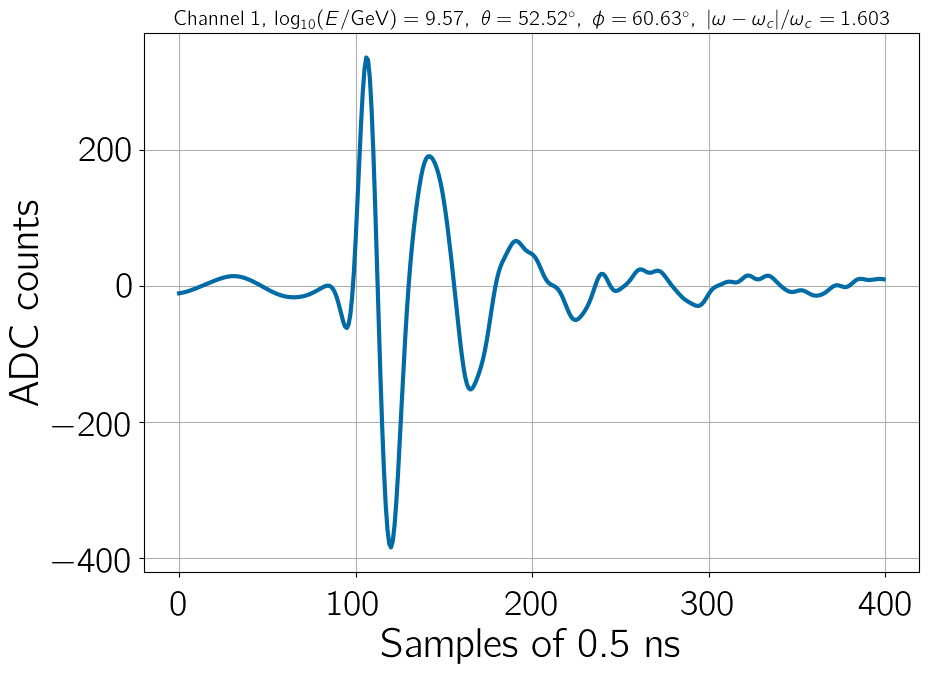

log10(E/GeV) = 9.45, theta = 51.12 deg, phi = 92.43 deg, omega = 2.845 deg, omega_c = 1.002 deg, |omega-omega_c|/omega_c = 1.840 
Vpp = [147.  66. 179.] ADC counts, pulse_width = [ 0. -1. 13.] ADC samples, n_peaks = [1. 0. 3.], peak_ratio = [ 0.         -1.          1.01098901], peak_dist = [ 0. -1. 13.] ADC samples


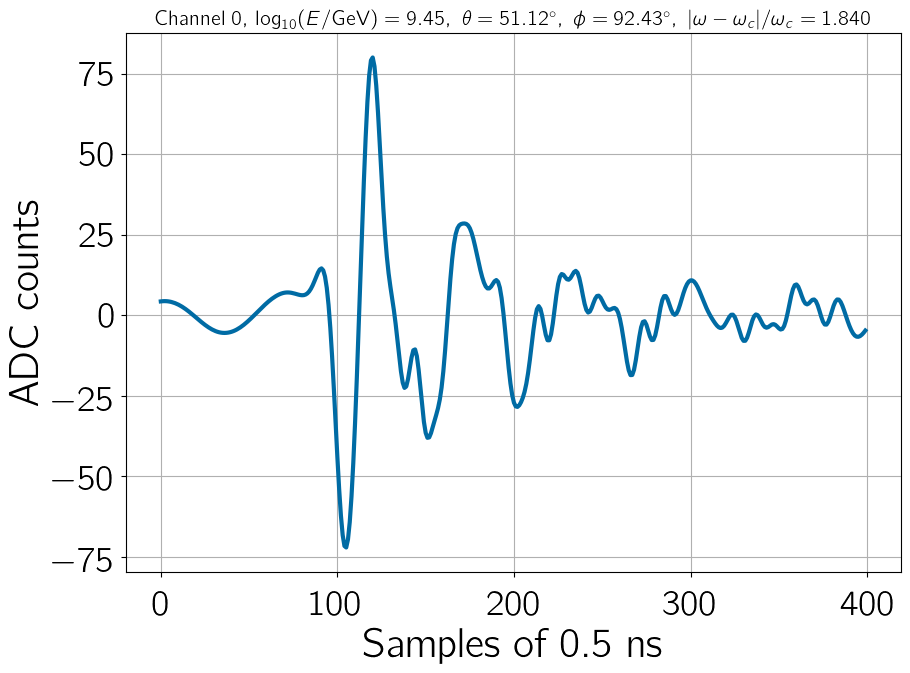

log10(E/GeV) = 9.53, theta = 56.18 deg, phi = 236.77 deg, omega = 1.000 deg, omega_c = 0.992 deg, |omega-omega_c|/omega_c = 0.008 
Vpp = [7121. 2341. 3993.] ADC counts, pulse_width = [52. 36. 65.] ADC samples, n_peaks = [17. 12. 19.], peak_ratio = [1.27217613 1.05350877 1.51606805], peak_dist = [2. 2. 6.] ADC samples


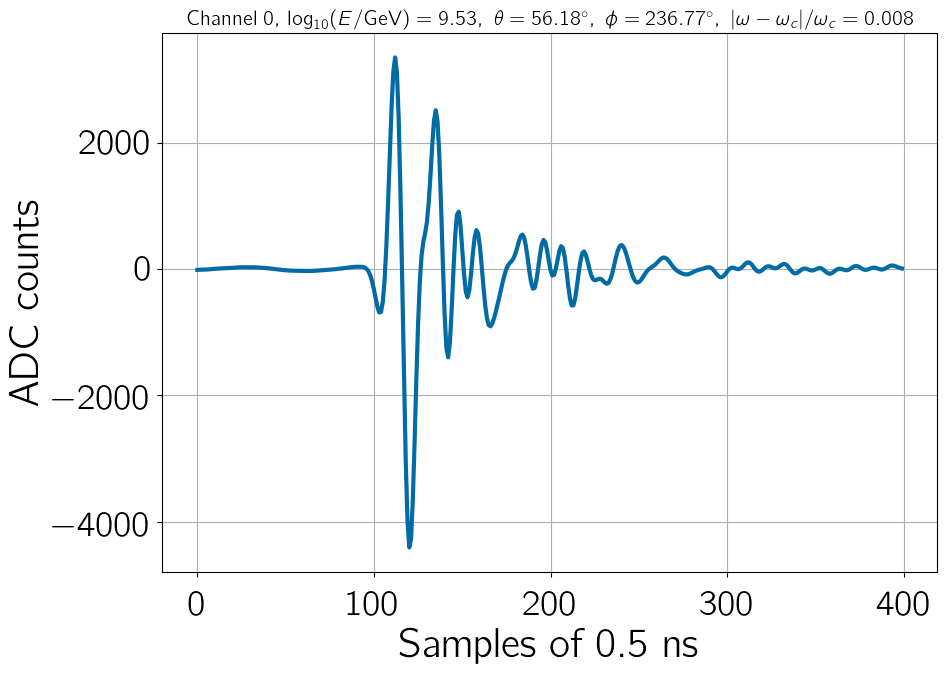

log10(E/GeV) = 9.35, theta = 53.91 deg, phi = 123.91 deg, omega = 0.581 deg, omega_c = 0.957 deg, |omega-omega_c|/omega_c = 0.393 
Vpp = [4473. 1768. 3319.] ADC counts, pulse_width = [44. 34. 68.] ADC samples, n_peaks = [15. 11. 21.], peak_ratio = [1.33821223 1.36048064 1.31289199], peak_dist = [3. 2. 5.] ADC samples


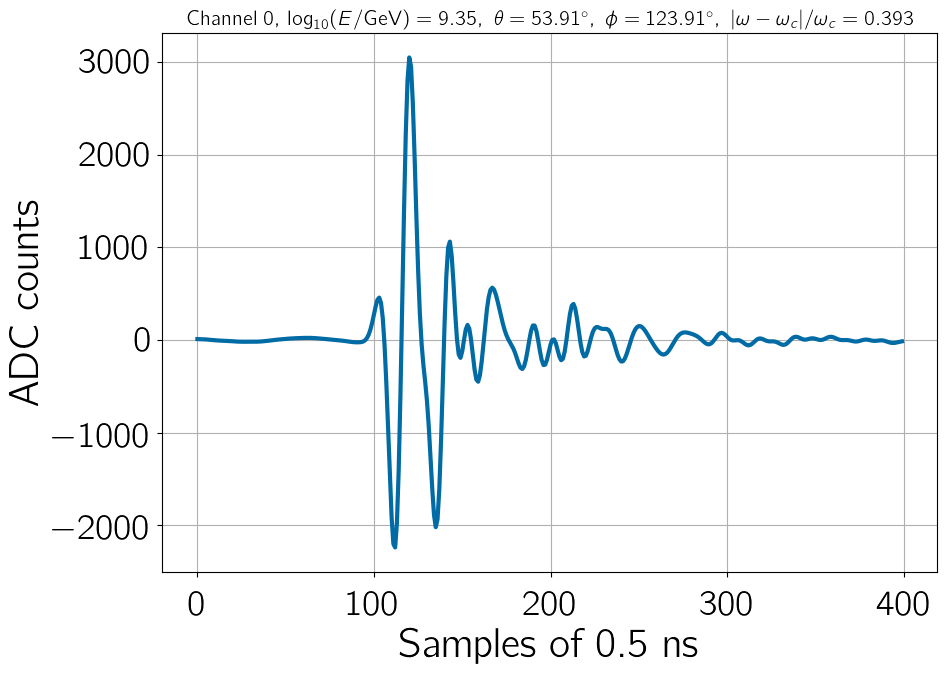

log10(E/GeV) = 9.04, theta = 57.76 deg, phi = 195.04 deg, omega = 1.280 deg, omega_c = 0.882 deg, |omega-omega_c|/omega_c = 0.452 
Vpp = [ 81. 659. 162.] ADC counts, pulse_width = [-1. 17.  0.] ADC samples, n_peaks = [0. 6. 1.], peak_ratio = [-1.          1.10543131  0.        ], peak_dist = [-1.  5.  0.] ADC samples


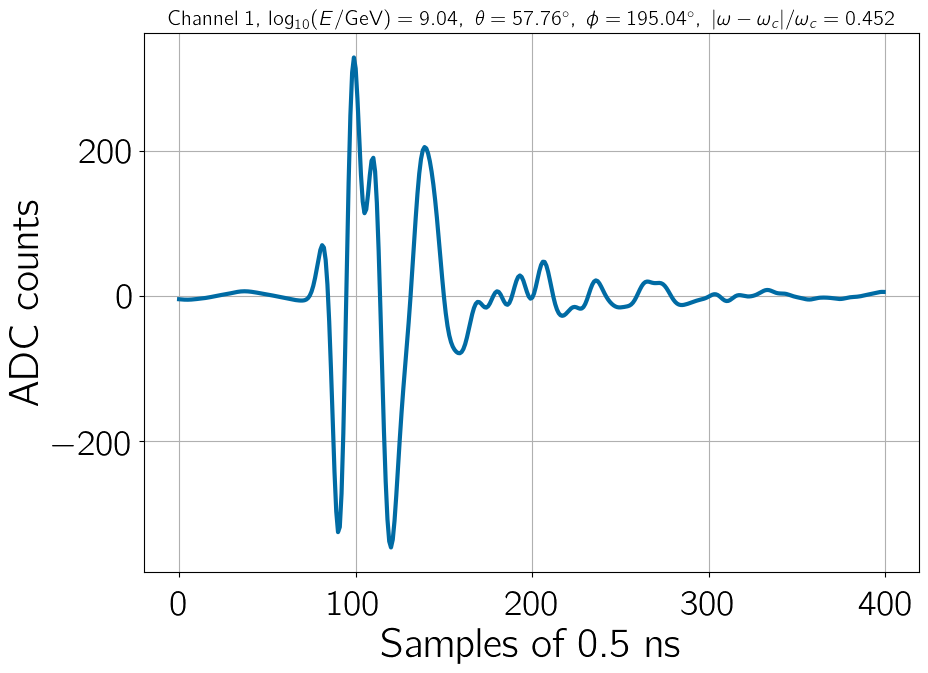

log10(E/GeV) = 9.33, theta = 56.90 deg, phi = 317.56 deg, omega = 1.483 deg, omega_c = 0.913 deg, |omega-omega_c|/omega_c = 0.625 
Vpp = [ 196. 2031.  132.] ADC counts, pulse_width = [ 2. 35. -1.] ADC samples, n_peaks = [ 2. 11.  0.], peak_ratio = [ 1.17777778  1.11122661 -1.        ], peak_dist = [ 2.  2. -1.] ADC samples


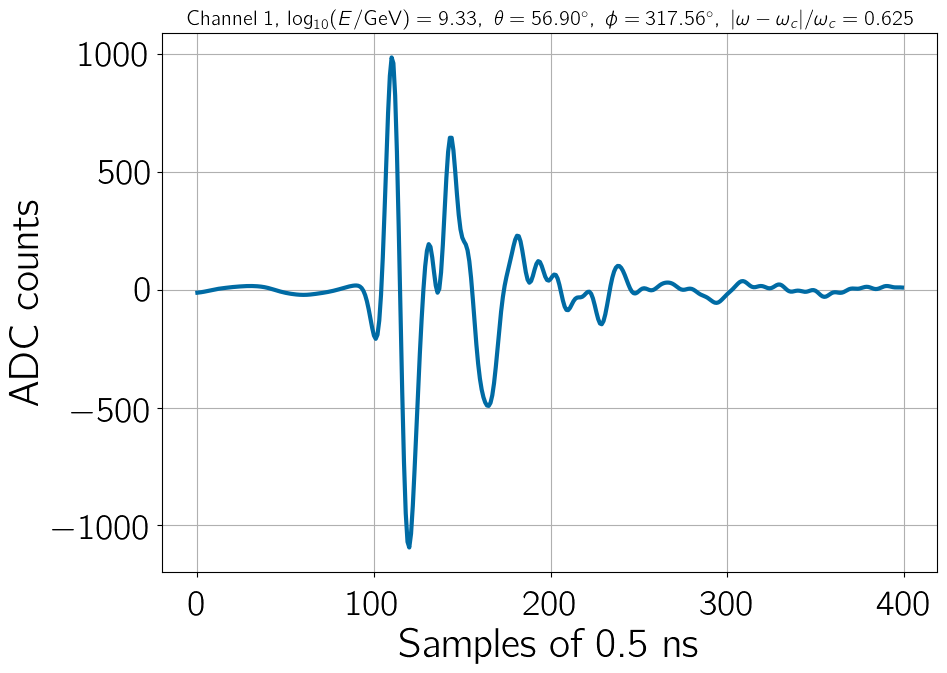

log10(E/GeV) = 9.49, theta = 58.35 deg, phi = 104.94 deg, omega = 1.776 deg, omega_c = 0.888 deg, |omega-omega_c|/omega_c = 0.999 
Vpp = [ 712.  322. 1088.] ADC counts, pulse_width = [16.  8. 53.] ADC samples, n_peaks = [ 4.  3. 10.], peak_ratio = [1.30420712 1.22068966 1.08719852], peak_dist = [ 4.  4. 13.] ADC samples


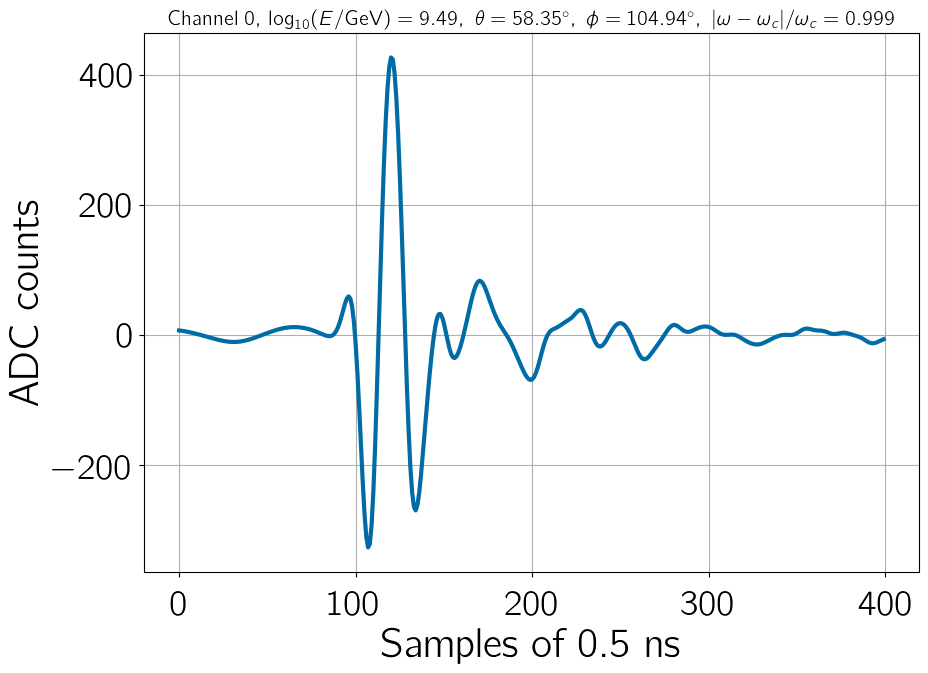

log10(E/GeV) = 9.16, theta = 58.65 deg, phi = 298.30 deg, omega = 2.024 deg, omega_c = 0.956 deg, |omega-omega_c|/omega_c = 1.118 
Vpp = [114. 332.  56.] ADC counts, pulse_width = [-1.  7. -1.] ADC samples, n_peaks = [0. 3. 0.], peak_ratio = [-1.          1.18421053 -1.        ], peak_dist = [-1.  4. -1.] ADC samples


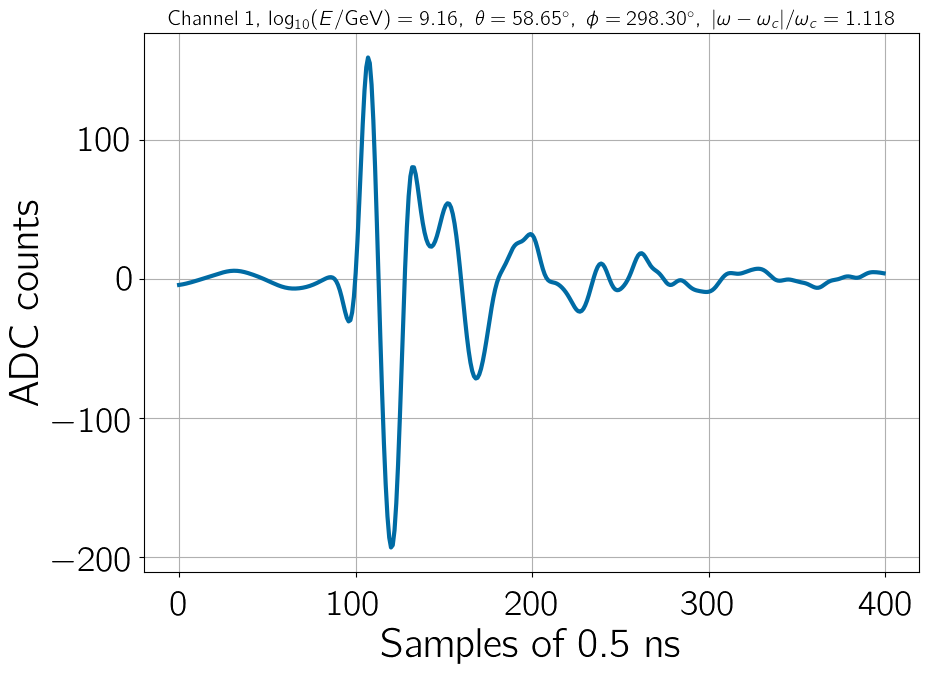

log10(E/GeV) = 9.39, theta = 55.73 deg, phi = 117.26 deg, omega = 2.163 deg, omega_c = 0.944 deg, |omega-omega_c|/omega_c = 1.290 
Vpp = [402. 133. 419.] ADC counts, pulse_width = [15. -1. 39.] ADC samples, n_peaks = [4. 0. 7.], peak_ratio = [ 1.19672131 -1.          1.06896552], peak_dist = [ 3. -1. 13.] ADC samples


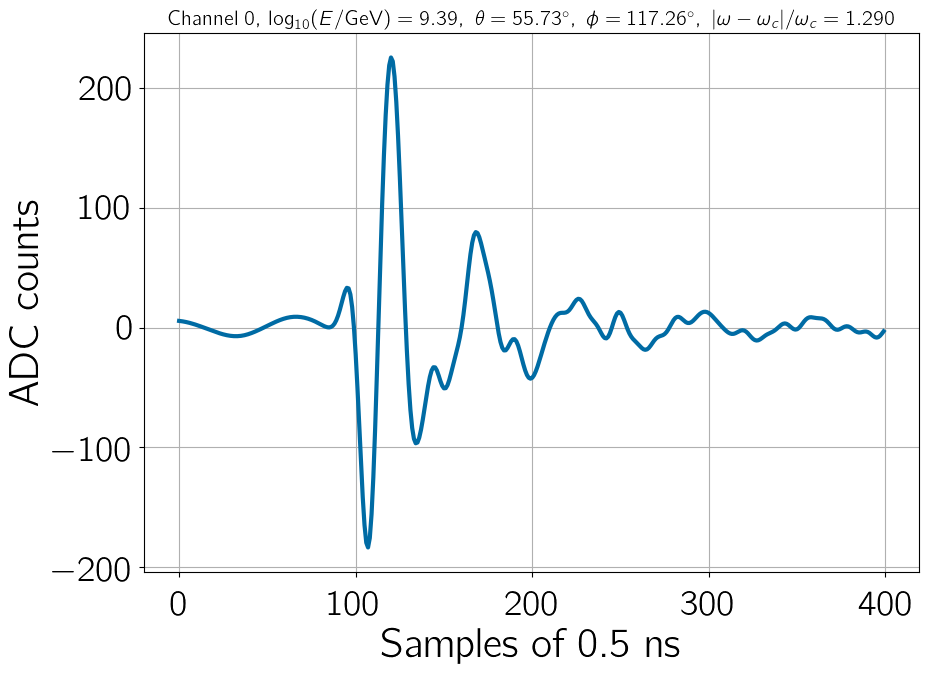

log10(E/GeV) = 9.24, theta = 54.09 deg, phi = 238.06 deg, omega = 2.562 deg, omega_c = 0.994 deg, |omega-omega_c|/omega_c = 1.578 
Vpp = [282.  25. 144.] ADC counts, pulse_width = [13. -1. -1.] ADC samples, n_peaks = [4. 0. 0.], peak_ratio = [ 1.04347826 -1.         -1.        ], peak_dist = [ 4. -1. -1.] ADC samples


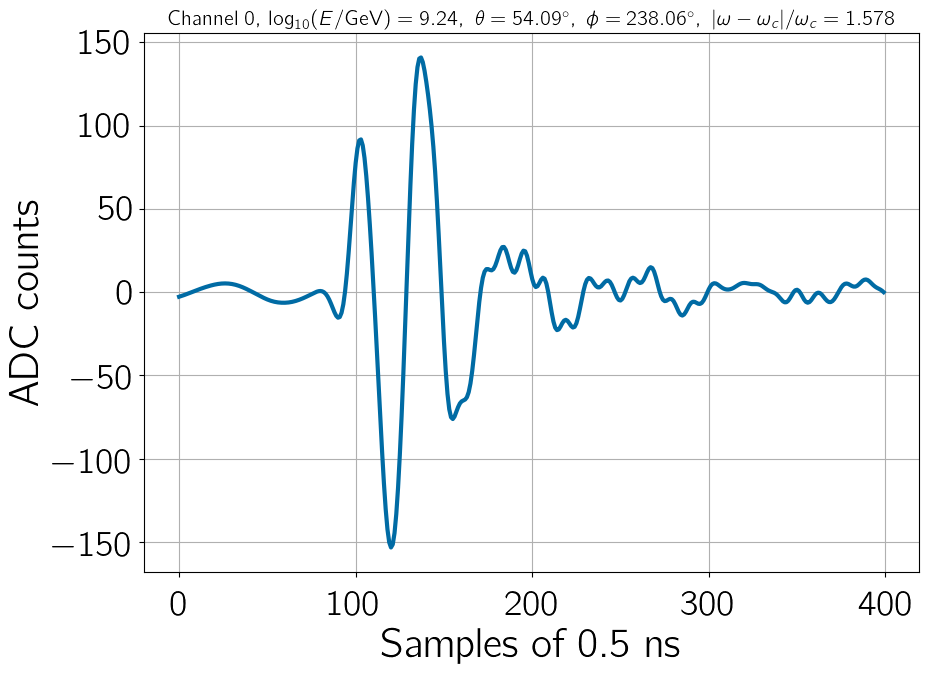

log10(E/GeV) = 9.41, theta = 54.28 deg, phi = 197.40 deg, omega = 2.631 deg, omega_c = 0.969 deg, |omega-omega_c|/omega_c = 1.714 
Vpp = [136. 191. 145.] ADC counts, pulse_width = [-1.  3. -1.] ADC samples, n_peaks = [0. 2. 0.], peak_ratio = [-1.          1.30120482 -1.        ], peak_dist = [-1.  3. -1.] ADC samples


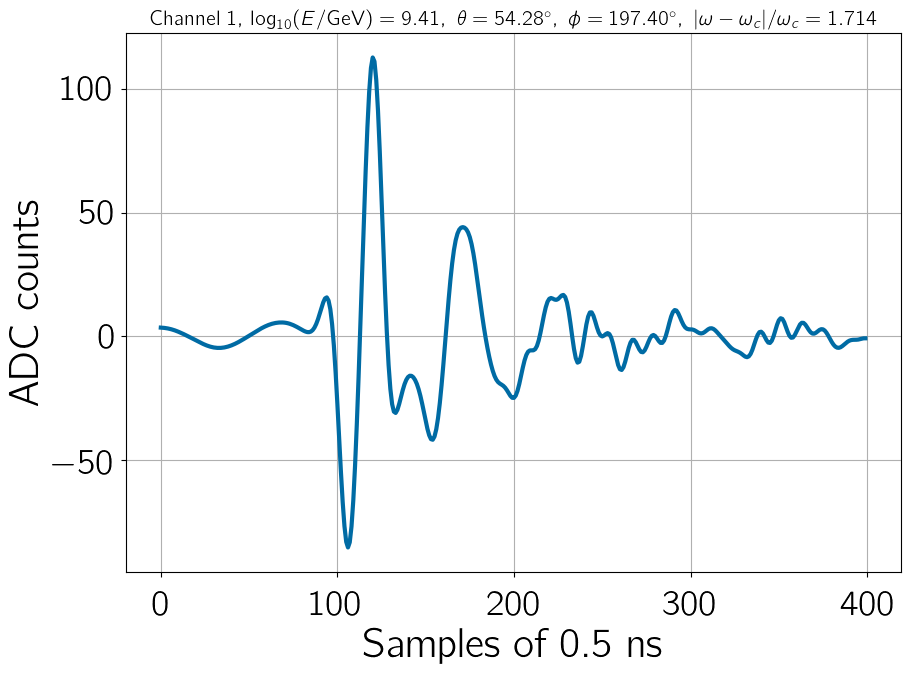

log10(E/GeV) = 9.46, theta = 55.80 deg, phi = 21.77 deg, omega = 2.785 deg, omega_c = 0.961 deg, |omega-omega_c|/omega_c = 1.899 
Vpp = [ 69. 184.  53.] ADC counts, pulse_width = [-1. 10. -1.] ADC samples, n_peaks = [0. 3. 0.], peak_ratio = [-1.          1.09090909 -1.        ], peak_dist = [-1.  6. -1.] ADC samples


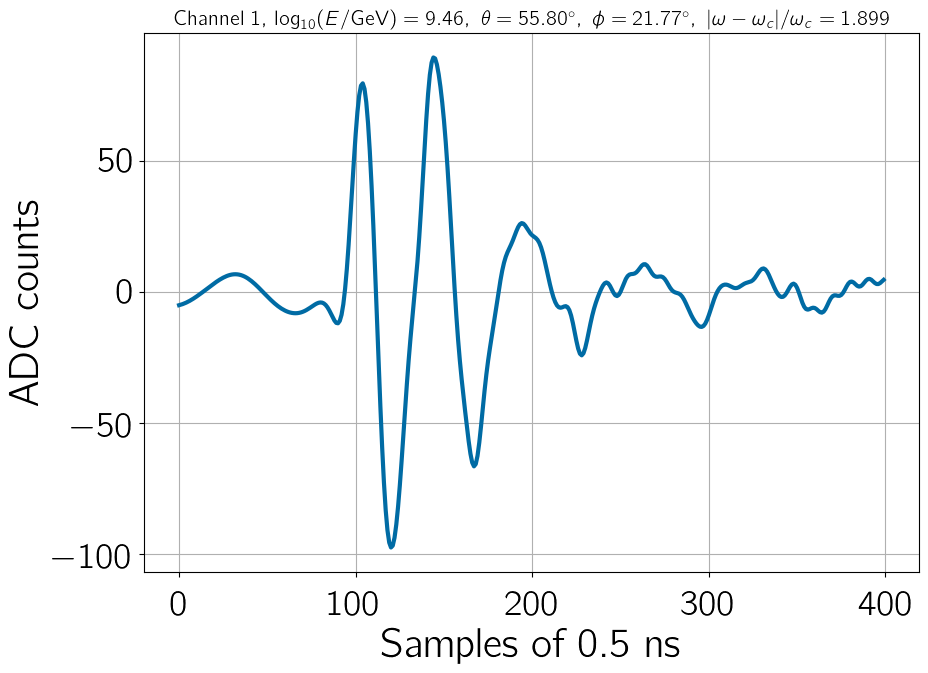

log10(E/GeV) = 9.37, theta = 59.81 deg, phi = 163.50 deg, omega = 0.812 deg, omega_c = 0.876 deg, |omega-omega_c|/omega_c = 0.073 
Vpp = [2324. 3054.   75.] ADC counts, pulse_width = [34. 34. -1.] ADC samples, n_peaks = [11. 12.  0.], peak_ratio = [ 1.30327056  1.25055269 -1.        ], peak_dist = [ 2.  2. -1.] ADC samples


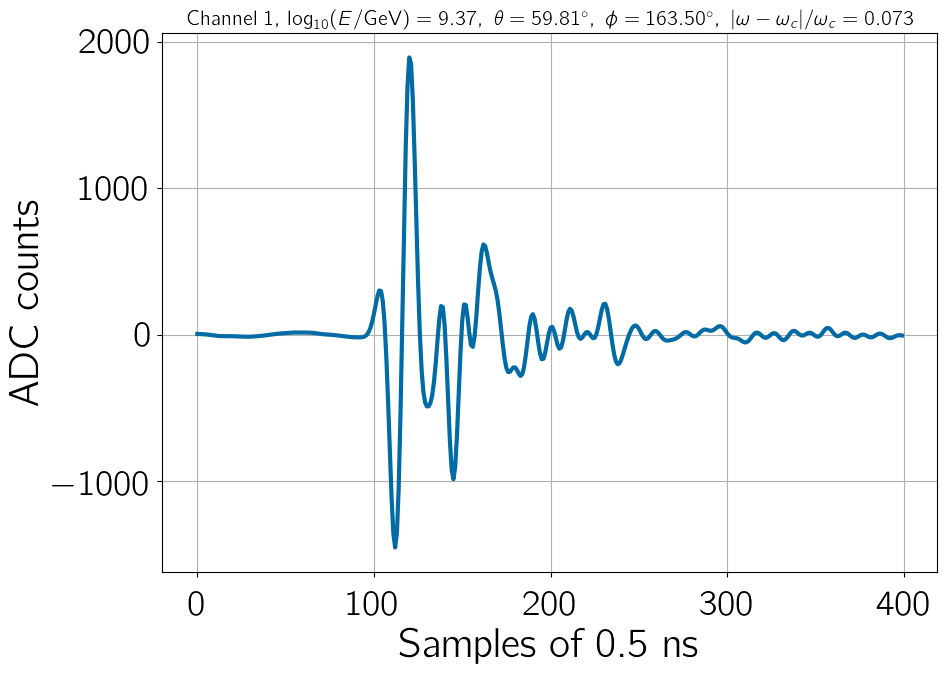

log10(E/GeV) = 9.12, theta = 63.79 deg, phi = 127.48 deg, omega = 0.591 deg, omega_c = 0.823 deg, |omega-omega_c|/omega_c = 0.281 
Vpp = [2078. 1171. 1099.] ADC counts, pulse_width = [34. 18. 53.] ADC samples, n_peaks = [ 9.  7. 16.], peak_ratio = [1.27601314 1.58498896 2.0698324 ], peak_dist = [ 2.  2. 19.] ADC samples


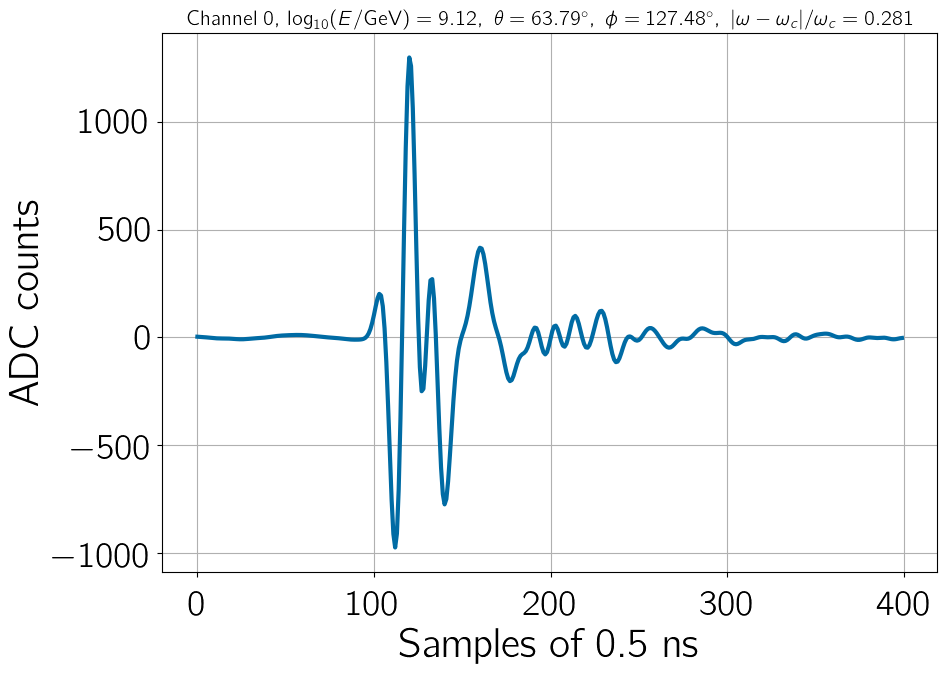

log10(E/GeV) = 9.39, theta = 64.01 deg, phi = 20.27 deg, omega = 1.365 deg, omega_c = 0.869 deg, |omega-omega_c|/omega_c = 0.571 
Vpp = [2529. 3146. 1105.] ADC counts, pulse_width = [34. 39. 53.] ADC samples, n_peaks = [11. 10. 16.], peak_ratio = [1.18393782 1.22489392 1.54371002], peak_dist = [ 5.  2. 14.] ADC samples


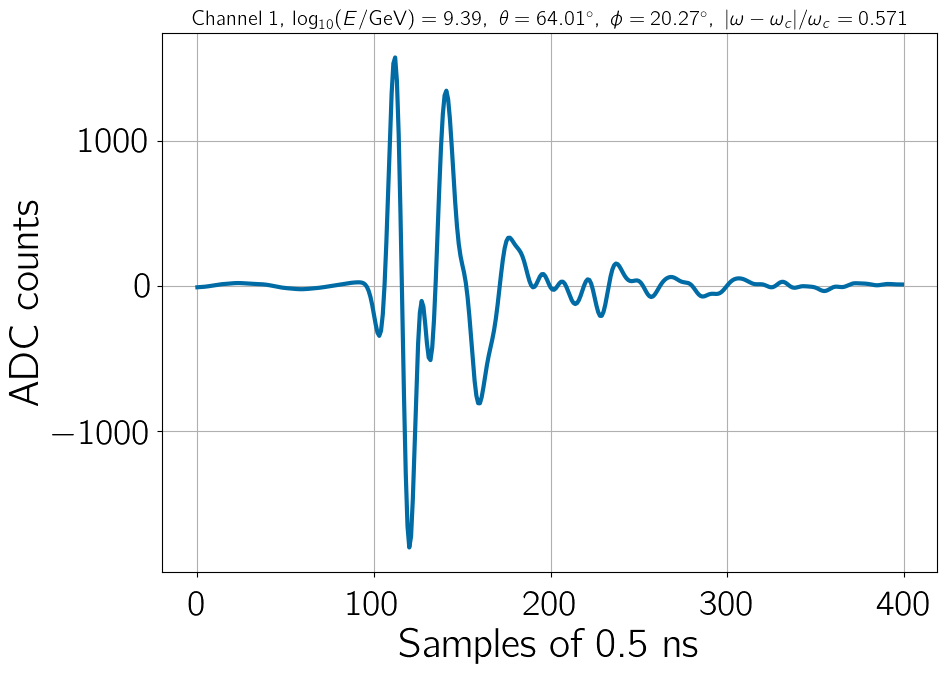

log10(E/GeV) = 9.01, theta = 61.91 deg, phi = 78.17 deg, omega = 1.499 deg, omega_c = 0.855 deg, |omega-omega_c|/omega_c = 0.754 
Vpp = [577. 711. 278.] ADC counts, pulse_width = [14. 14. 25.] ADC samples, n_peaks = [6. 4. 5.], peak_ratio = [1.40416667 1.35430464 1.20634921], peak_dist = [2. 2. 6.] ADC samples


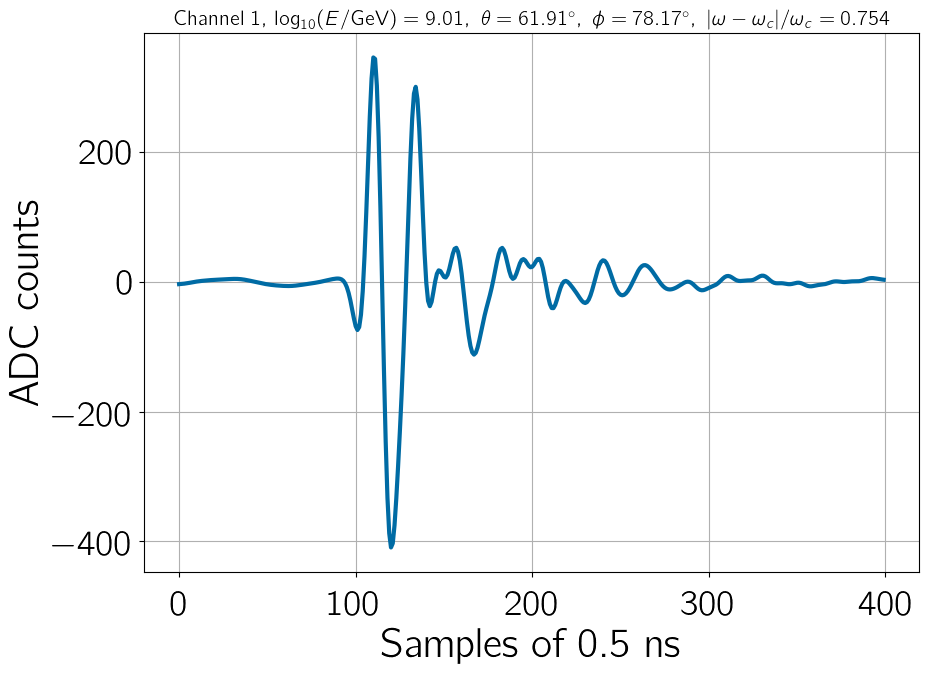

log10(E/GeV) = 9.32, theta = 61.18 deg, phi = 263.82 deg, omega = 1.766 deg, omega_c = 0.891 deg, |omega-omega_c|/omega_c = 0.983 
Vpp = [756. 378. 289.] ADC counts, pulse_width = [18. 14. 34.] ADC samples, n_peaks = [5. 4. 6.], peak_ratio = [1.07123288 1.03225806 1.02097902], peak_dist = [4. 5. 6.] ADC samples


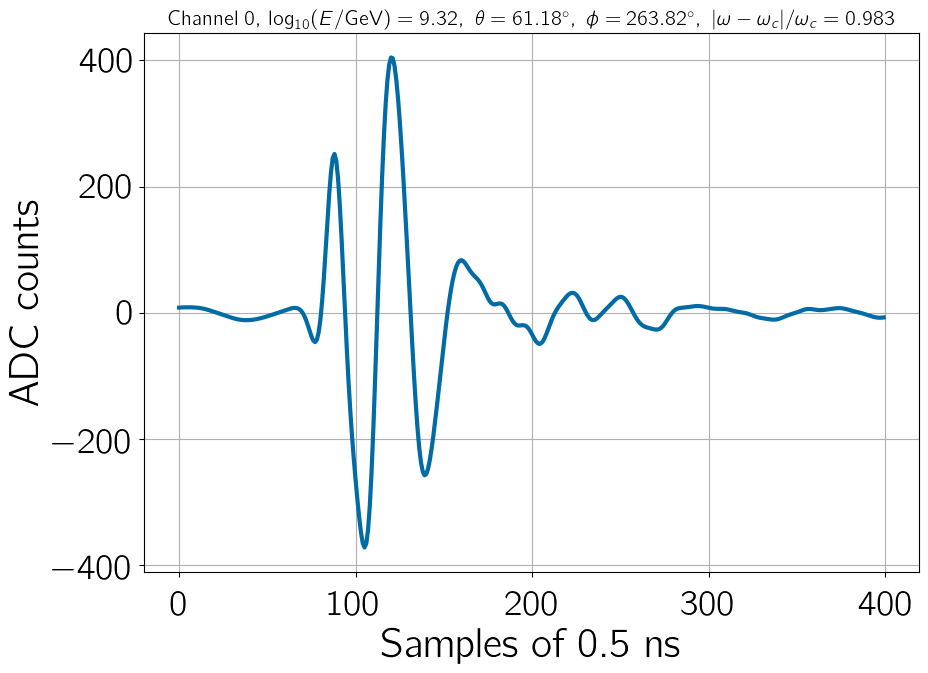

log10(E/GeV) = 9.39, theta = 63.86 deg, phi = 274.82 deg, omega = 1.784 deg, omega_c = 0.862 deg, |omega-omega_c|/omega_c = 1.070 
Vpp = [513. 144. 438.] ADC counts, pulse_width = [14.  0. 43.] ADC samples, n_peaks = [4. 1. 8.], peak_ratio = [1.09387755 0.         1.        ], peak_dist = [5. 0. 7.] ADC samples


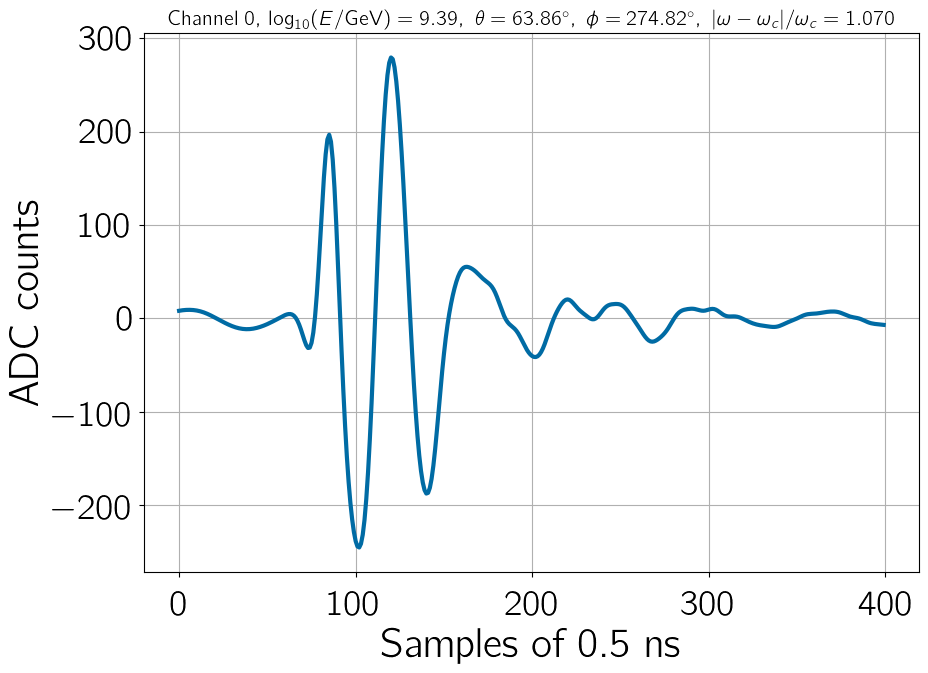

log10(E/GeV) = 9.39, theta = 64.35 deg, phi = 209.15 deg, omega = 2.148 deg, omega_c = 0.902 deg, |omega-omega_c|/omega_c = 1.382 
Vpp = [287. 192. 114.] ADC counts, pulse_width = [14.  4. -1.] ADC samples, n_peaks = [4. 2. 0.], peak_ratio = [ 1.05        1.18181818 -1.        ], peak_dist = [ 5.  4. -1.] ADC samples


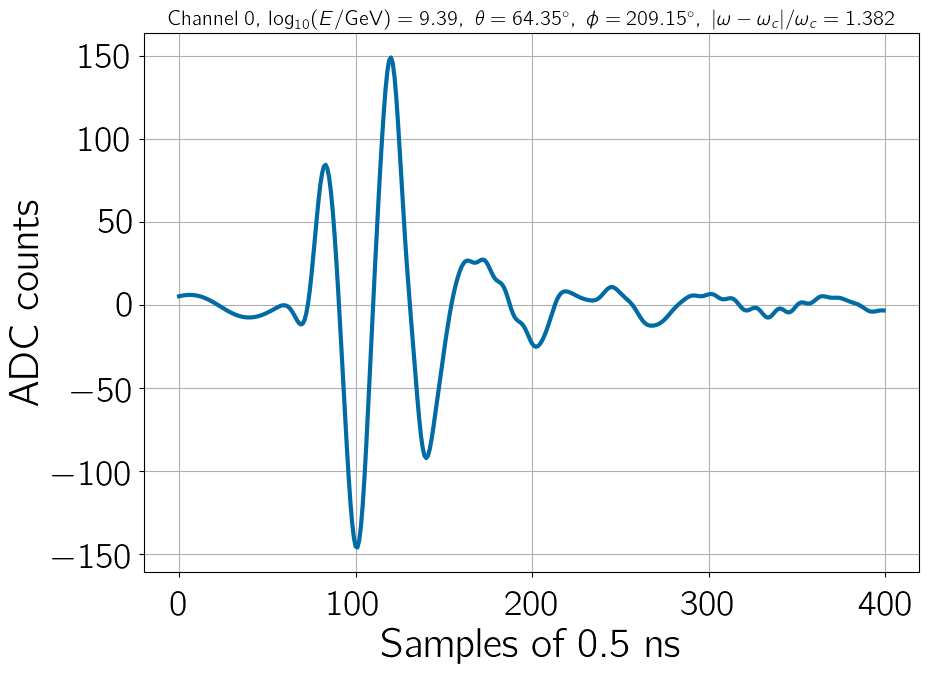

log10(E/GeV) = 9.14, theta = 64.11 deg, phi = 228.11 deg, omega = 2.118 deg, omega_c = 0.872 deg, |omega-omega_c|/omega_c = 1.429 
Vpp = [180. 148. 207.] ADC counts, pulse_width = [ 9.  0. 26.] ADC samples, n_peaks = [3. 1. 5.], peak_ratio = [1.11764706 0.         1.02941176], peak_dist = [5. 0. 7.] ADC samples


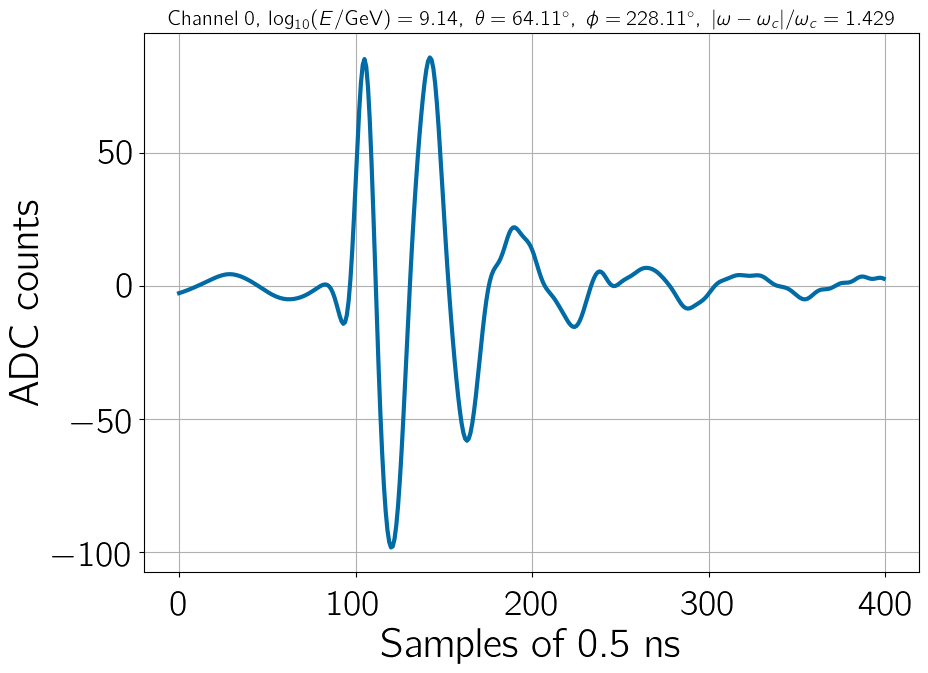

log10(E/GeV) = 9.55, theta = 60.71 deg, phi = 300.27 deg, omega = 2.282 deg, omega_c = 0.876 deg, |omega-omega_c|/omega_c = 1.605 
Vpp = [223. 152. 243.] ADC counts, pulse_width = [10.  0. 32.] ADC samples, n_peaks = [3. 1. 6.], peak_ratio = [1.08411215 0.         1.04201681], peak_dist = [5. 0. 7.] ADC samples


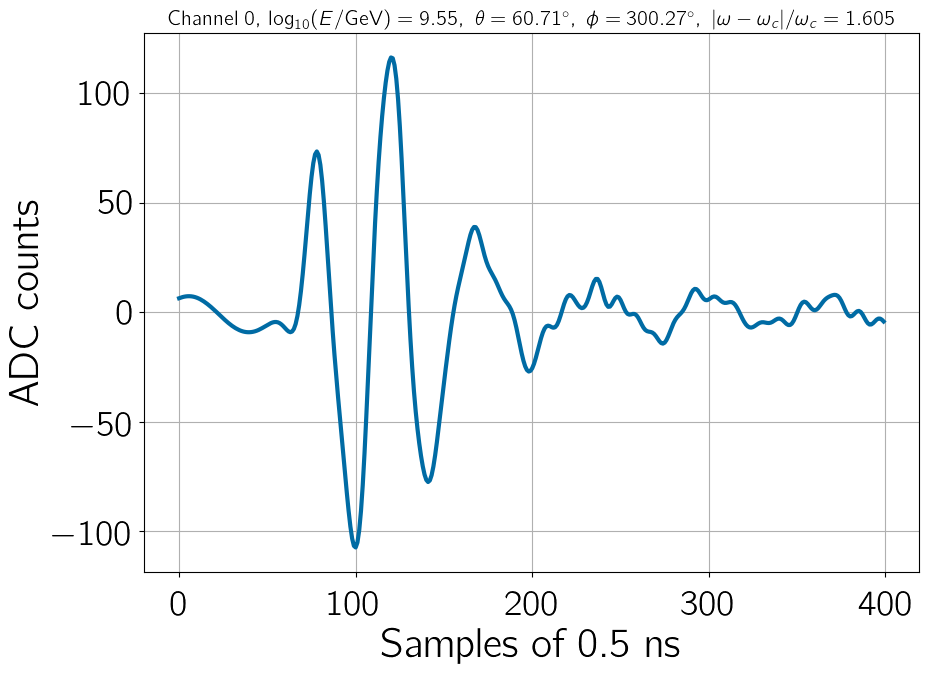

log10(E/GeV) = 9.58, theta = 60.32 deg, phi = 339.13 deg, omega = 2.436 deg, omega_c = 0.862 deg, |omega-omega_c|/omega_c = 1.825 
Vpp = [ 94. 285. 208.] ADC counts, pulse_width = [-1. 16. 26.] ADC samples, n_peaks = [0. 4. 5.], peak_ratio = [-1.          1.20930233  1.08      ], peak_dist = [-1.  4.  6.] ADC samples


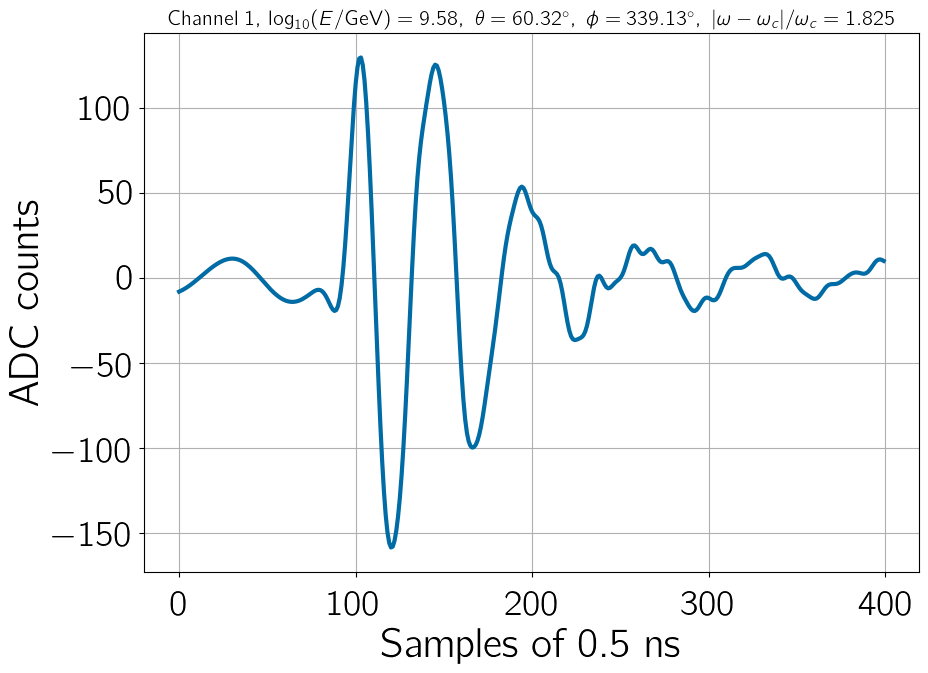

log10(E/GeV) = 9.35, theta = 69.35 deg, phi = 3.10 deg, omega = 0.837 deg, omega_c = 0.781 deg, |omega-omega_c|/omega_c = 0.072 
Vpp = [1078. 3633.  616.] ADC counts, pulse_width = [18. 46. 37.] ADC samples, n_peaks = [ 7. 16. 12.], peak_ratio = [1.51869159 1.39328063 1.56666667], peak_dist = [2. 4. 5.] ADC samples


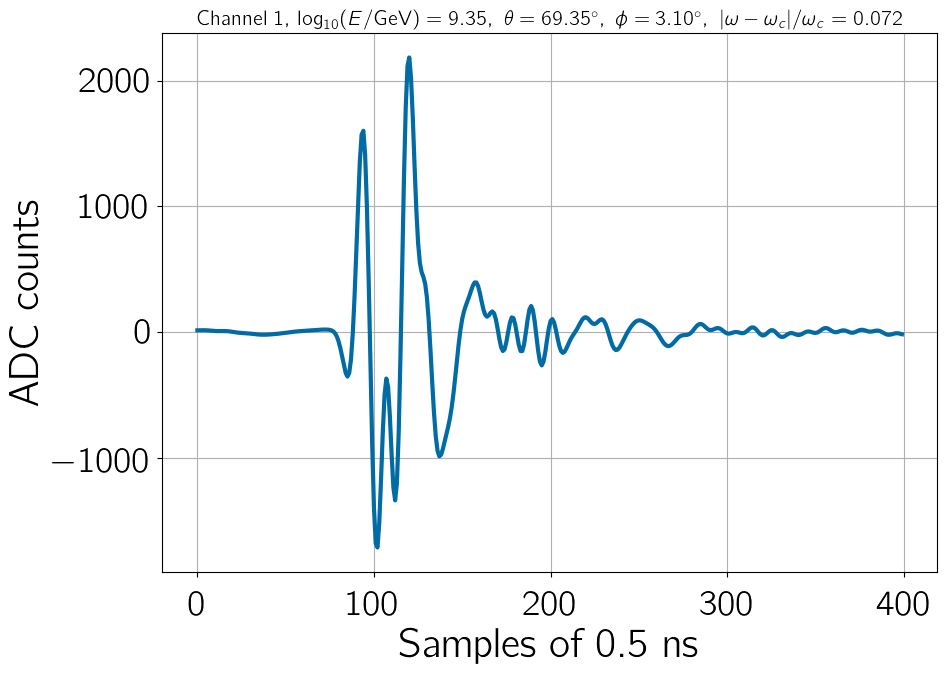

log10(E/GeV) = 9.47, theta = 64.89 deg, phi = 342.75 deg, omega = 0.645 deg, omega_c = 0.813 deg, |omega-omega_c|/omega_c = 0.207 
Vpp = [1598. 6424.  913.] ADC counts, pulse_width = [28. 48. 45.] ADC samples, n_peaks = [ 9. 15. 15.], peak_ratio = [1.48136646 1.04846939 1.55027933], peak_dist = [5. 4. 5.] ADC samples


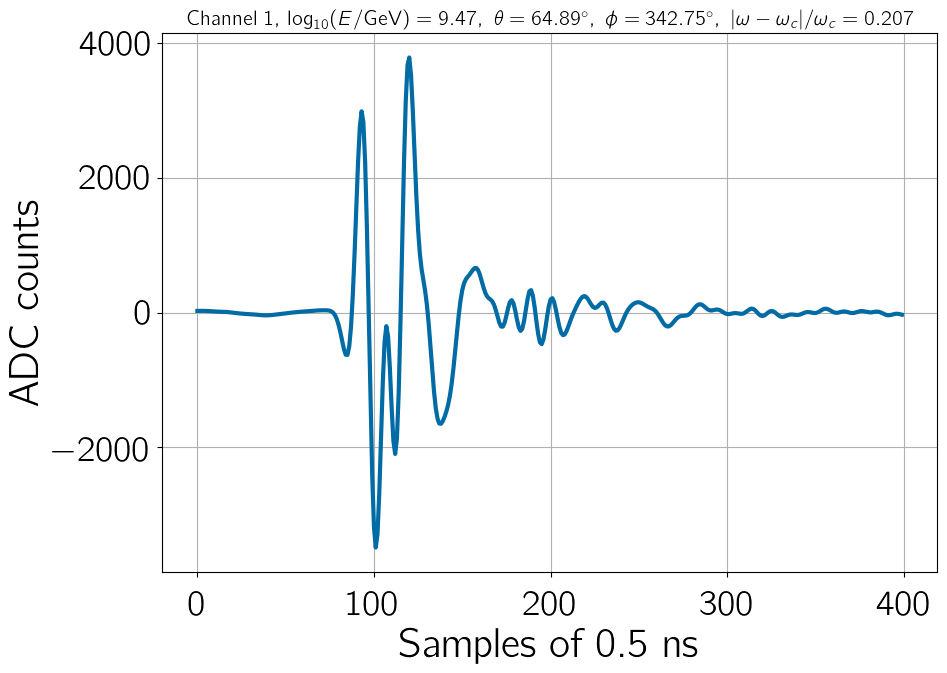

log10(E/GeV) = 9.16, theta = 66.04 deg, phi = 248.08 deg, omega = 1.143 deg, omega_c = 0.805 deg, |omega-omega_c|/omega_c = 0.420 
Vpp = [1366.  659.  974.] ADC counts, pulse_width = [31. 16. 53.] ADC samples, n_peaks = [ 9.  5. 16.], peak_ratio = [1.16825397 1.059375   1.68292683], peak_dist = [ 4.  2. 13.] ADC samples


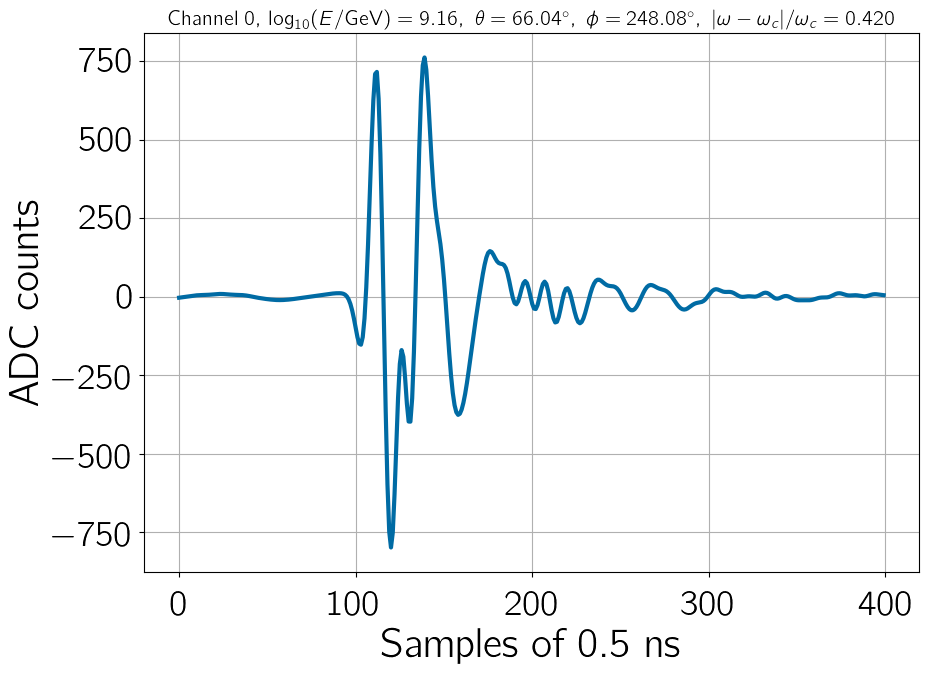

log10(E/GeV) = 9.17, theta = 70.31 deg, phi = 318.44 deg, omega = 1.261 deg, omega_c = 0.754 deg, |omega-omega_c|/omega_c = 0.672 
Vpp = [640. 773. 183.] ADC counts, pulse_width = [12. 17. 26.] ADC samples, n_peaks = [4. 5. 5.], peak_ratio = [1.06451613 1.03421053 1.02083333], peak_dist = [ 4.  4. 13.] ADC samples


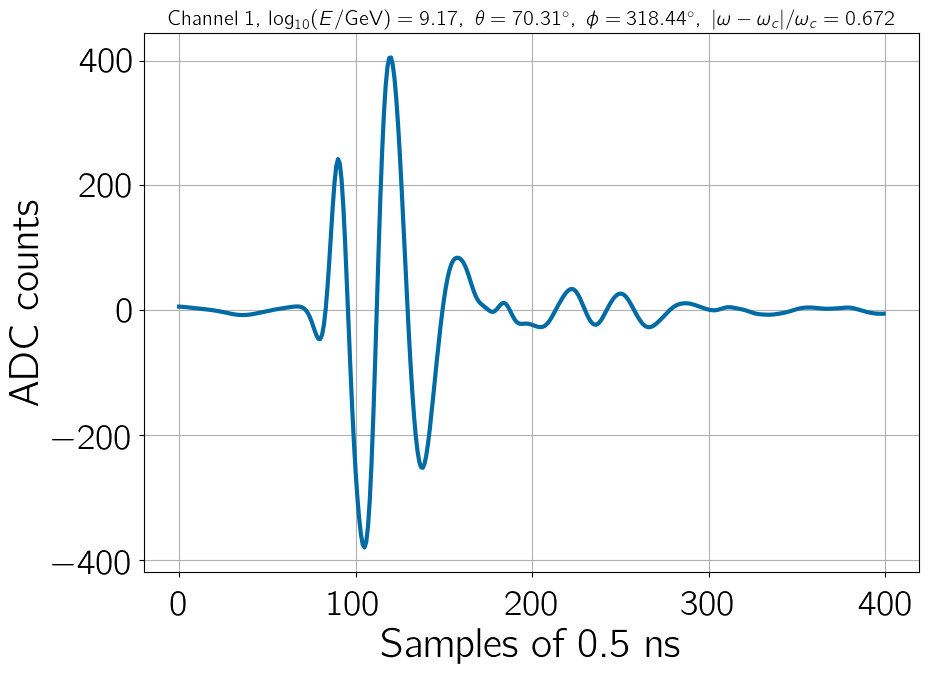

log10(E/GeV) = 9.20, theta = 67.93 deg, phi = 20.69 deg, omega = 1.689 deg, omega_c = 0.845 deg, |omega-omega_c|/omega_c = 1.000 
Vpp = [204. 617.  82.] ADC counts, pulse_width = [ 4. 13. -1.] ADC samples, n_peaks = [2. 4. 0.], peak_ratio = [ 1.19354839  1.08445946 -1.        ], peak_dist = [ 4.  4. -1.] ADC samples


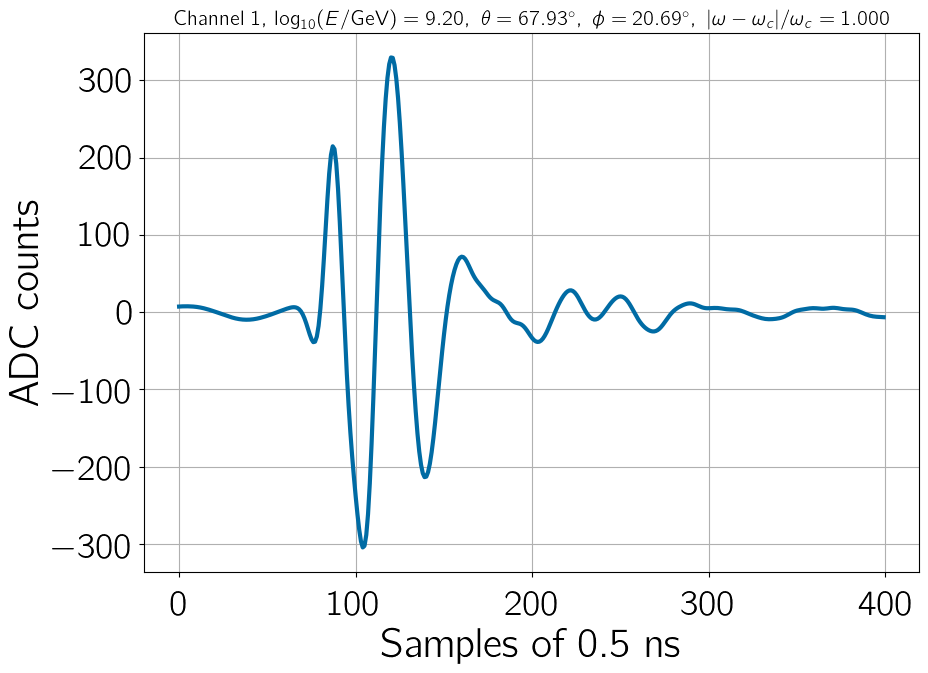

log10(E/GeV) = 9.37, theta = 68.57 deg, phi = 300.86 deg, omega = 1.571 deg, omega_c = 0.783 deg, |omega-omega_c|/omega_c = 1.007 
Vpp = [484. 401. 227.] ADC counts, pulse_width = [13. 13. 26.] ADC samples, n_peaks = [4. 4. 5.], peak_ratio = [1.06837607 1.005      1.04504505], peak_dist = [4. 4. 6.] ADC samples


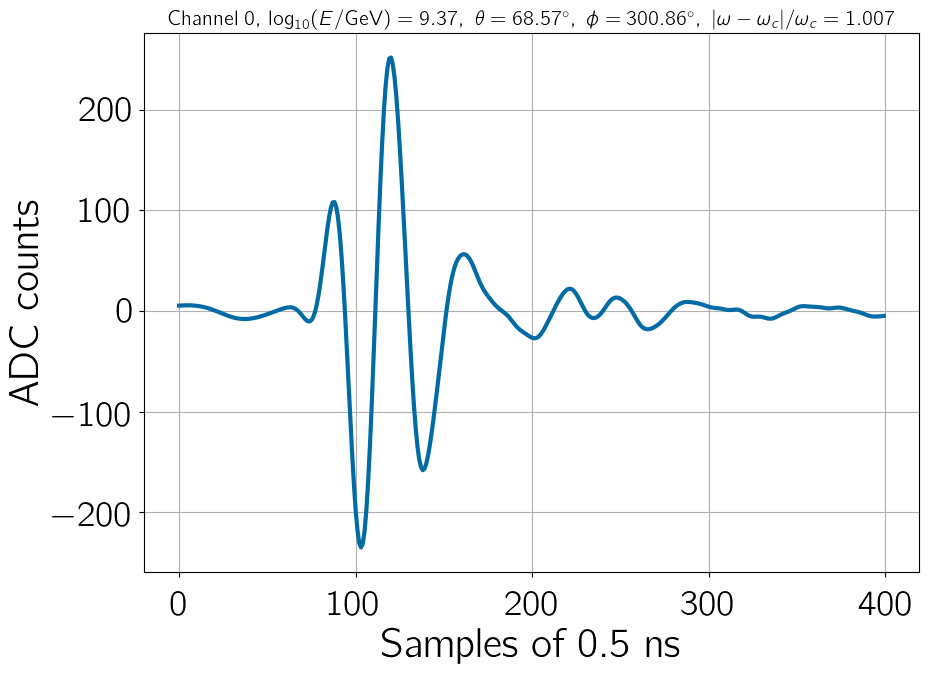

log10(E/GeV) = 9.47, theta = 64.89 deg, phi = 342.75 deg, omega = 1.829 deg, omega_c = 0.813 deg, |omega-omega_c|/omega_c = 1.250 
Vpp = [ 316. 1067.   90.] ADC counts, pulse_width = [ 9. 19. -1.] ADC samples, n_peaks = [3. 5. 0.], peak_ratio = [ 1.05194805  1.01701323 -1.        ], peak_dist = [ 5.  5. -1.] ADC samples


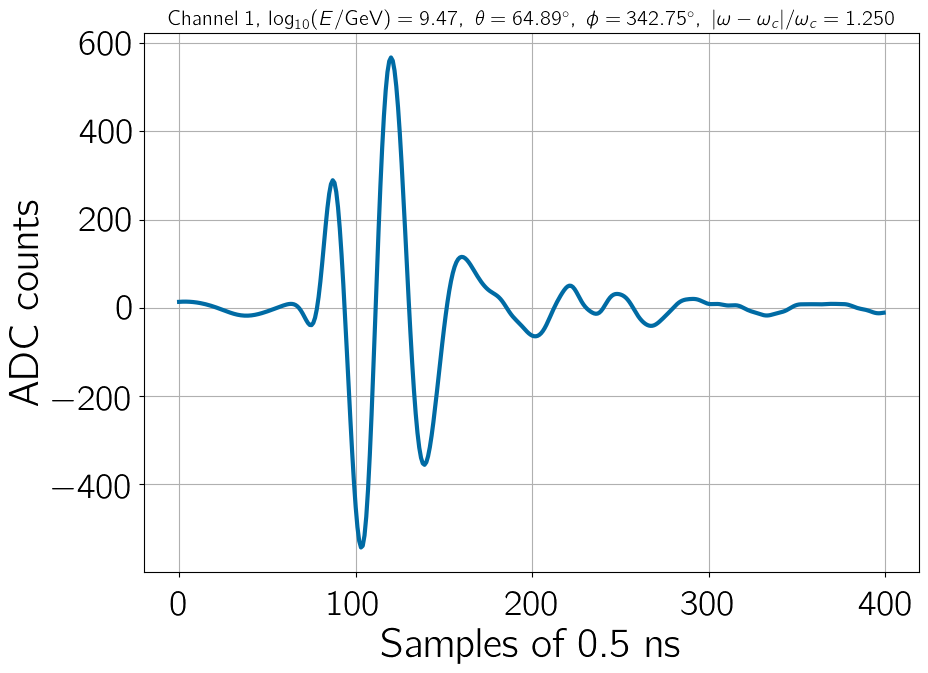

log10(E/GeV) = 9.47, theta = 70.14 deg, phi = 344.20 deg, omega = 1.932 deg, omega_c = 0.768 deg, |omega-omega_c|/omega_c = 1.516 
Vpp = [ 85. 371.  94.] ADC counts, pulse_width = [-1. 14. -1.] ADC samples, n_peaks = [0. 4. 0.], peak_ratio = [-1.          1.01630435 -1.        ], peak_dist = [-1.  4. -1.] ADC samples


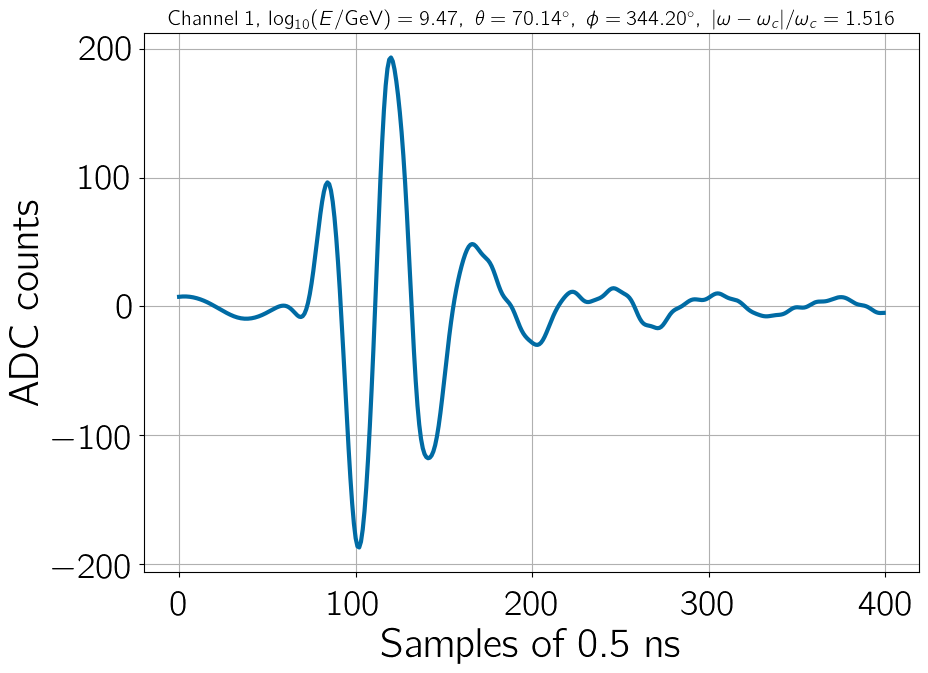

log10(E/GeV) = 9.44, theta = 70.08 deg, phi = 355.35 deg, omega = 2.191 deg, omega_c = 0.796 deg, |omega-omega_c|/omega_c = 1.751 
Vpp = [ 16. 222.  39.] ADC counts, pulse_width = [-1.  5. -1.] ADC samples, n_peaks = [0. 2. 0.], peak_ratio = [-1.          1.07476636 -1.        ], peak_dist = [-1.  5. -1.] ADC samples


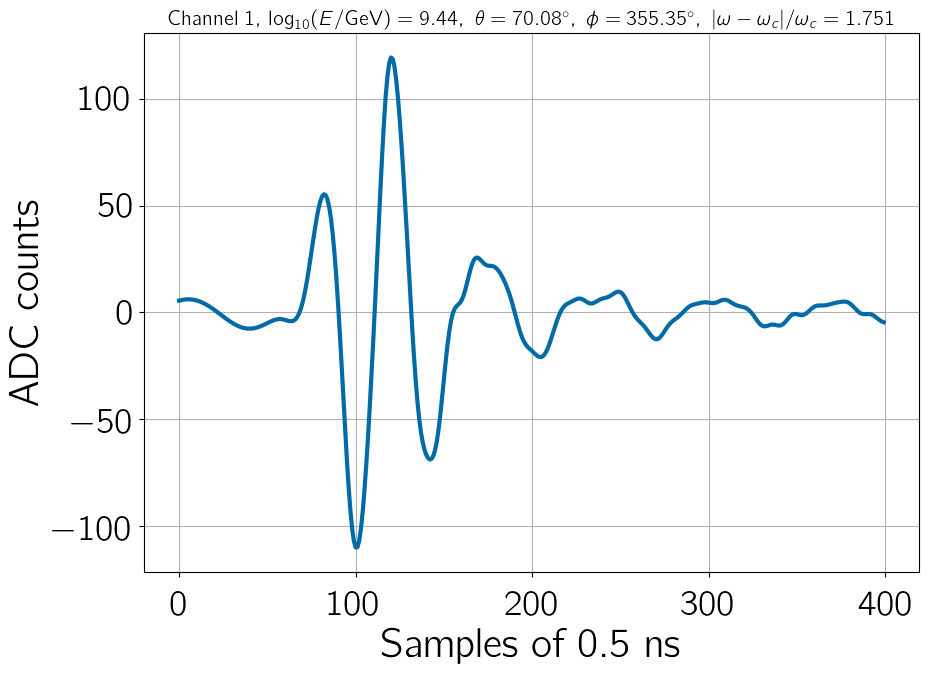

log10(E/GeV) = 9.55, theta = 67.21 deg, phi = 180.44 deg, omega = 2.407 deg, omega_c = 0.840 deg, |omega-omega_c|/omega_c = 1.866 
Vpp = [ 60. 548. 107.] ADC counts, pulse_width = [-1. 13. -1.] ADC samples, n_peaks = [0. 4. 0.], peak_ratio = [-1.          1.01470588 -1.        ], peak_dist = [-1.  4. -1.] ADC samples


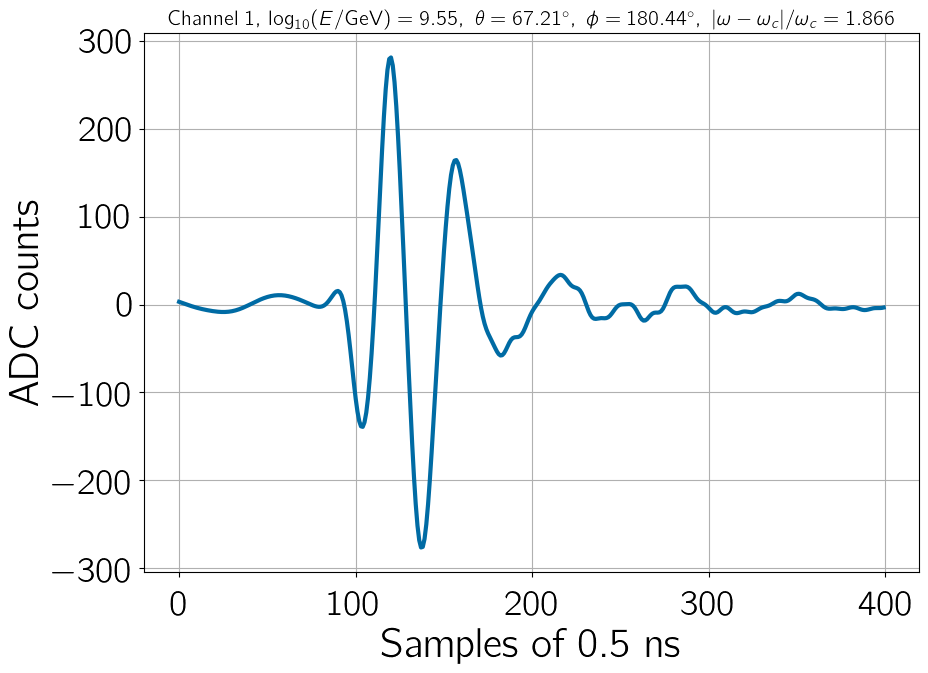

log10(E/GeV) = 9.14, theta = 73.37 deg, phi = 89.69 deg, omega = 0.842 deg, omega_c = 0.729 deg, |omega-omega_c|/omega_c = 0.155 
Vpp = [2549.  325.  668.] ADC counts, pulse_width = [37.  7. 44.] ADC samples, n_peaks = [11.  3. 11.], peak_ratio = [1.09967051 1.01863354 1.27210884], peak_dist = [3. 2. 2.] ADC samples


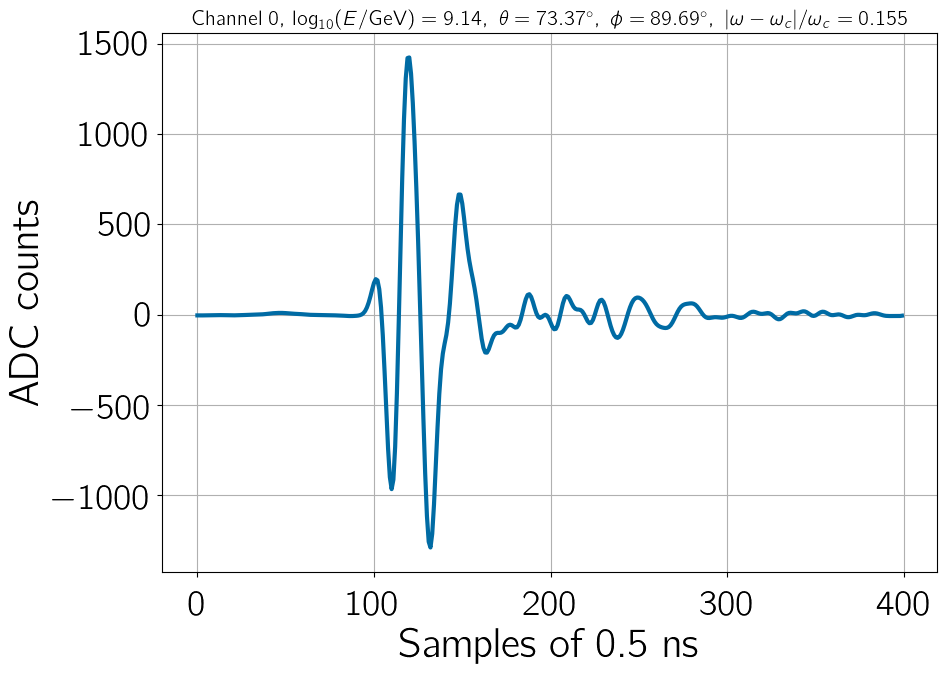

log10(E/GeV) = 9.24, theta = 74.31 deg, phi = 279.49 deg, omega = 0.893 deg, omega_c = 0.741 deg, |omega-omega_c|/omega_c = 0.205 
Vpp = [2644.  517.  591.] ADC counts, pulse_width = [41. 11. 44.] ADC samples, n_peaks = [10.  4. 12.], peak_ratio = [1.04169884 1.22844828 1.20522388], peak_dist = [ 3.  4. 16.] ADC samples


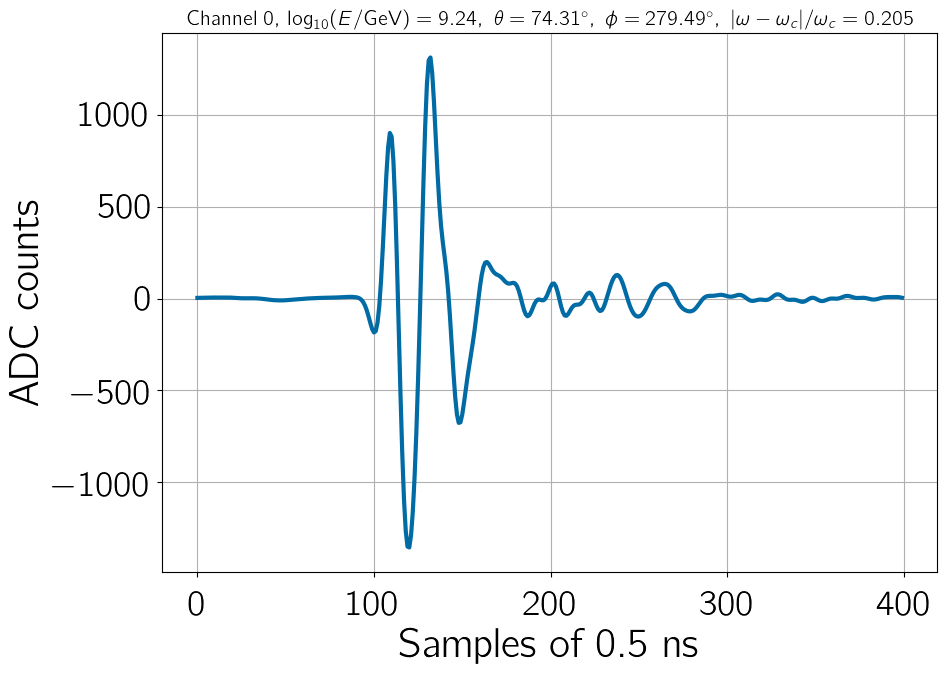

log10(E/GeV) = 9.23, theta = 75.89 deg, phi = 251.89 deg, omega = 1.079 deg, omega_c = 0.681 deg, |omega-omega_c|/omega_c = 0.585 
Vpp = [874. 297. 247.] ADC counts, pulse_width = [11.  7. 30.] ADC samples, n_peaks = [4. 3. 7.], peak_ratio = [1.21265823 1.00675676 1.04132231], peak_dist = [ 4.  3. 16.] ADC samples


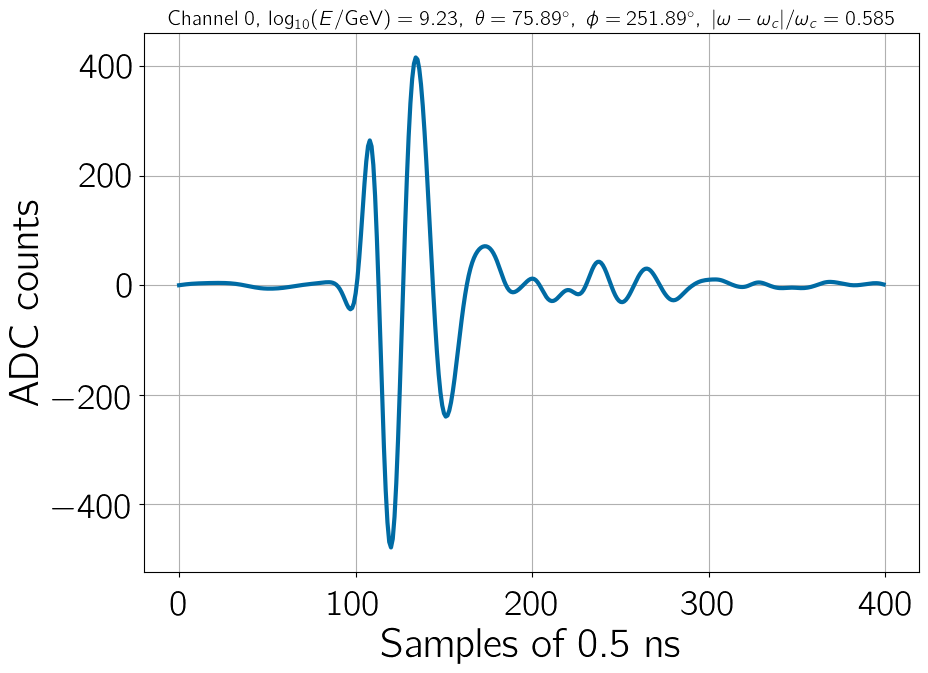

log10(E/GeV) = 9.46, theta = 72.95 deg, phi = 125.64 deg, omega = 0.237 deg, omega_c = 0.735 deg, |omega-omega_c|/omega_c = 0.678 
Vpp = [3261. 2177.  789.] ADC counts, pulse_width = [46. 35. 49.] ADC samples, n_peaks = [12.  7. 10.], peak_ratio = [1.08904548 1.11359223 1.04935065], peak_dist = [ 3.  3. 16.] ADC samples


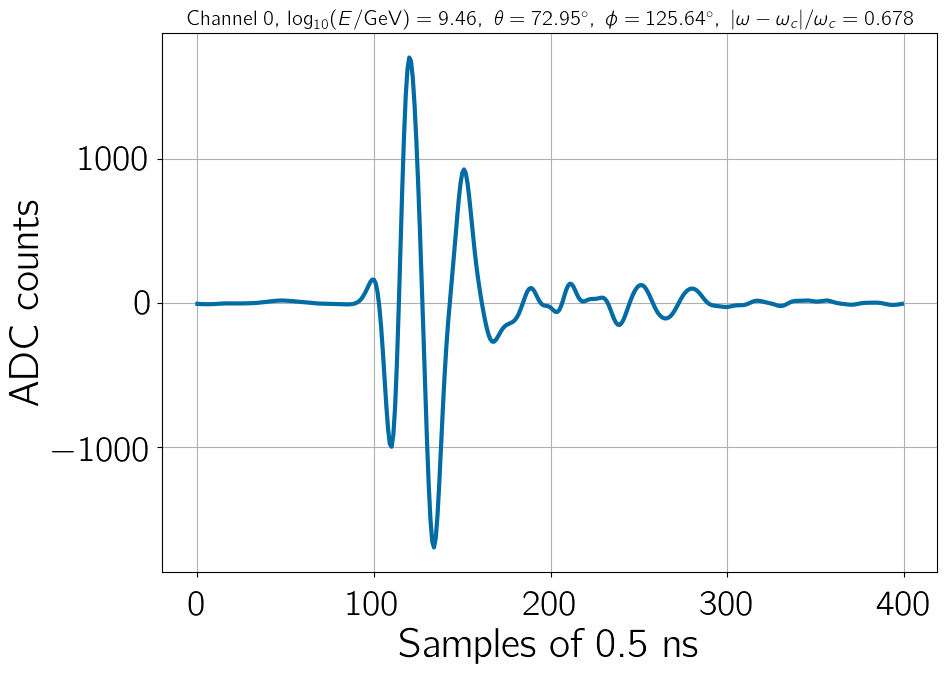

log10(E/GeV) = 9.34, theta = 75.70 deg, phi = 101.36 deg, omega = 1.306 deg, omega_c = 0.687 deg, |omega-omega_c|/omega_c = 0.903 
Vpp = [397.  90. 159.] ADC counts, pulse_width = [12. -1. 12.] ADC samples, n_peaks = [4. 0. 3.], peak_ratio = [ 1.0255102  -1.          1.09210526], peak_dist = [ 4. -1.  6.] ADC samples


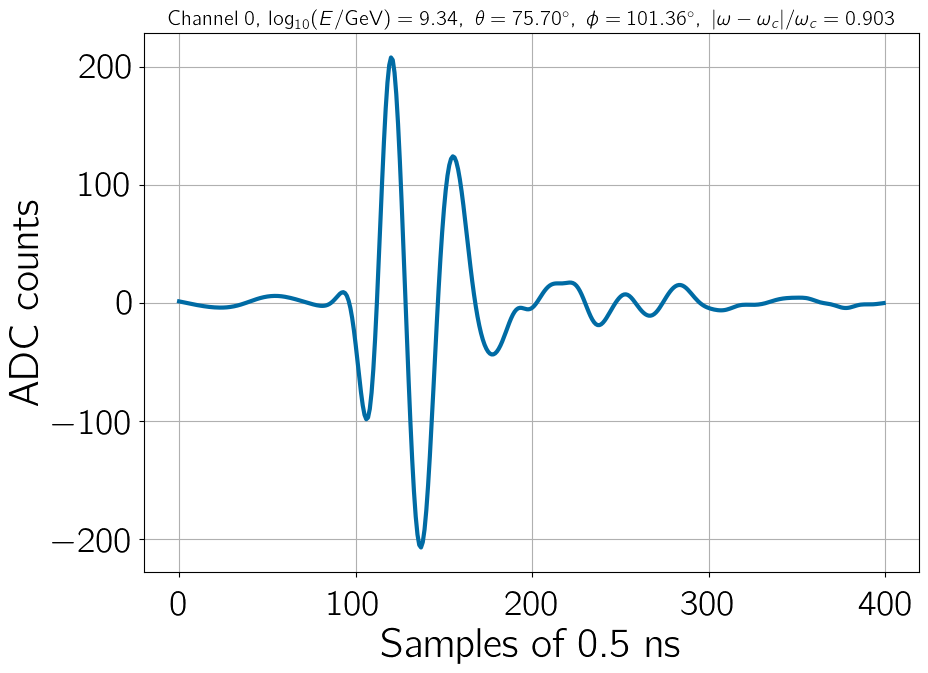

log10(E/GeV) = 9.11, theta = 73.63 deg, phi = 216.51 deg, omega = 1.462 deg, omega_c = 0.707 deg, |omega-omega_c|/omega_c = 1.069 
Vpp = [165. 226.  60.] ADC counts, pulse_width = [ 4.  4. -1.] ADC samples, n_peaks = [2. 2. 0.], peak_ratio = [ 1.01219512  1.05454545 -1.        ], peak_dist = [ 4.  4. -1.] ADC samples


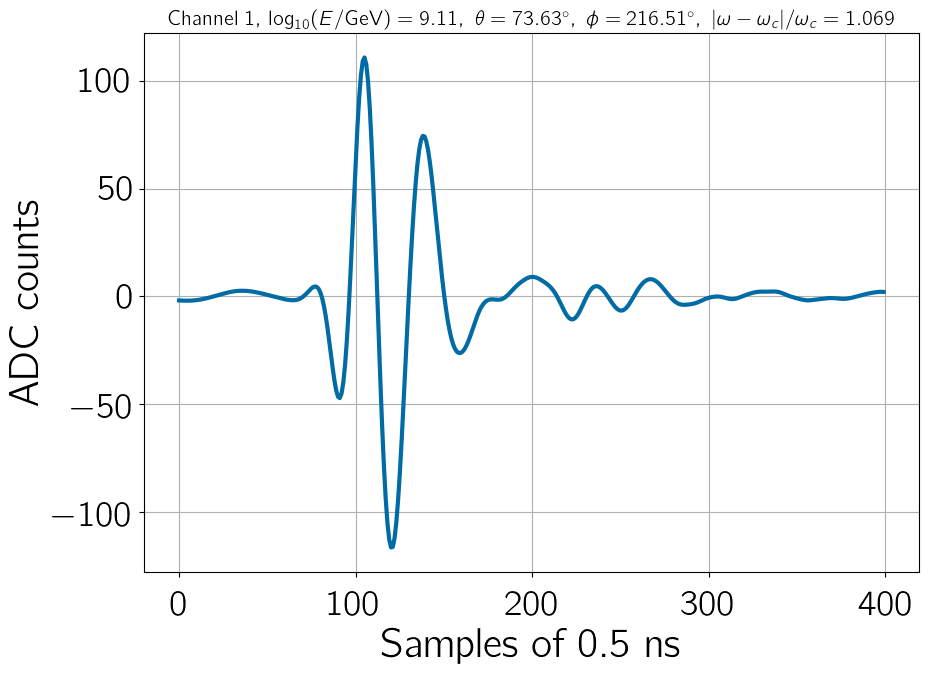

log10(E/GeV) = 9.44, theta = 75.37 deg, phi = 86.03 deg, omega = 1.464 deg, omega_c = 0.662 deg, |omega-omega_c|/omega_c = 1.210 
Vpp = [241.  38. 129.] ADC counts, pulse_width = [ 9. -1. -1.] ADC samples, n_peaks = [3. 0. 0.], peak_ratio = [ 1.13274336 -1.         -1.        ], peak_dist = [ 5. -1. -1.] ADC samples


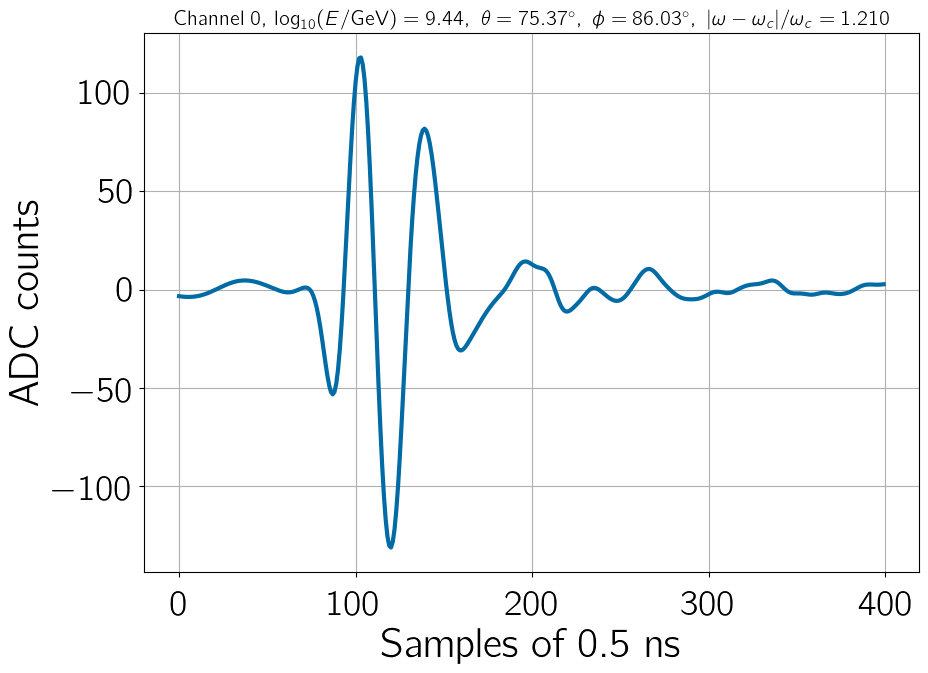

log10(E/GeV) = 9.50, theta = 74.76 deg, phi = 18.88 deg, omega = 1.734 deg, omega_c = 0.700 deg, |omega-omega_c|/omega_c = 1.476 
Vpp = [ 53. 154.  30.] ADC counts, pulse_width = [-1.  0. -1.] ADC samples, n_peaks = [0. 1. 0.], peak_ratio = [-1.  0. -1.], peak_dist = [-1.  0. -1.] ADC samples


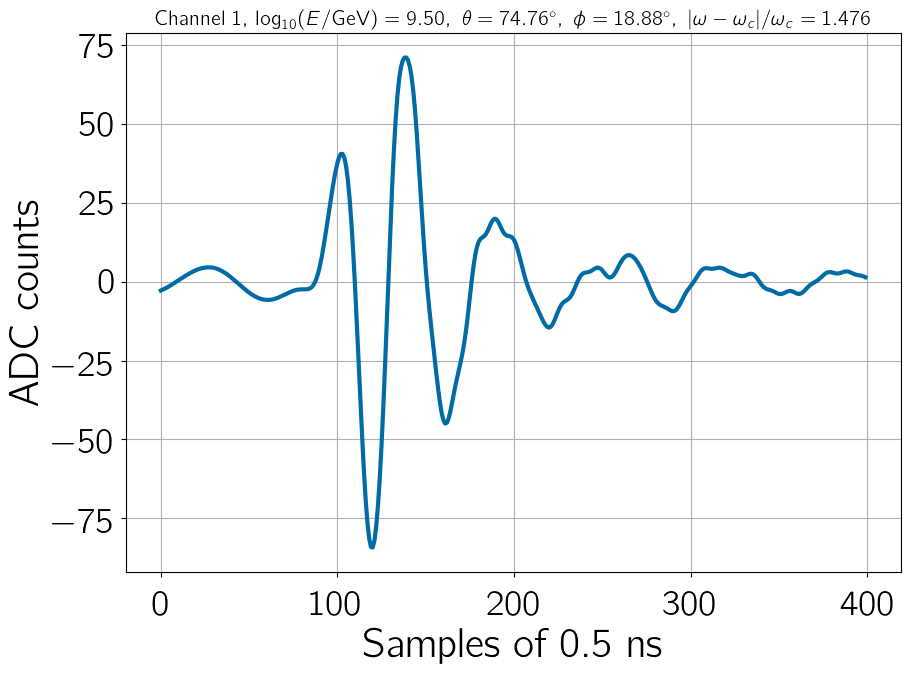

log10(E/GeV) = 9.53, theta = 73.39 deg, phi = 298.51 deg, omega = 1.814 deg, omega_c = 0.686 deg, |omega-omega_c|/omega_c = 1.645 
Vpp = [237. 141. 186.] ADC counts, pulse_width = [11. -1. 26.] ADC samples, n_peaks = [3. 0. 5.], peak_ratio = [ 1.04310345 -1.          1.04395604], peak_dist = [ 5. -1.  7.] ADC samples


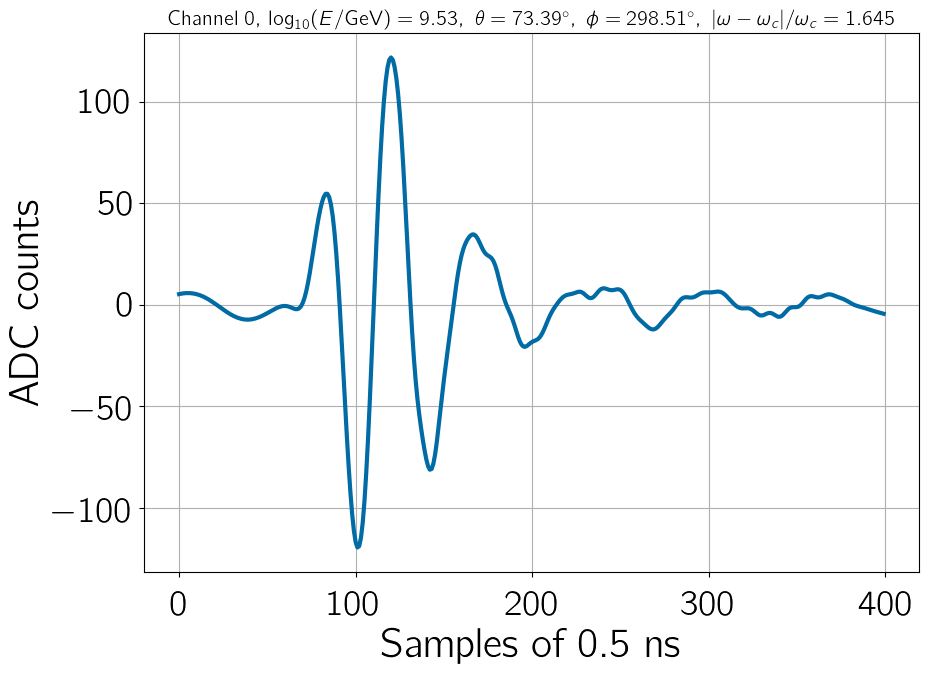

log10(E/GeV) = 9.54, theta = 71.78 deg, phi = 105.32 deg, omega = 2.159 deg, omega_c = 0.764 deg, |omega-omega_c|/omega_c = 1.825 
Vpp = [198.  41. 147.] ADC counts, pulse_width = [ 5. -1.  0.] ADC samples, n_peaks = [2. 0. 1.], peak_ratio = [ 1.02040816 -1.          0.        ], peak_dist = [ 5. -1.  0.] ADC samples


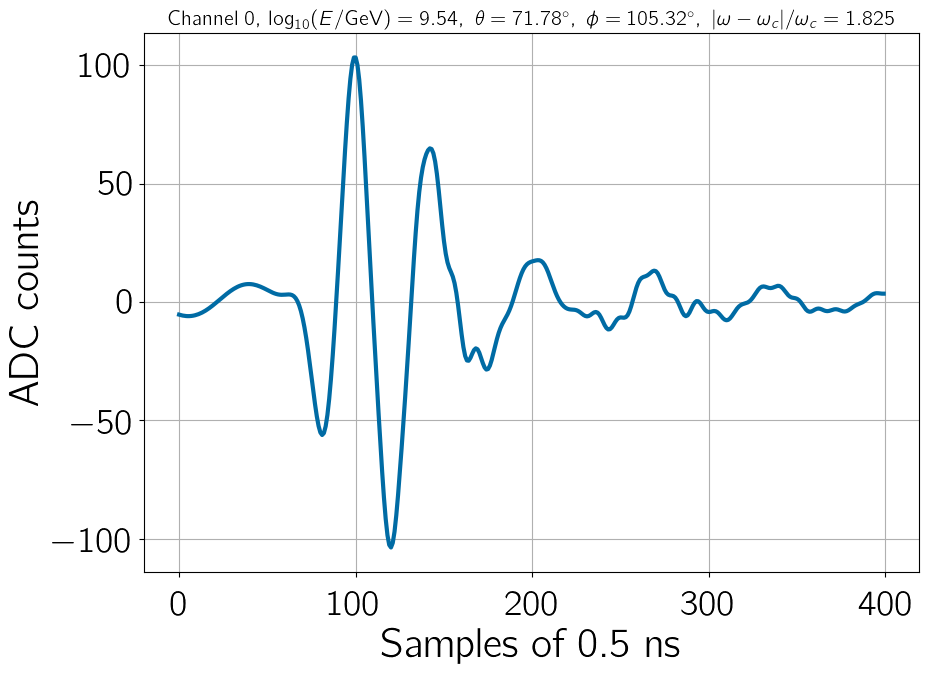

log10(E/GeV) = 9.29, theta = 78.93 deg, phi = 153.62 deg, omega = 0.728 deg, omega_c = 0.624 deg, |omega-omega_c|/omega_c = 0.167 
Vpp = [1126. 2237.  430.] ADC counts, pulse_width = [ 8. 34. 29.] ADC samples, n_peaks = [ 4. 10.  7.], peak_ratio = [1.92467532 1.92418301 1.27513228], peak_dist = [2. 2. 2.] ADC samples


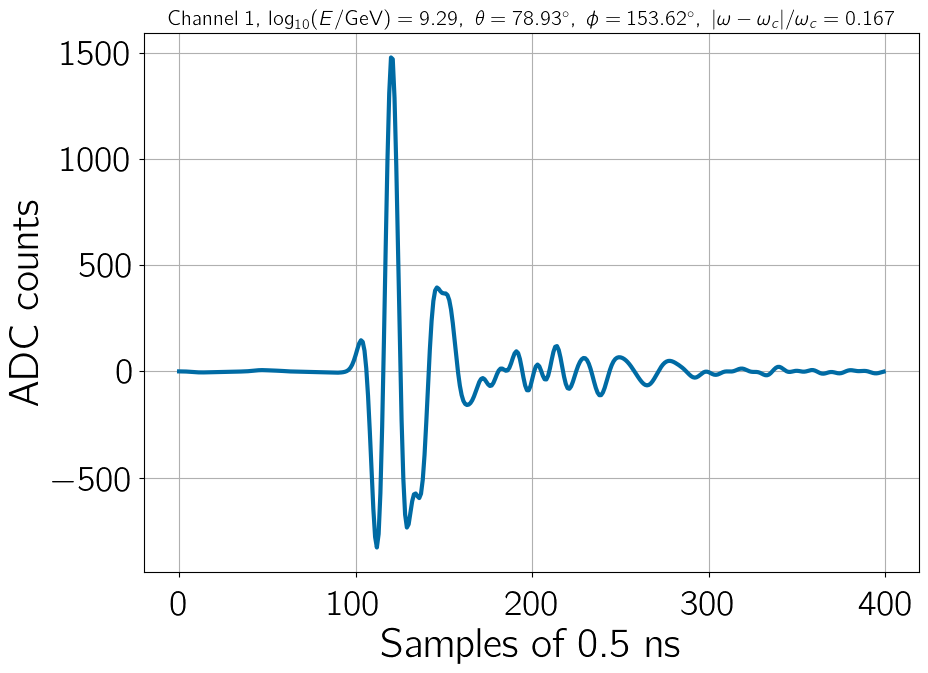

log10(E/GeV) = 9.11, theta = 81.62 deg, phi = 218.51 deg, omega = 0.691 deg, omega_c = 0.558 deg, |omega-omega_c|/omega_c = 0.237 
Vpp = [498. 535. 136.] ADC counts, pulse_width = [ 8.  7. -1.] ADC samples, n_peaks = [5. 3. 0.], peak_ratio = [ 1.94674556  1.9076087  -1.        ], peak_dist = [ 2.  2. -1.] ADC samples


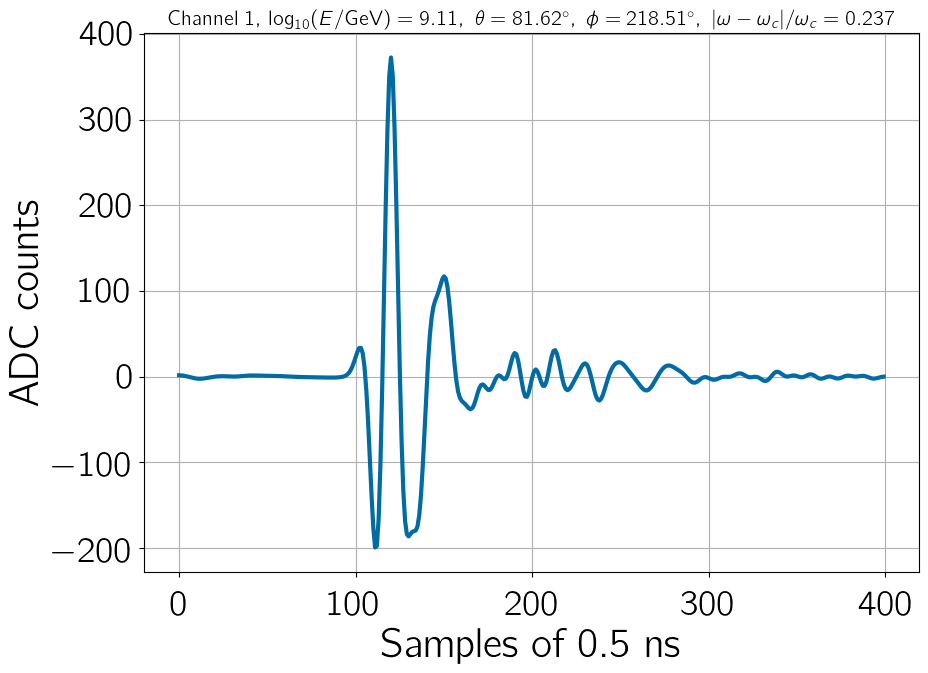

log10(E/GeV) = 9.45, theta = 79.23 deg, phi = 142.73 deg, omega = 0.861 deg, omega_c = 0.605 deg, |omega-omega_c|/omega_c = 0.424 
Vpp = [ 871. 1256.  333.] ADC counts, pulse_width = [10. 13. 29.] ADC samples, n_peaks = [4. 5. 6.], peak_ratio = [1.5393586  1.48221344 1.05555556], peak_dist = [4. 4. 2.] ADC samples


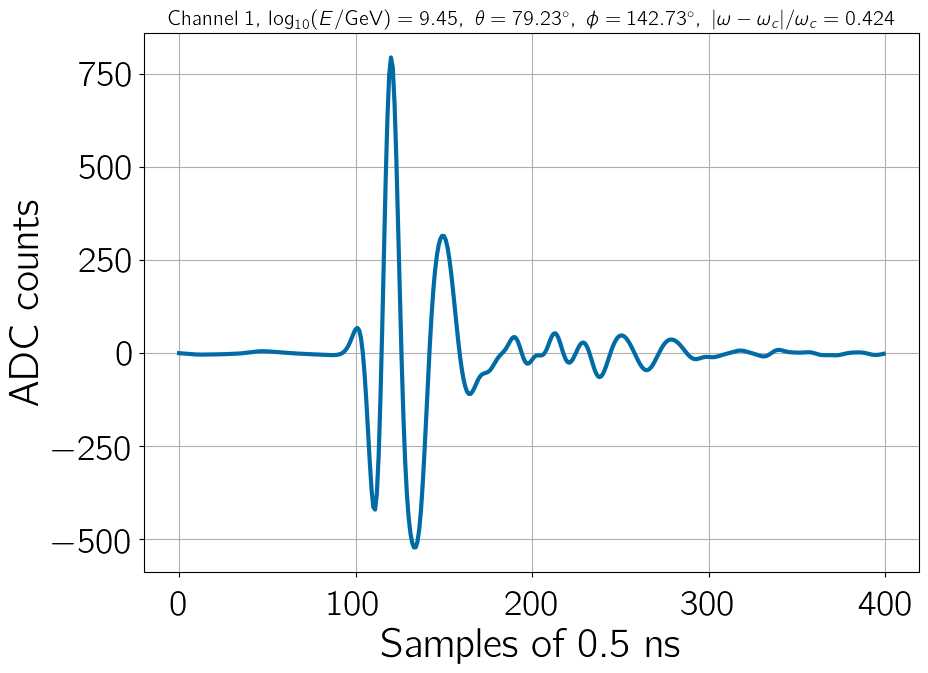

log10(E/GeV) = 9.45, theta = 79.05 deg, phi = 83.68 deg, omega = 0.207 deg, omega_c = 0.605 deg, |omega-omega_c|/omega_c = 0.658 
Vpp = [2658.  292.  588.] ADC counts, pulse_width = [41.  7. 42.] ADC samples, n_peaks = [11.  3. 11.], peak_ratio = [1.47486034 1.31746032 1.37349398], peak_dist = [ 3.  4. 13.] ADC samples


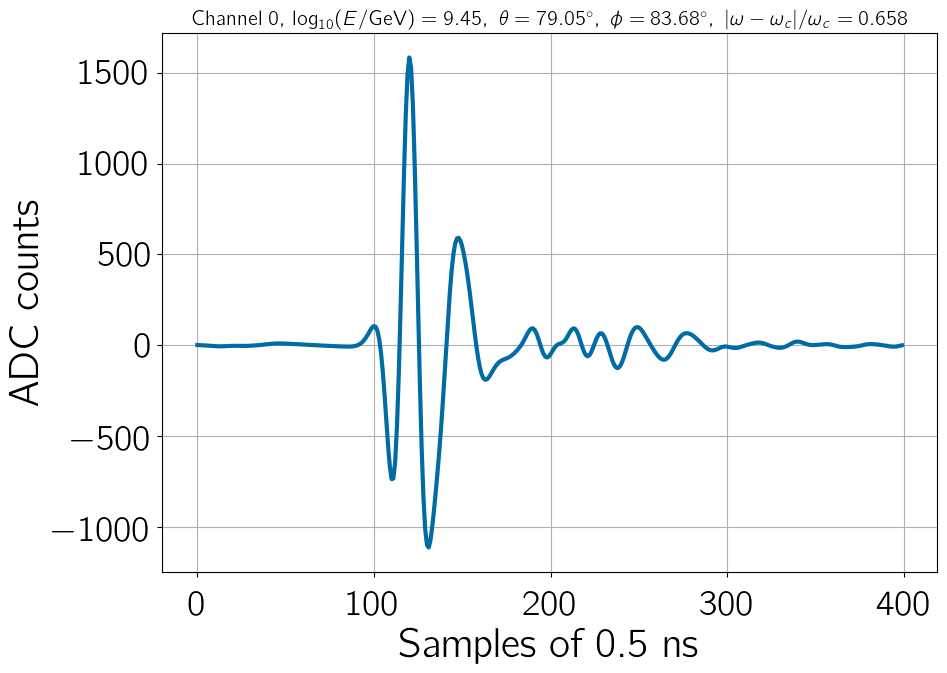

log10(E/GeV) = 9.42, theta = 79.28 deg, phi = 195.60 deg, omega = 1.206 deg, omega_c = 0.628 deg, |omega-omega_c|/omega_c = 0.921 
Vpp = [135. 438.  51.] ADC counts, pulse_width = [-1. 11. -1.] ADC samples, n_peaks = [0. 4. 0.], peak_ratio = [-1.  1. -1.], peak_dist = [-1.  4. -1.] ADC samples


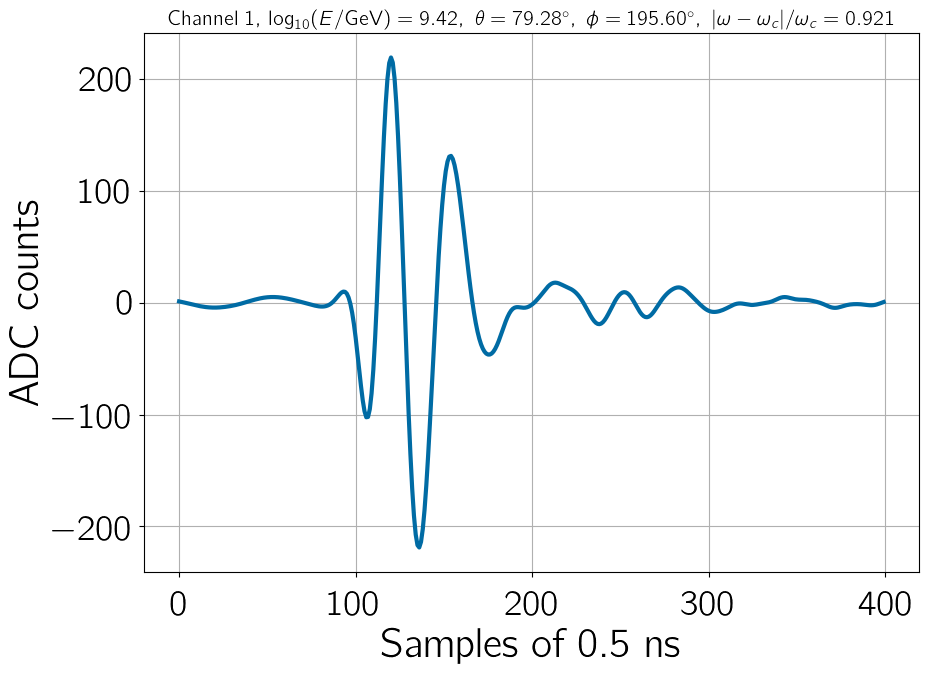

log10(E/GeV) = 9.34, theta = 79.27 deg, phi = 157.24 deg, omega = 1.283 deg, omega_c = 0.622 deg, |omega-omega_c|/omega_c = 1.061 
Vpp = [ 57. 159.  35.] ADC counts, pulse_width = [-1.  4. -1.] ADC samples, n_peaks = [0. 2. 0.], peak_ratio = [-1.          1.06493506 -1.        ], peak_dist = [-1.  4. -1.] ADC samples


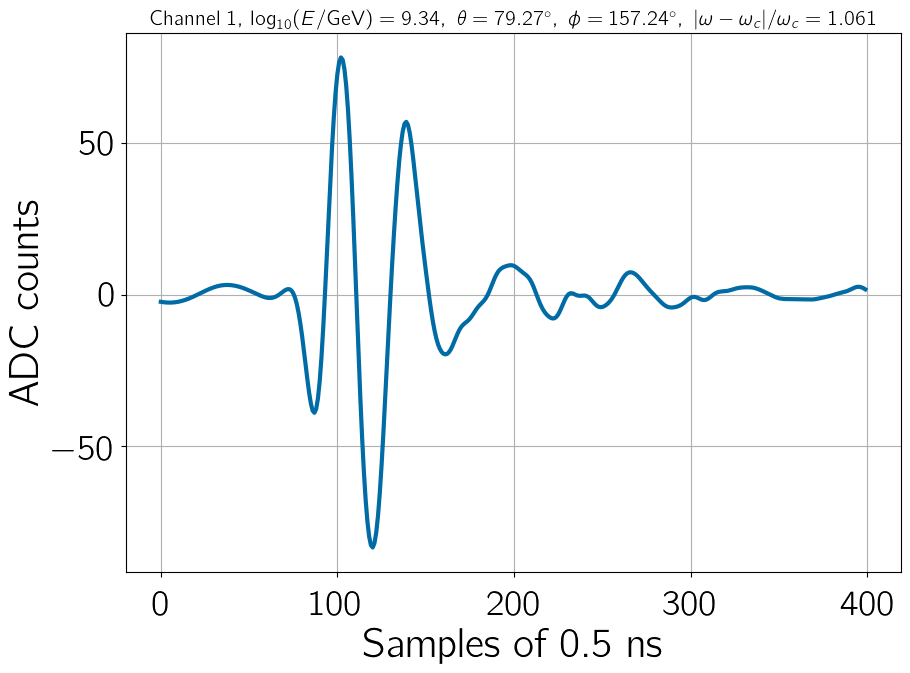

log10(E/GeV) = 9.55, theta = 77.61 deg, phi = 237.87 deg, omega = 1.534 deg, omega_c = 0.657 deg, |omega-omega_c|/omega_c = 1.335 
Vpp = [345. 216. 209.] ADC counts, pulse_width = [13.  9. 26.] ADC samples, n_peaks = [4. 3. 5.], peak_ratio = [1.02941176 1.11764706 1.06930693], peak_dist = [5. 4. 7.] ADC samples


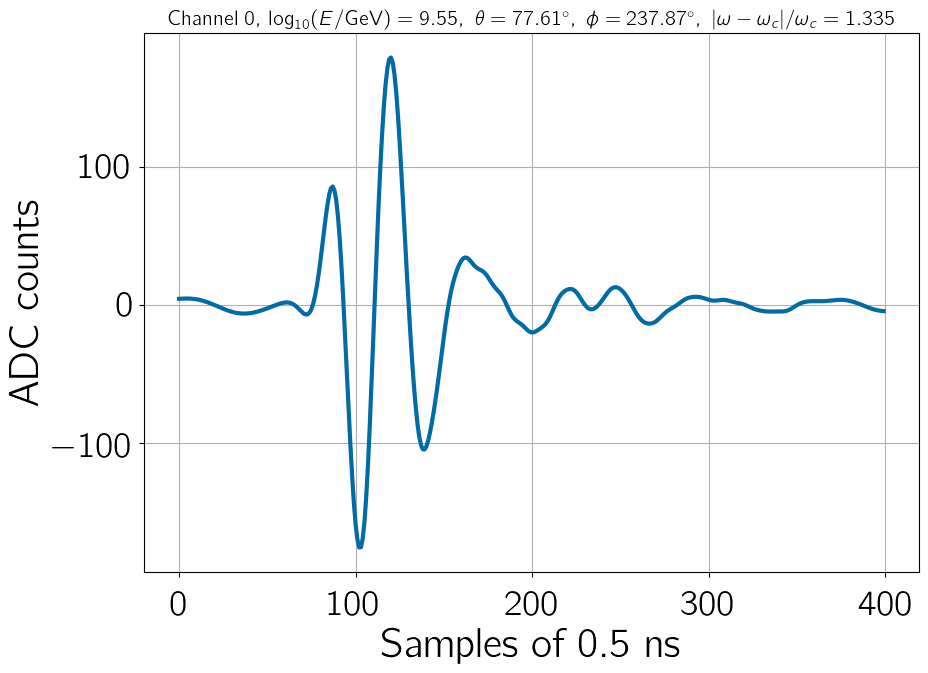

log10(E/GeV) = 9.46, theta = 77.85 deg, phi = 137.86 deg, omega = 1.682 deg, omega_c = 0.693 deg, |omega-omega_c|/omega_c = 1.428 
Vpp = [156. 191.  89.] ADC counts, pulse_width = [ 4.  5. -1.] ADC samples, n_peaks = [2. 2. 0.], peak_ratio = [ 1.02597403  1.0989011  -1.        ], peak_dist = [ 4.  5. -1.] ADC samples


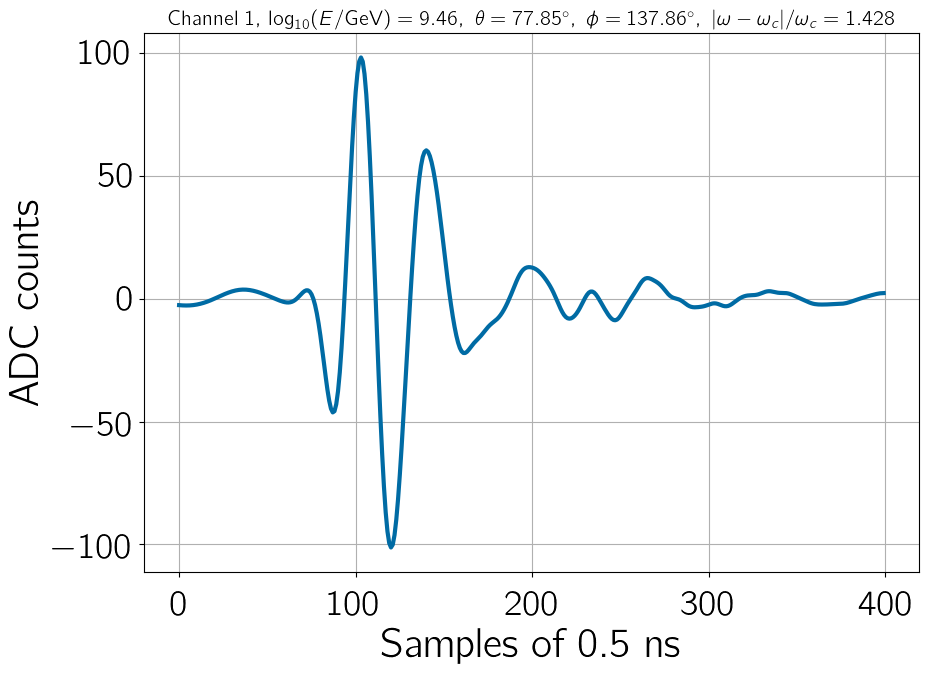

log10(E/GeV) = 9.60, theta = 77.03 deg, phi = 41.97 deg, omega = 1.859 deg, omega_c = 0.704 deg, |omega-omega_c|/omega_c = 1.641 
Vpp = [191. 192.  95.] ADC counts, pulse_width = [ 5.  5. -1.] ADC samples, n_peaks = [2. 2. 0.], peak_ratio = [ 1.07608696  1.06451613 -1.        ], peak_dist = [ 5.  5. -1.] ADC samples


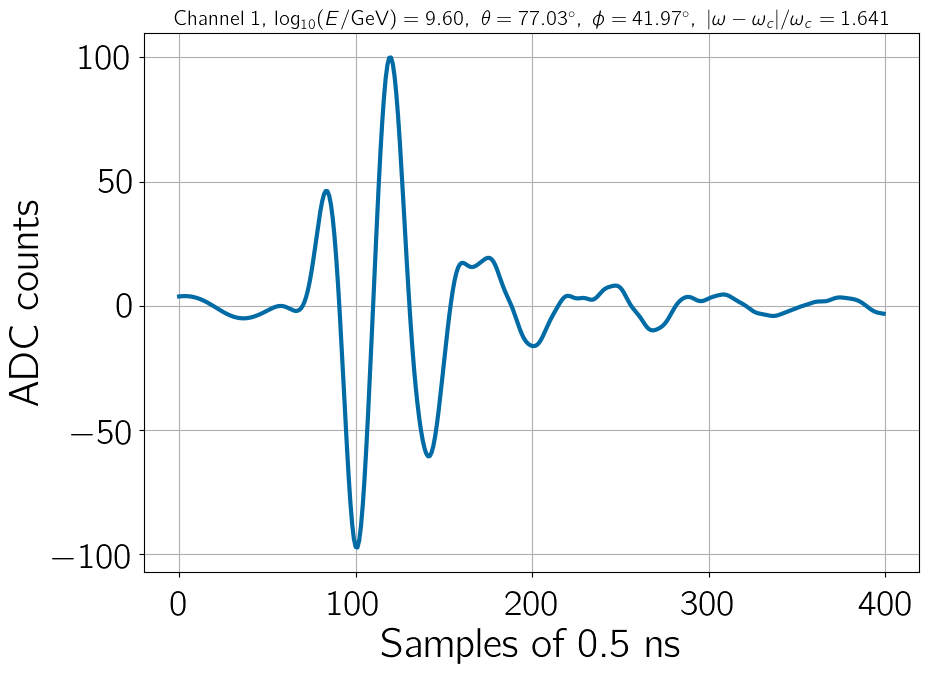

log10(E/GeV) = 9.43, theta = 85.48 deg, phi = 108.02 deg, omega = 0.477 deg, omega_c = 0.486 deg, |omega-omega_c|/omega_c = 0.017 
Vpp = [844. 214. 311.] ADC counts, pulse_width = [7. 2. 7.] ADC samples, n_peaks = [4. 2. 4.], peak_ratio = [1.50445104 1.64197531 1.22077922], peak_dist = [2. 2. 3.] ADC samples


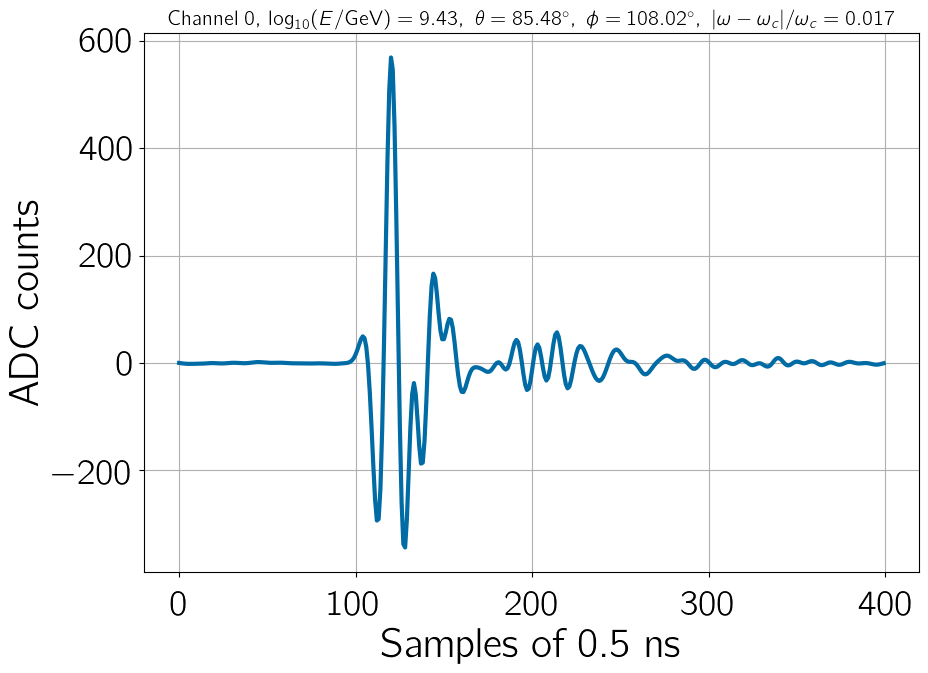

log10(E/GeV) = 9.11, theta = 85.23 deg, phi = 336.18 deg, omega = 0.666 deg, omega_c = 0.497 deg, |omega-omega_c|/omega_c = 0.339 
Vpp = [ 95. 229.  34.] ADC counts, pulse_width = [-1.  3. -1.] ADC samples, n_peaks = [0. 2. 0.], peak_ratio = [-1.          1.54444444 -1.        ], peak_dist = [-1.  3. -1.] ADC samples


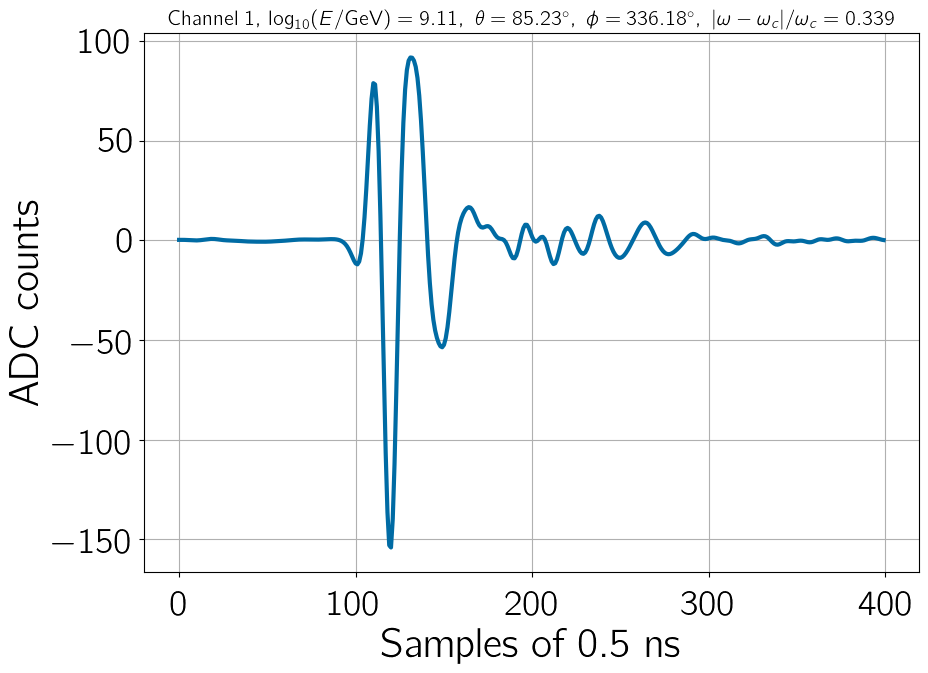

log10(E/GeV) = 9.24, theta = 86.79 deg, phi = 169.09 deg, omega = 0.235 deg, omega_c = 0.457 deg, |omega-omega_c|/omega_c = 0.487 
Vpp = [ 38. 213.  13.] ADC counts, pulse_width = [-1.  0. -1.] ADC samples, n_peaks = [0. 1. 0.], peak_ratio = [-1.  0. -1.], peak_dist = [-1.  0. -1.] ADC samples


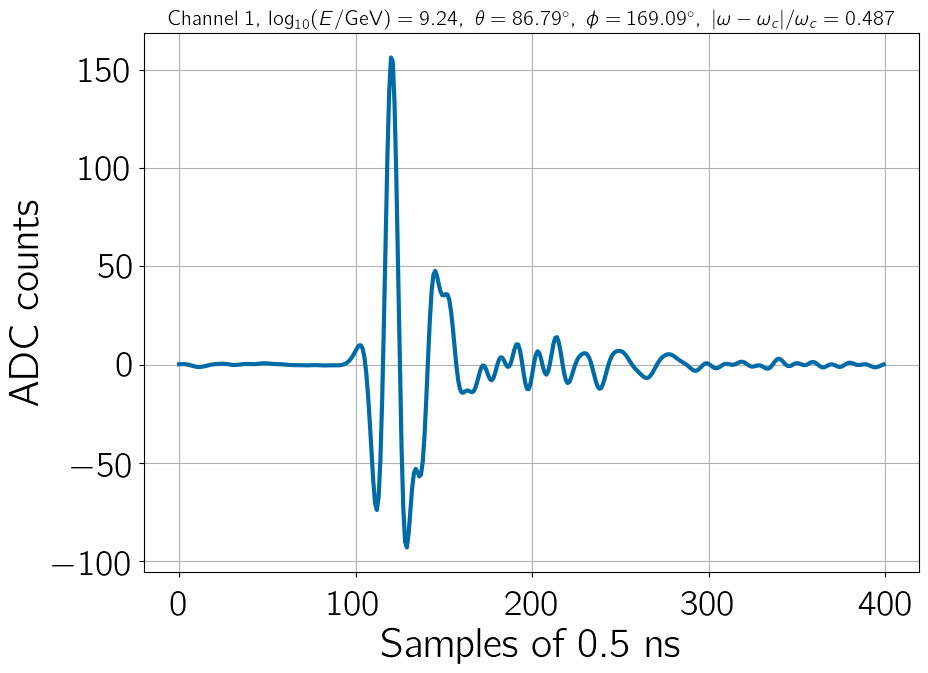

log10(E/GeV) = 9.25, theta = 86.38 deg, phi = 127.76 deg, omega = 0.161 deg, omega_c = 0.469 deg, |omega-omega_c|/omega_c = 0.656 
Vpp = [156. 109.  42.] ADC counts, pulse_width = [ 0. -1. -1.] ADC samples, n_peaks = [1. 0. 0.], peak_ratio = [ 0. -1. -1.], peak_dist = [ 0. -1. -1.] ADC samples


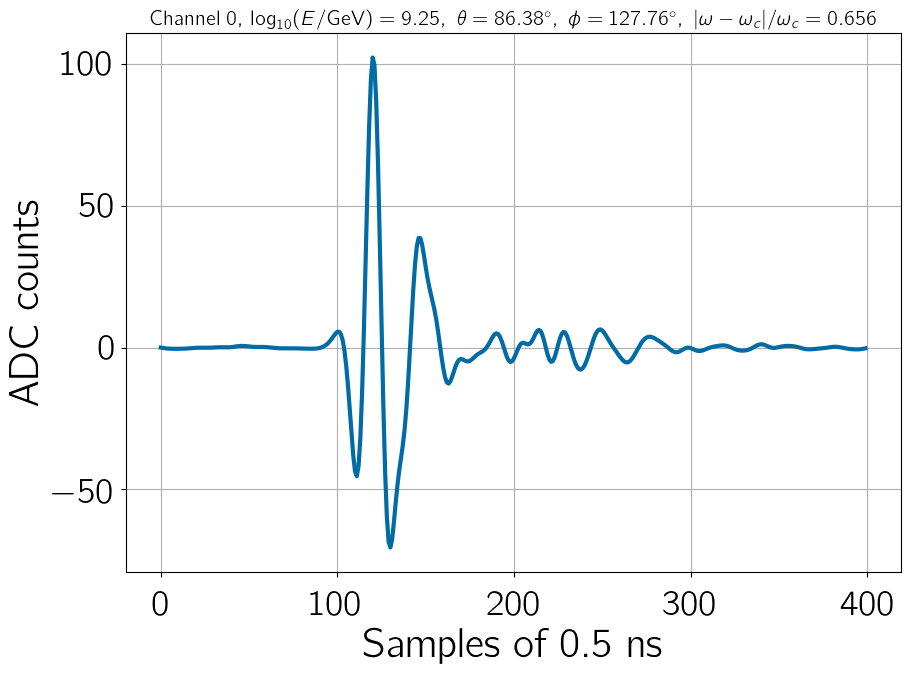

log10(E/GeV) = 9.31, theta = 87.09 deg, phi = 13.04 deg, omega = 0.065 deg, omega_c = 0.442 deg, |omega-omega_c|/omega_c = 0.853 
Vpp = [ 32. 157.   8.] ADC counts, pulse_width = [-1.  0. -1.] ADC samples, n_peaks = [0. 1. 0.], peak_ratio = [-1.  0. -1.], peak_dist = [-1.  0. -1.] ADC samples


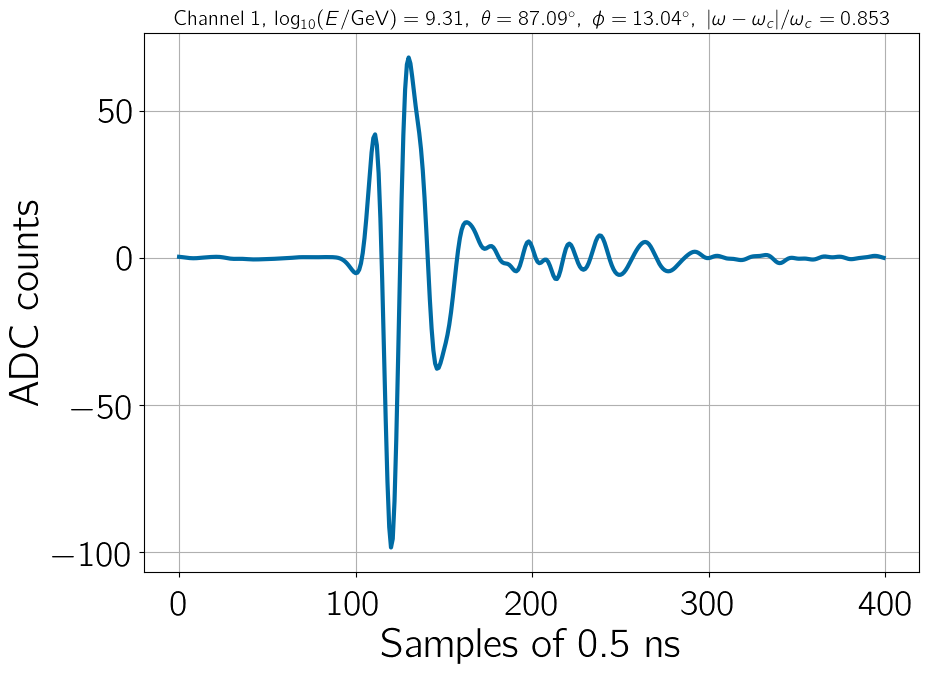

log10(E/GeV) = 9.37, theta = 81.90 deg, phi = 115.17 deg, omega = 1.154 deg, omega_c = 0.560 deg, |omega-omega_c|/omega_c = 1.060 
Vpp = [197.  99.  72.] ADC counts, pulse_width = [ 4. -1. -1.] ADC samples, n_peaks = [2. 0. 0.], peak_ratio = [ 1.03092784 -1.         -1.        ], peak_dist = [ 4. -1. -1.] ADC samples


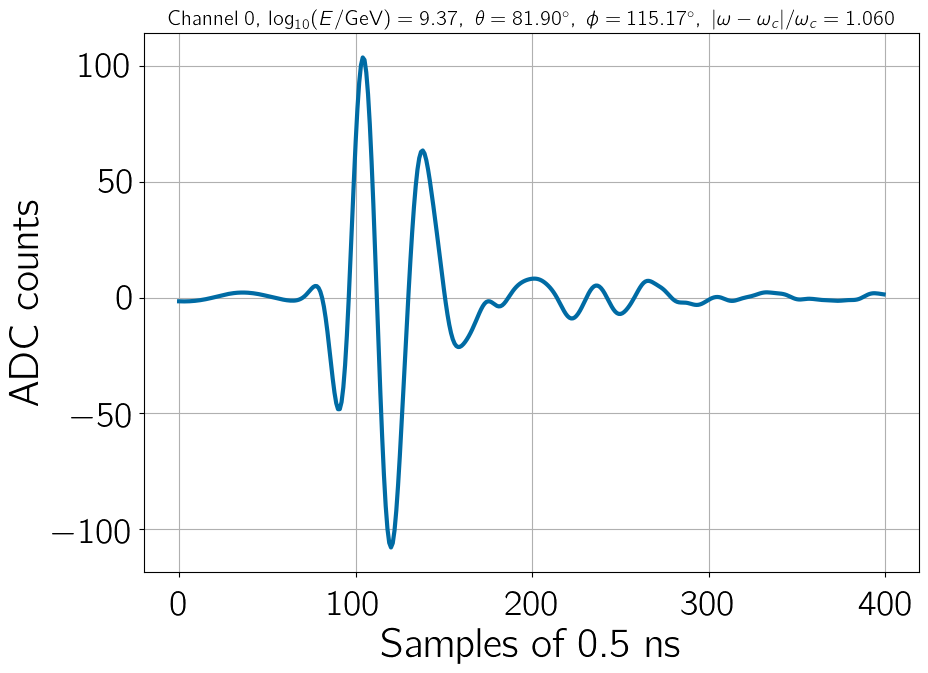

log10(E/GeV) = 9.56, theta = 81.83 deg, phi = 211.68 deg, omega = 1.258 deg, omega_c = 0.551 deg, |omega-omega_c|/omega_c = 1.284 
Vpp = [ 98. 173.  64.] ADC counts, pulse_width = [-1.  4. -1.] ADC samples, n_peaks = [0. 2. 0.], peak_ratio = [-1.          1.13580247 -1.        ], peak_dist = [-1.  4. -1.] ADC samples


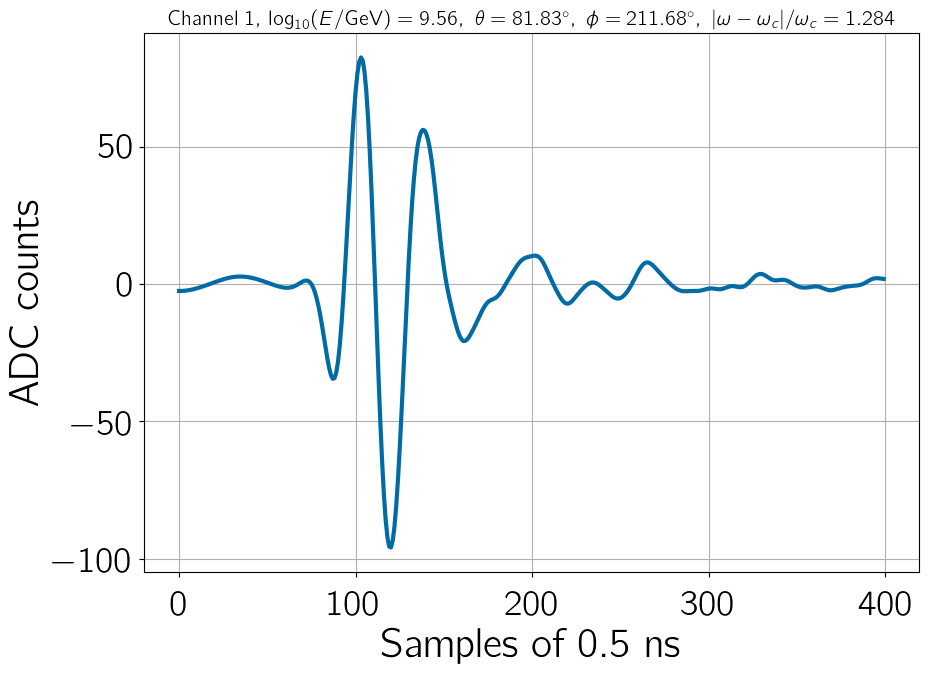

In [14]:
for k,idx in enumerate(mask_sel[:]):
    tvoltage = rt.TVoltage(vf_dir+vfile[idx])
    tvoltage.get_entry(0)

    trace = digitize( np.array(tvoltage.trace[int(du_idx[idx])]), adc_sampling_rate=2000, quantize=False ) # optional argument to not desample

    if pol == 'XY':
        max_x = np.max( np.abs(trace[0,:]) )
        max_y = np.max( np.abs(trace[1,:]) )
        pol_idx = np.argmax( [max_x,max_y] )
    if pol == 'Z':
        pol_idx = 2

    trace   = trace[pol_idx,:]
    max_pos = np.argmax(np.abs(trace))
    trace   = trace[max_pos-t_minus_peak:max_pos+t_plus_peak]

    msg  = 'log10(E/GeV) = {:.2f}, '.format(np.log10(energy[idx]))
    msg += 'theta = {:.2f} deg, '.format(zenith[idx])
    msg += 'phi = {:.2f} deg, '.format(azimuth[idx])
    msg += 'omega = {:.3f} deg, '.format(omega[idx])
    msg += 'omega_c = {:.3f} deg, '.format(omega_c[idx])
    msg += '|omega-omega_c|/omega_c = {:.3f} \n'.format(omega_diff[idx])
    msg += 'Vpp = {} ADC counts, '.format(peak_to_peak[idx])
    msg += 'pulse_width = {} ADC samples, '.format(pulse_width[idx])
    msg += 'n_peaks = {}, '.format(n_peaks[idx])
    msg += 'peak_ratio = {}, '.format(peak_ratio[idx])
    msg += 'peak_dist = {} ADC samples'.format(peak_dist[idx])

    print(msg)


    fig, ax = plt.subplots()

    ax.plot(trace)
    
    ax.set_xlabel('Samples of 0.5 ns')
    ax.set_ylabel('ADC counts')

    title  = f'Channel {pol_idx}, ' + r'$\log_{10}(E/\mathrm{GeV}) = ' + '{:.2f}'.format(np.log10(energy[idx]))
    title += r',~ \theta =' + '{:.2f}'.format(zenith[idx]) + r'^\circ,~ \phi = ' + '{:.2f}'.format(azimuth[idx])
    title += r'^\circ,~ |\omega-\omega_c|/\omega_c = ' + '{:.3f}'.format(omega_diff[idx]) + '$'

    ax.set_title(title,fontsize=15)

    plt.show()


    trace /= rms(trace)
    templates[k] = trace

    tvoltage.stop_using()
    tvoltage.close_file()

In [19]:
lib_path  = '/sps/grand/pcorrea/nutrig/template/lib/'
lib_name  = 'templates_{}_{}_{}.npz'.format(len(templates),pol,rf_chain)
meta_name = 'metadata_{}_{}_{}.npz'.format(len(templates),pol,rf_chain)

In [20]:
np.savez(lib_path+lib_name,
         templates=templates)

np.savez(lib_path+meta_name,
         energy=energy[mask_sel],
         zenith=zenith[mask_sel],
         azimuth=azimuth[mask_sel],
         omega=omega[mask_sel],
         omega_c=omega_c[mask_sel],
         omega_diff=omega_diff[mask_sel],
         vf=vfile[mask_sel],
         du_idx=du_idx[mask_sel])

## Template analysis

In [30]:
pol = 'XY'
rf_chain = 'rfv2'
n_templates = 96
savefig = False

lib_path  = '/sps/grand/pcorrea/nutrig/template/lib/'
lib_name  = 'templates_{}_{}_{}.npz'.format(n_templates,pol,rf_chain)
meta_name = 'metadata_{}_{}_{}.npz'.format(n_templates,pol,rf_chain)

f = np.load(lib_path+lib_name)
templates = f['templates']

try:
    template_ids = f['template_ids']
except:
    template_ids = np.arange(n_templates)

f = np.load(lib_path+meta_name)
energy     = f['energy']
zenith     = f['zenith']
azimuth    = f['azimuth']
omega      = f['omega']
omega_c    = f['omega_c']
omega_diff = f['omega_diff']
vf         = f['vf']
du_idx     = f['du_idx']

### Save as txt file

In [46]:
txt_file = lib_path+lib_name.replace('.npz','.txt')

header  = '***TEMPLATE SELECTION FOR NUTRIG FLT STUDY***\n'
header += '***Normalized such that RMS(template) = 1***\n'
header += f'Number of templates (=rows): {n_templates}\n'
header += f'Number of samples of .5 ns per template (=columns): {templates.shape[-1]}\n'
header += f'RF chain used to generate templates with GRANDlib: {rf_chain}\n\n'

np.savetxt(txt_file,templates,fmt='%.6e',header=header)

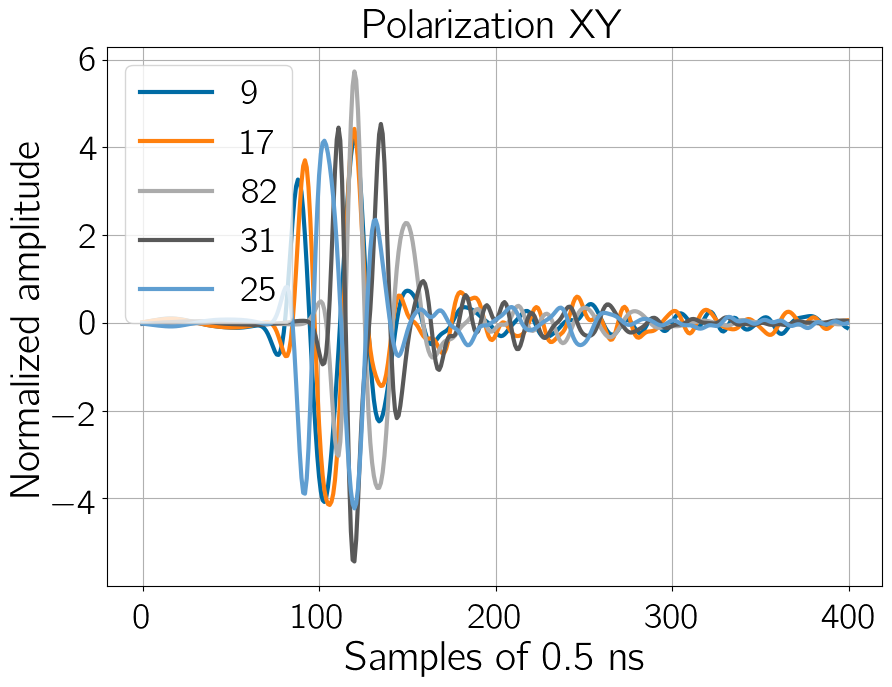

In [22]:
fig, ax = plt.subplots()

ids = [9,17,82,31,25]#[9,19,72]#[9,19,29,39,49,59,69,79]#[74,79]

for id in ids:
    ax.plot(templates[id],label=id)

ax.set_xlabel('Samples of 0.5 ns')
ax.set_ylabel('Normalized amplitude')

ax.set_title(f'Polarization {pol}')

#ax.text(230,6,'GRAND preliminary', color='crimson')

if savefig:
    plot_name = 'templates_XY'
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

ax.legend(frameon=True)

plt.show()

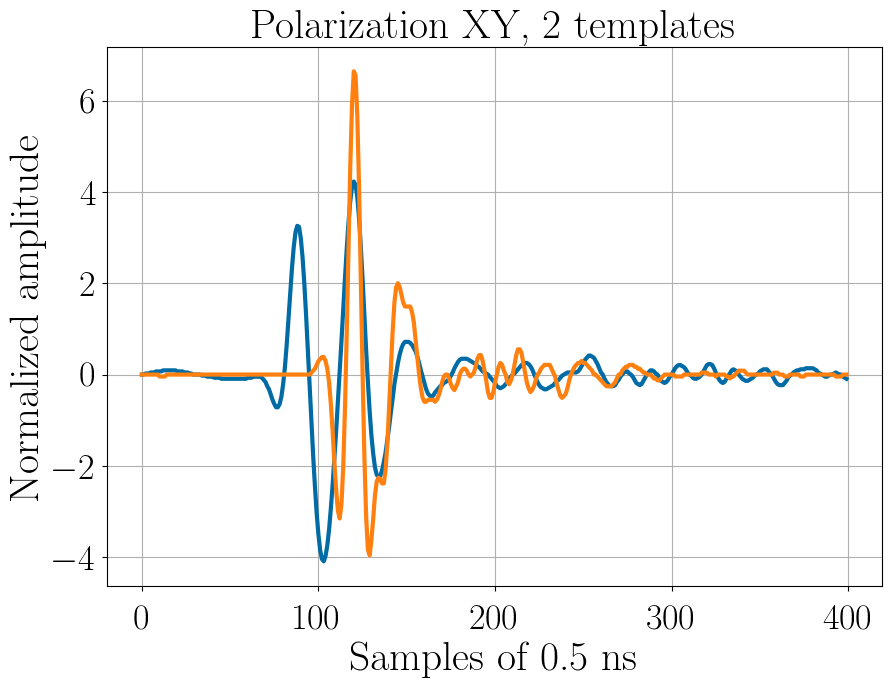

In [3]:
fig, ax = plt.subplots()

ax.plot(templates.T)

ax.set_xlabel('Samples of 0.5 ns')
ax.set_ylabel('Normalized amplitude')

ax.set_title(f'Polarization {pol}, {len(templates)} templates')

#ax.text(230,6,'GRAND preliminary', color='crimson')

if savefig:
    plot_name = 'templates_XY'
    
    plt.savefig( os.path.join(plot_dir,plot_name+'.png') )
    plt.savefig( os.path.join(plot_dir,plot_name+'.pdf') )

plt.show()

 Make a consistency check to see whether the cross correlation of the templates is maximal when the templates are identical. Also gives us an idea of how "different" the different templates are.

In [28]:
corr_grid = np.zeros((len(templates),len(templates)))

for i, template_1 in enumerate(templates):
    #norm = np.correlate(template_1**2,template_1**2)

    for j, template_2 in enumerate(templates):
        corr = np.correlate(template_1,template_2) / len(template_1)

        corr_grid[i,j] = corr #/norm

print(np.median(corr_grid))

0.2542810294646536


In [25]:
template_id = np.arange(1,len(templates)+1)
x, y = np.meshgrid(template_id,template_id)

/scratch/users/p/pcorrea/ipykernel_10019/3937714942.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  corr_plot = plt.pcolormesh(x,


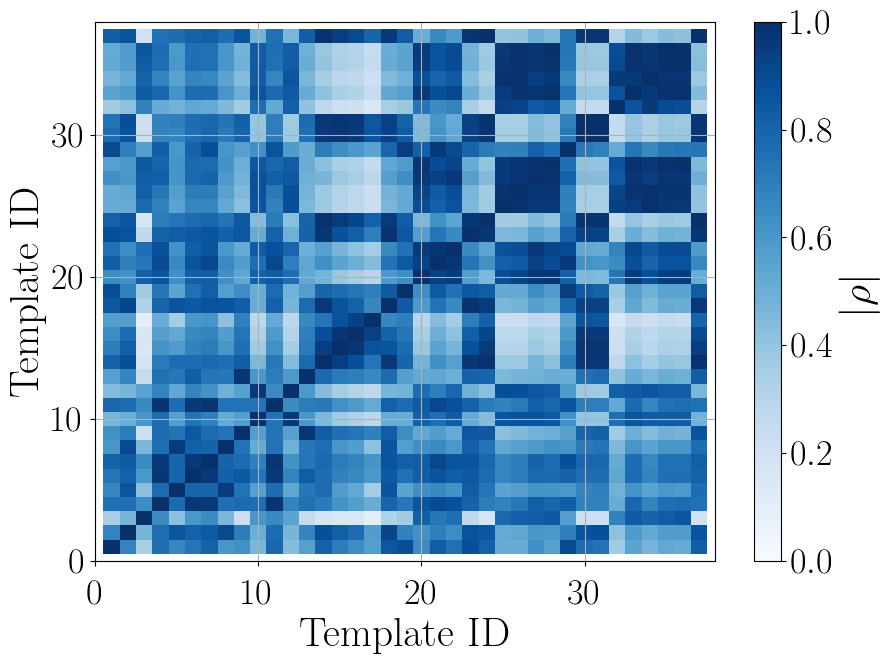

In [26]:
fig, ax = plt.subplots()
#fig.set_size_inches(10,10)

corr_plot = plt.pcolormesh(x,
                           y,
                           np.abs(corr_grid),
                           cmap='Blues',
                           vmin=0,
                           vmax=1
                           #norm=matplotlib.colors.LogNorm()
                           )

fig.colorbar(corr_plot, ax=ax, label=r'$|\rho|$')

lim = [0,len(templates)+1]
ax.set_xlim(lim)
ax.set_ylim(lim)

label = 'Template ID'
ax.set_xlabel(label)
ax.set_ylabel(label)

ax.grid(True)

plt.show()

In [29]:
np.argmax(corr_grid,axis=1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36])

In [ ]:
vf[81]

array(['gr_voltage_GP300_Xi_Sib_Proton_1.79_35.5_229.8_10474.root',
       'gr_voltage_GP300_Xi_Sib_Proton_1.53_34.1_192.6_15918.root',
       'gr_voltage_GP300_Xi_Sib_Proton_1.56_32.4_96.21_24356.root',
       'gr_voltage_GP300_Xi_Sib_Proton_1.24_35.5_22.35_2186.root',
       'gr_voltage_GP300_Xi_Sib_Proton_3.87_32.4_194.3_18190.root',
       'gr_voltage_GP300_Xi_Sib_Proton_1.62_35.9_347.3_22250.root',
       'gr_voltage_GP300_Xi_Sib_Proton_1.62_35.9_347.3_22250.root',
       'gr_voltage_GP300_Xi_Sib_Proton_1.33_36.4_233.1_7968.root',
       'gr_voltage_GP300_Xi_Sib_Proton_2.22_34.1_281.2_474.root',
       'gr_voltage_GP300_Xi_Sib_Proton_2.21_32.2_48.24_24392.root',
       'gr_voltage_GP300_Xi_Sib_Proton_1.09_37.3_273.8_8756.root',
       'gr_voltage_GP300_Xi_Sib_Proton_3.02_41.3_322.0_22364.root',
       'gr_voltage_GP300_Xi_Sib_Proton_1.38_41.1_51.14_23016.root',
       'gr_voltage_GP300_Xi_Sib_Proton_2.35_38.7_23.11_5972.root',
       'gr_voltage_GP300_Xi_Sib_Proton_3.02_41.3_322.0